In [19]:
# intvl = GenomicInterval(
#     chr='chr22',
#     chr_length=50818468,
#     start=100_000*200,
#     end=100_000*201
# )
# detailedIntvl = bam.detailedCoverage(intvl, params)
# detailedIntvl.printInterval()


In [20]:
# for ref, length in zip(fa.references, fa.lengths):
#     print(f'{ref}: {length}')

In [21]:
# print(bam.header)

## DNA content

In [171]:
nmapped = {'nuclear': 0, 'mt': 0, 'lambda': 0}
for c in bam.get_index_statistics():
    if c.contig == chr_MT: nmapped['mt'] += c.mapped
    elif c.contig == chr_lambda: nmapped['lambda'] += c.mapped
    else: nmapped['nuclear'] += c.mapped

lambda_DNA_content_vs_nuclear = nmapped['lambda']/nmapped['nuclear']
lambda_DNA_content_vs_MT = nmapped['lambda']/nmapped['mt']

data['lambda_DNA_content_vs_nuclear'] = fp(lambda_DNA_content_vs_nuclear)
data['lambda_DNA_content_vs_MT'] = fp(lambda_DNA_content_vs_MT)


nmapped['mt']/nmapped['nuclear'], nmapped['lambda']/nmapped['nuclear']

(0.005644493958732799, 0.002145064729776098)

## base and read quality

In [29]:
quality = Quality()
# gi = GenomicInterval('chr1', 2000000, 1000_000, 1001_000)
# bam.sample_reads(quality, gi, params)
# quality.regularization()

In [30]:
genomeGen = randomGenomicRegion(fa, bam, size=reads_sample_window)
isampled = 0
while quality.nreads < reads_to_sample and isampled < 1_000_000:
    region = next(genomeGen)
    bam.sample_reads(quality=quality, gi=region, params=params)
    isampled += 1
quality.regularization()
print(isampled, len(quality.base_quality))


1940 15107399


In [31]:
data['quality_nreads'] = fi(quality.nreads)
data['quality_nbases'] = fi(len(quality.base_quality))
data['quality_nloci'] = fi(isampled)

In [32]:
quality.__dict__

{'base_quality': array([41, 41, 41, ..., 41, 41, 37], dtype=uint8),
 'read_length': array([151, 151, 151, ..., 151, 151, 151]),
 'nreads': 100049,
 'ndup': 0,
 'nqcfail': 0,
 'npaired': 0,
 'nproperpaired': 0,
 'ncigars': array([14886770,   125337,    15848,        0,    95292,        0,
               0,        0,        0,        0]),
 'map_quality': array([60, 60, 60, ..., 59, 60, 60])}

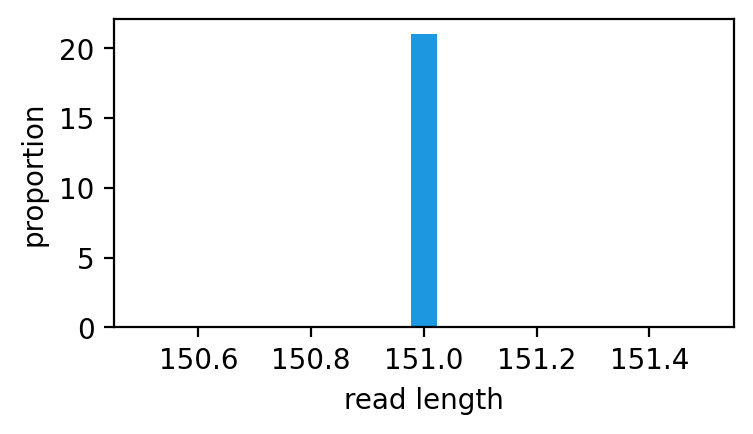

In [33]:
# read length
fig, ax = plt.subplots(figsize=(4,2))
plt.hist(quality.read_length, bins=21, density=True, color=COLS[0])
plt.xlabel('read length')
plt.ylabel('proportion')

filename = f'img/dist-read-length'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

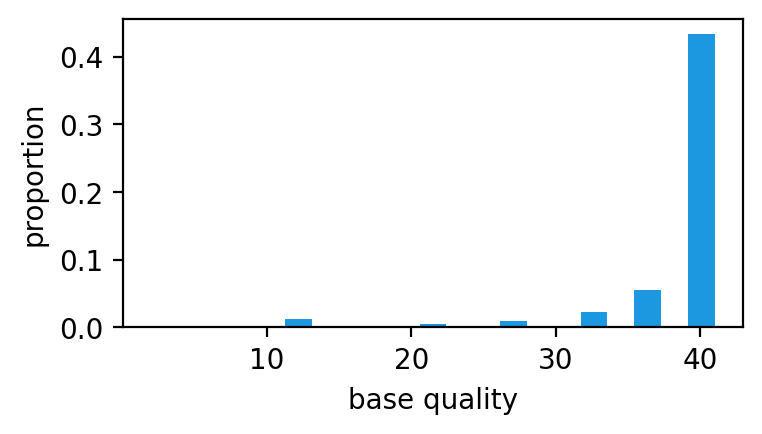

In [34]:
# base quality
fig, ax = plt.subplots(figsize=(4,2))
plt.hist(quality.base_quality, bins=21, density=True, color=COLS[0])
plt.xlabel('base quality')
plt.ylabel('proportion')

filename = f'img/dist-base-quality'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

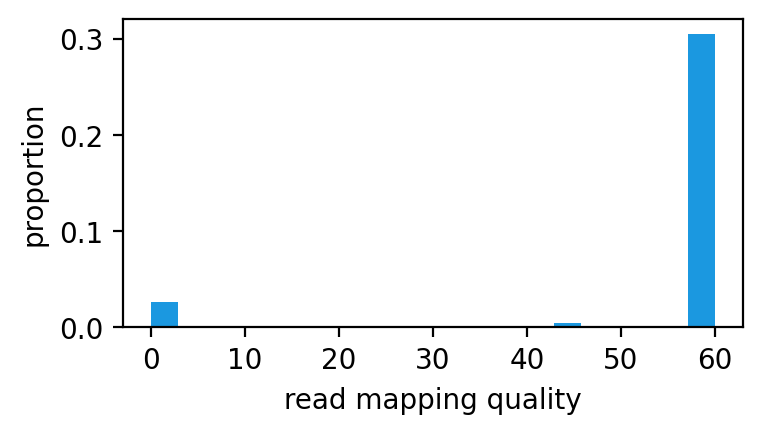

In [35]:
# map quality
fig, ax = plt.subplots(figsize=(4,2))
plt.hist(quality.map_quality, bins=21, density=True, color=COLS[0])
plt.xlabel('read mapping quality')
plt.ylabel('proportion')

filename = f'img/dist-read-map-quality'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

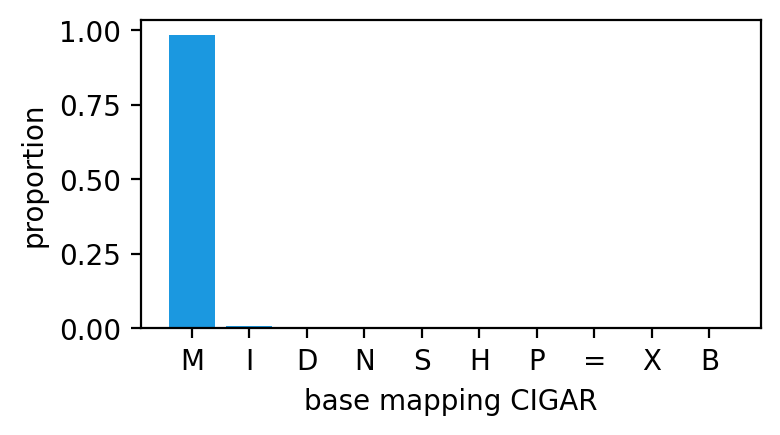

In [36]:
# cigar
prop = quality.ncigars/quality.ncigars.sum()
x = range(len(prop))
CIGARS = ['M', 'I', 'D', 'N', 'S', 'H', 'P', '=', 'X', 'B']

fig, ax = plt.subplots(figsize=(4,2))
plt.bar(x, prop, color=COLS[0])
plt.xticks(x, labels=CIGARS)
plt.xlabel('base mapping CIGAR')
plt.ylabel('proportion')

filename = f'img/dist-base-CIGAR'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## pan-gene meth

### gene sampling

In [39]:
genes = genesGenerator(gtffile)

genes_coding = []
genes_lnc = []
genes_non = []
for g in genes:
    if g.end - g.start <= 100: continue # filter short genes
    if g.biotype == 'protein_coding': 
        genes_coding.append(g)
    elif g.biotype == 'lncRNA':
        genes_lnc.append(g)
    else:
        genes_non.append(g)

def sampleGenes(l: list, k:int = 1000):
    k = min(k, len(l))
    s = random.sample(range(len(l)), k)
    s.sort()
    return [l[i] for i in s]



genes_coding_sampling = sampleGenes(genes_coding, k=PANGENE_SAMPLED)
genes_lnc_sampling = sampleGenes(genes_lnc, k=PANGENE_SAMPLED)
genes_non_sampling = sampleGenes(genes_non, k=PANGENE_SAMPLED)


In [214]:
data['ngene_coding'] = fi(len(genes_coding))
data['ngene_lnc'] = fi(len(genes_lnc))
data['ngene_noncoding'] = fi(len(genes_non))
data['PANGENE_SAMPLED'] = fi(PANGENE_SAMPLED)

len(genes_coding), len(genes_lnc), len(genes_non)

(20040, 19251, 20625)

### coding genes

In [43]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()

# coding
cov_pangene_coding = CovPanGene()
for i in tqdm.trange(len(genes_coding_sampling)):
    bam.update_pangene(cov_pangene_coding, genes_coding_sampling[i], params=params)

# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [26:58<00:00,  1.24it/s]  


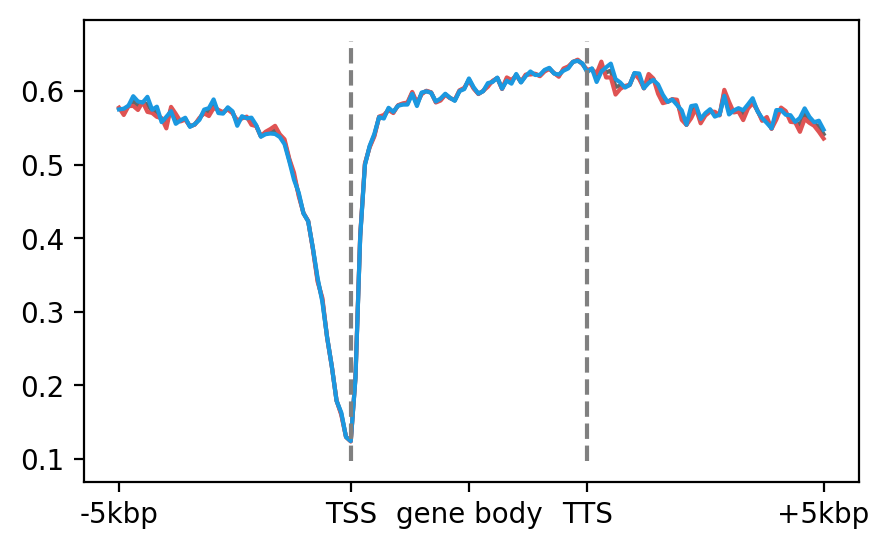

In [44]:
cov_pangene = cov_pangene_coding

fig, ax = plt.subplots(figsize=(5,3))
x = np.arange(gene_breaks*3)
y = cov_pangene.meCG/cov_pangene.nCG
ax.plot(x, y, '-', c=COL_gray)
ax.plot(x, cov_pangene.meCGW/cov_pangene.nCGW, '-', c=COLS[1])
ax.plot(x, cov_pangene.meCGC/cov_pangene.nCGC, '-', c=COLS[0])
ax.vlines((49, 99), ax.get_ylim()[0], ax.get_ylim()[1], color= 'gray', linestyles='dashed')
plt.xticks([0, 49, 74, 99, 149], labels=['-5kbp', 'TSS', 'gene body', 'TTS', '+5kbp'])

filename = f'img/pan-gene-meth-coding'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [45]:
# lncRNA
cov_pangene_lnc = CovPanGene()
for i in tqdm.trange(len(genes_lnc_sampling)):
    bam.update_pangene(cov_pangene_lnc, genes_lnc_sampling[i], params=params)


100%|██████████| 2000/2000 [13:01<00:00,  2.56it/s] 


### lncRNA genes

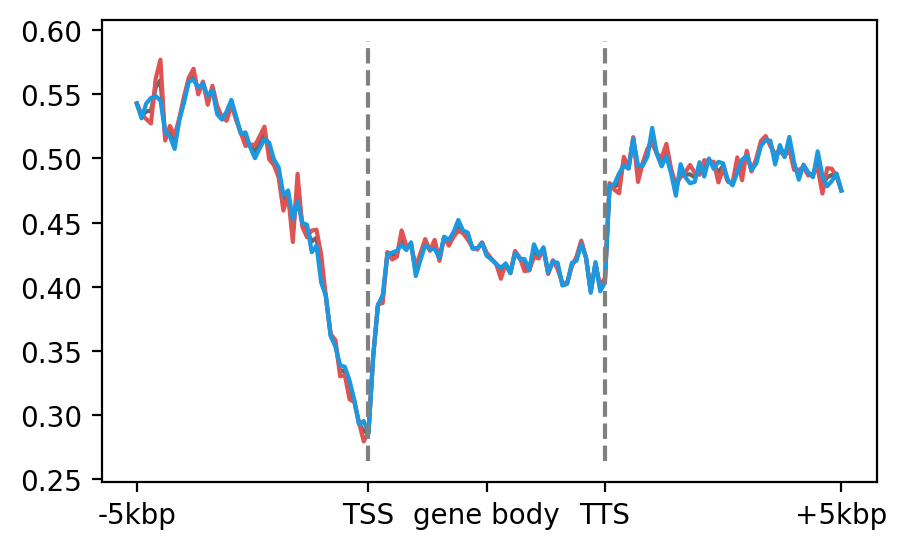

In [46]:
cov_pangene = cov_pangene_lnc

fig, ax = plt.subplots(figsize=(5,3))
x = np.arange(gene_breaks*3)
y = cov_pangene.meCG/cov_pangene.nCG
ax.plot(x, y, '-', c=COL_gray)
ax.plot(x, cov_pangene.meCGW/cov_pangene.nCGW, '-', c=COLS[1])
ax.plot(x, cov_pangene.meCGC/cov_pangene.nCGC, '-', c=COLS[0])
ax.vlines((49, 99), ax.get_ylim()[0], ax.get_ylim()[1], color= 'gray', linestyles='dashed')
plt.xticks([0, 49, 74, 99, 149], labels=['-5kbp', 'TSS', 'gene body', 'TTS', '+5kbp'])

filename = f'img/pan-gene-meth-lncRNA'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### other non-coding genes

In [47]:
# noncoding
cov_pangene_non = CovPanGene()
for i in tqdm.trange(len(genes_non_sampling)):
    bam.update_pangene(cov_pangene_non, genes_non_sampling[i], params=params)


100%|██████████| 2000/2000 [05:27<00:00,  6.10it/s]


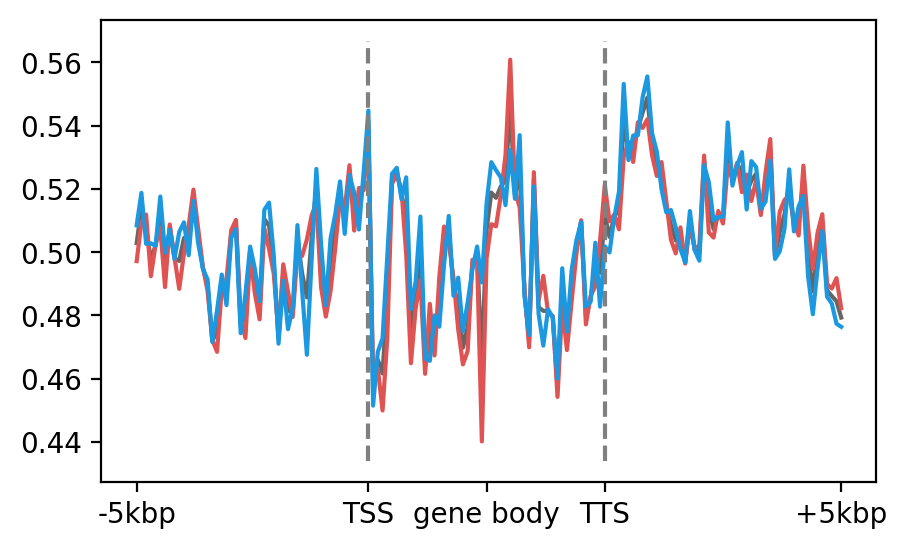

In [48]:
cov_pangene = cov_pangene_non

fig, ax = plt.subplots(figsize=(5,3))
x = np.arange(gene_breaks*3)
y = cov_pangene.meCG/cov_pangene.nCG

ax.plot(x, y, '-', c=COL_gray)
ax.plot(x, cov_pangene.meCGW/cov_pangene.nCGW, '-', c=COLS[1])
ax.plot(x, cov_pangene.meCGC/cov_pangene.nCGC, '-', c=COLS[0])
# ax.vlines((49, 99), min(y)-0.05, max(y)+0.05, color= 'gray', linestyles='dashed')
ax.vlines((49, 99), ax.get_ylim()[0], ax.get_ylim()[1], color= 'gray', linestyles='dashed')
plt.xticks([0, 49, 74, 99, 149], labels=['-5kbp', 'TSS', 'gene body', 'TTS', '+5kbp'])

filename = f'img/pan-gene-meth-other-noncoding'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## MT

In [49]:
## MT DNA
dict_MT = CovLambda(contig=chr_MT)
intervals = iter(GenomicIntervalGenerator(
    fa, 
    chrs= chr_MT, 
    start = 0,
    end = math.inf,
    step=5_000,
    # step=fa.get_reference_length('chrM'),
    spacing=0
    )) # type: ignore

intervals_list = list(intervals)
for i in tqdm.trange(len(intervals_list)):
    detailedIntvl = bam.detailedCoverageContig(intervals_list[i], params)
    update_lambda(dict_MT, detailedIntvl)
    

100%|██████████| 4/4 [02:38<00:00, 39.50s/it]


In [156]:
# whether lambda DNA is sequenced
if dict_MT.cov.sum() < 1:
    data['MT_is_covered'] = 0
else:
    data['MT_is_covered'] = 1

data['mt_nCorG'] = fi(dict_MT.nC)
data['mt_covnCorG'] = fi(dict_MT.covnC)
data['mt_covnCorG_prop'] = fp(dict_MT.covnC/dict_MT.nC)
data['mt_length'] = fi(dict_MT.length.sum())
data['mt_covn'] = fi(dict_MT.cov.sum())
data['mt_cov_prop'] = fp(dict_MT.cov.sum()/dict_MT.length.sum())
data['mt_bin_size'] = fi(dict_MT.length.max())
i = dict_MT.length > 0
mt_median_dp = np.median(dict_MT.dp[i]/dict_MT.length[i])
data['mt_median_dp'] = ff(np.median(dict_MT.dp[i]/dict_MT.length[i]))


In [51]:
# dict_MT.__dict__

{'length': array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
  

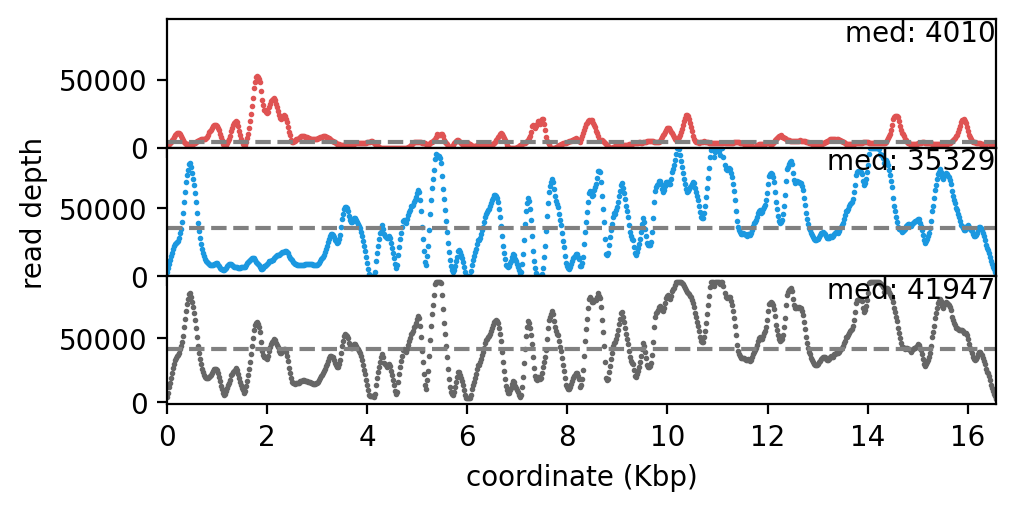

In [52]:
# binning coverage
x = np.arange(binsContig[chr_MT])*binSizeContig[chr_MT]
x, prefix = prefixBpSize(x)

yw = dict_MT.dpW/dict_MT.length
yc = dict_MT.dpC/dict_MT.length
yd = dict_MT.dp/dict_MT.length
ylim = np.quantile(np.block([yw,yc]), 0.99)

figheight = 3*0.5 + 1
figwidth = len(x)/200 + 1 + 0.2

fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(figwidth, figheight))
fig.subplots_adjust(hspace=0)

axs[0].plot(x, np.repeat(np.median(yw), len(x)), '--', c='gray')
axs[0].scatter(x, np.fmin(ylim, yw), c=COLS[1], s=1)
axs[0].set_xlim(0, max(x))
axs[0].set_ylim(0, ylim)
axs[0].text(axs[0].get_xlim()[1], axs[0].get_ylim()[1], f'med: {np.median(yw):.0f}', horizontalalignment='right', verticalalignment='top')

axs[1].plot(x, np.repeat(np.median(yc), len(x)), '--', c='gray')
axs[1].scatter(x, np.fmin(ylim, yc), c=COLS[0], s=1)
axs[1].set_xlim(0, max(x))
axs[1].set_ylim(0, ylim)
axs[1].text(axs[1].get_xlim()[1], axs[1].get_ylim()[1], f'med: {np.median(yc):.0f}', horizontalalignment='right', verticalalignment='top')
axs[1].set_ylabel(f'read depth')

axs[2].plot(x, np.repeat(np.median(yd), len(x)), '--', c='gray')
axs[2].scatter(x, np.fmin(ylim, yd), c=COL_gray, s=1)
axs[2].set_xlim(0, max(x))
axs[2].text(axs[2].get_xlim()[1], axs[2].get_ylim()[1], f'med: {np.median(yd):.0f}', horizontalalignment='right', verticalalignment='top')

plt.xlabel(f'coordinate ({prefix})')

filename = f'img/depth-bin-MT'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [161]:
## conversion rate by MT
mt_me = dict_MT.meC/dict_MT.covnC
data['mt_me'] = ff(mt_me)
bs_rate_MT = 1 - mt_me
dp_MT = dict_MT.dp/dict_MT.length
print(dict_MT.length.sum(), dict_MT.cov.sum(), np.mean(dp_MT), np.median(dp_MT), bs_rate_MT)

data['bsrate_mt'] = fp(bs_rate_MT)

16568 16568 45919.6028520235 41947.2 0.99015266


In [163]:
## eror rate by MT
i = dict_MT.dp20 > 0
data['err_rate_mt'] = 'nan'
if sum(i) > 0:
    error_rate_MT = np.mean(dict_MT.misbase[i]/dict_MT.dp20[i])
    data['err_rate_mt'] = fp(error_rate_MT)
data['err_rate_mt']

'7.03'

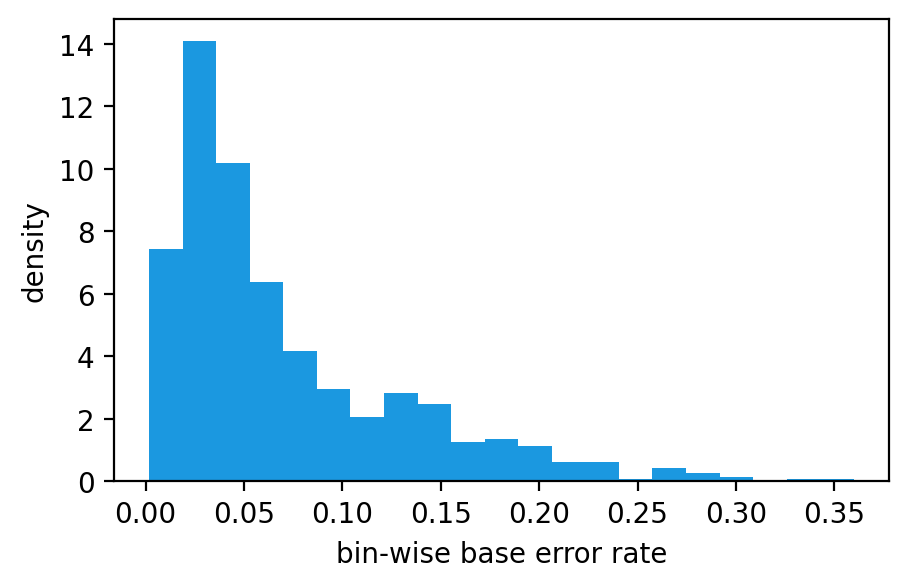

In [55]:
## base error rate
fig, ax = plt.subplots(figsize=(5,3))
if np.sum(dict_MT.dp20 > 0) > 0:
    ax.hist(nandivide(dict_MT.misbase, dict_MT.dp20), bins=21, density=True, color=COLS[0])
    plt.xlabel('bin-wise base error rate')
    plt.ylabel('density')

    filename = f'img/base-error-rate-dist-MT'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## lambda DNA

In [56]:
## lambda DNA
dict_lambda = CovLambda(contig=chr_lambda)
intervals = iter(GenomicIntervalGenerator(
    fa, 
    chrs= chr_lambda, 
    start = 0,    
    end = math.inf,
    step=5_000,
    spacing=0
    )) # type: ignore

intervals_list = list(intervals)
for i in tqdm.trange(len(intervals_list)):
    detailedIntvl = bam.detailedCoverageContig(intervals_list[i], params)
    update_lambda(dict_lambda, detailedIntvl)
    

100%|██████████| 10/10 [00:58<00:00,  5.81s/it]


In [57]:
# whether lambda DNA is sequenced
if dict_lambda.cov.sum() < 100:
    data['lambda_is_covered'] = 0
else:
    data['lambda_is_covered'] = 1

data['lambda_nCorG'] = fi(dict_lambda.nC)
data['lambda_covnCorG'] = fi(dict_lambda.covnC)
data['lambda_covnCorG_prop'] = fp(dict_lambda.covnC/dict_lambda.nC)
data['lambda_length'] = fi(dict_lambda.length.sum())
data['lambda_covn'] = fi(dict_lambda.cov.sum())
data['lambda_cov_prop'] = fp(dict_lambda.cov.sum()/dict_lambda.length.sum())
data['lambda_size'] = fi(dict_lambda.length.max())

i = dict_lambda.length > 0
lambda_median_dp = np.median(dict_lambda.dp[i]/dict_lambda.length[i])
data['lambda_median_dp'] = ff(np.median(dict_lambda.dp[i]/dict_lambda.length[i]))

In [48]:
# dict_lambda.__dict__

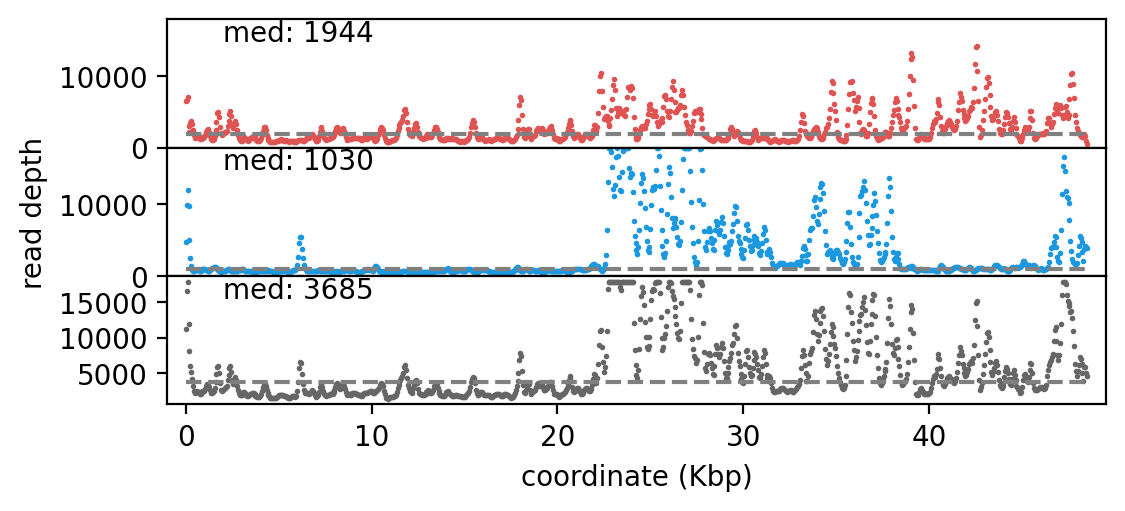

In [58]:
# binning coverage
x = np.arange(binsContig[chr_lambda])*binSizeContig[chr_lambda]
x, prefix = prefixBpSize(x)

yw = dict_lambda.dpW/dict_lambda.length
yc = dict_lambda.dpC/dict_lambda.length
yd = dict_lambda.dp/dict_lambda.length
ylim = np.quantile(np.block([yw,yc]), 0.99)

figheight = 3*0.5 + 1
figwidth = len(x)/200 + 1 + 0.2

fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(figwidth, figheight))
fig.subplots_adjust(hspace=0)
plt.xlim(-1, max(x)+1)

axs[0].plot(x, np.repeat(np.median(yw), len(x)), '--', c='gray')
axs[0].scatter(x, np.fmin(ylim, yw), c=COLS[1], s=1)
axs[0].set_ylim(0, ylim)
axs[0].text(2, axs[0].get_ylim()[1], f'med: {np.median(yw):.0f}', horizontalalignment='left', verticalalignment='top')

axs[1].plot(x, np.repeat(np.median(yc), len(x)), '--', c='gray')
axs[1].scatter(x, np.fmin(ylim, yc), c=COLS[0], s=1)
axs[1].set_ylim(0, ylim)
axs[1].text(2, axs[1].get_ylim()[1], f'med: {np.median(yc):.0f}', horizontalalignment='left', verticalalignment='top')
axs[1].set_ylabel('read depth')

axs[2].plot(x, np.repeat(np.median(yd), len(x)), '--', c='gray')
axs[2].scatter(x, np.fmin(ylim, yd), c=COL_gray, s=1)
axs[2].text(2, axs[2].get_ylim()[1], f'med: {np.median(yd):.0f}', horizontalalignment='left', verticalalignment='top')

plt.xlabel(f'coordinate ({prefix})')

filename = f'img/depth-bin-lambda'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [131]:
## cov and err of lambda DNA
bs_rate_lambda = -1
data['bsrate_lambda'] = "nan"
if dict_lambda.covnC > 100: # at least 100 Cs covered
    bs_rate_lambda = 1 - dict_lambda.meC/dict_lambda.covnC
    data['bsrate_lambda'] = fp(bs_rate_lambda)
    dp_lambda = dict_lambda.dp/dict_lambda.length
    print(dict_lambda.length.
    sum(), dict_lambda.cov.sum(), np.mean(dp_lambda), np.median(dp_lambda), bs_rate_lambda)


48502 48502 5945.246735324408 3684.84 0.9901022


In [51]:
# dict_lambda.__dict__

In [61]:
# base error rate by lambda DNA
i = dict_lambda.dp20 > 0
data['err_rate_lambda'] = "nan"
if sum(i) > 0:
    error_rate_lambda = np.mean(dict_lambda.misbase[i]/dict_lambda.dp20[i])
    data['err_rate_lambda'] = fp(error_rate_lambda)
data['err_rate_lambda']

'15.6'

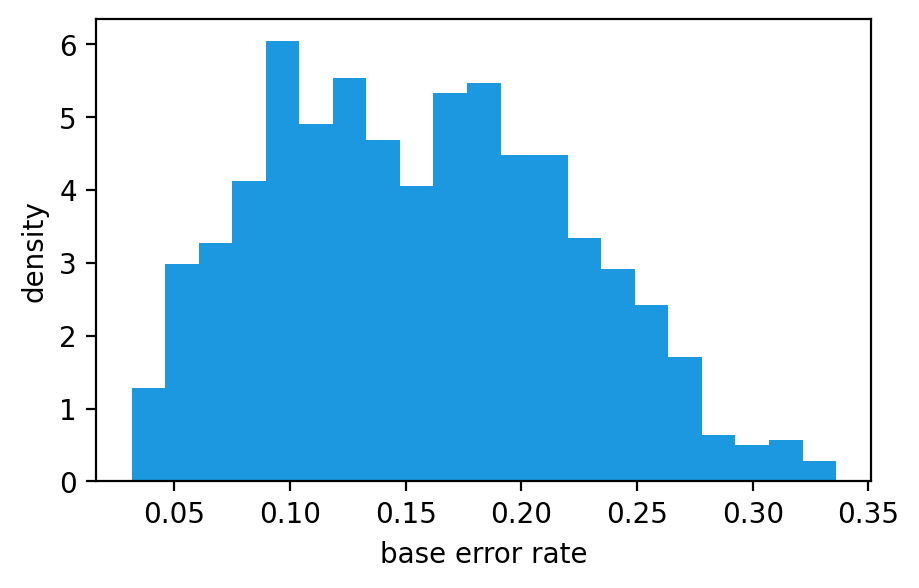

In [63]:
fig, ax = plt.subplots(figsize=(5,3))
if np.sum(dict_lambda.dp20 > 0) > 0:
    ax.hist(nandivide(dict_lambda.misbase, dict_lambda.dp20), bins=21, density=True, color=COLS[0])
    plt.xlabel('base error rate')
    plt.ylabel('density')

    filename = f'img/base-error-rate-dist-dict-lambda'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Sample nuclear genome

- according to chrs in .fa or
- according to chrs in header of .bam 

In [64]:
## nuclear chrs

intervals = iter(GenomicIntervalGenerator(
    fa, 
    chrs= testchrs,
    # chrs='all',
    start = 0,    
    end = math.inf,
    step=1_000,
    # spacing=10_000
    spacing=10000,
    )) # type: ignore

intervals_list = list(intervals)
for i in tqdm.trange(len(intervals_list)):
    detailedIntvl = bam.detailedCoverage(intervals_list[i], params)
    update_cgkmer(detailedIntvl)
    update_binning(detailedIntvl)
    

100%|██████████| 89995/89995 [58:11<00:00, 25.77it/s]   


In [55]:
# dict_cgkmer['CCCGGG'].__dict__

In [192]:
# dict_binning[('chr19', 124)].stranded_CG_meth.shape

(20, 20)

## From genome binning

### Whole-genome summary

In [65]:
# Whole-genome

length = []
totalDepth = []
totalDepthW = []
totalDepthC = []
binning_depth = []
binning_depthW = []
binning_depthC = []
binning_cov = []
binning_covW = []
binning_covC = []

stranded_CG_depth = 0
stranded_CG_meth = 0
CGmeth_diff_by_depth = 0

# whole-genome counts
meCG: NDArray = 0
meCGW: NDArray = 0
meCGC: NDArray = 0
meCHG: NDArray = 0
meCHGW: NDArray = 0
meCHGC: NDArray = 0
meCHH: NDArray = 0
meCHHW: NDArray = 0
meCHHC: NDArray = 0
covnCG: NDArray = 0
covnCGW: NDArray = 0
covnCGC: NDArray = 0
covnCHG: NDArray = 0
covnCHGW: NDArray = 0
covnCHGC: NDArray = 0
covnCHH: NDArray = 0
covnCHHW: NDArray = 0
covnCHHC: NDArray = 0
# total in genome
nCG = 0
nCGW = 0
nCGC = 0
nCHG = 0
nCHGW = 0
nCHGC = 0
nCHH = 0
nCHHW = 0
nCHHC = 0
ATdp = []
misbase = []
nCGMethBin = 0
nCHGMethBin = 0
nCHHMethBin = 0

for key, value in dict_binning.items():
    length.append(value.length)
    totalDepth.append(value.dp)
    totalDepthW.append(value.dpW)
    totalDepthC.append(value.dpC)
    binning_depth.append(-np.diff(np.block([value.cov, 0])))
    binning_depthW.append(-np.diff(np.block([value.covW, 0])))
    binning_depthC.append(-np.diff(np.block([value.covC, 0])))
    binning_cov.append(value.cov)
    binning_covW.append(value.covW)
    binning_covC.append(value.covC)
    stranded_CG_depth += value.stranded_CG_depth
    stranded_CG_meth += value.stranded_CG_meth
    CGmeth_diff_by_depth += value.CGmeth_diff_by_depth
    
    nCG += value.nCG
    nCGW += value.nCGW
    nCGC += value.nCGC
    nCHG += value.nCHG
    nCHGW += value.nCHGW
    nCHGC += value.nCHGC
    nCHH += value.nCHH
    nCHHW += value.nCHHW
    nCHHC += value.nCHHC
    covnCG += value.covnCG
    covnCGW += value.covnCGW
    covnCGC += value.covnCGC
    covnCHG += value.covnCHG
    covnCHGW += value.covnCHGW
    covnCHGC += value.covnCHGC
    covnCHH += value.covnCHH
    covnCHHW += value.covnCHHW
    covnCHHC += value.covnCHHC
    meCG += value.meCG
    meCGW += value.meCGW
    meCGC += value.meCGC
    meCHG += value.meCHG
    meCHGW += value.meCHGW
    meCHGC += value.meCHGC
    meCHH += value.meCHH
    meCHHW += value.meCHHW
    meCHHC += value.meCHHC
    ATdp.append(value.ATdp)
    misbase.append(value.misbase)
    nCGMethBin += value.nCGMethBin
    nCHGMethBin += value.nCHGMethBin
    nCHHMethBin += value.nCHHMethBin

length = np.asarray(length)
binning_depth = np.asarray(binning_depth)
binning_depthW = np.asarray(binning_depthW)
binning_depthC = np.asarray(binning_depthC)
binning_cov = np.asarray(binning_cov)
binning_covW = np.asarray(binning_covW)
binning_covC = np.asarray(binning_covC)
# whole-genome cov
genome_cov = np.sum(binning_cov, axis=0)
genome_covW = np.sum(binning_covW, axis=0)
genome_covC = np.sum(binning_covC, axis=0)

totalDepth = np.asarray(totalDepth)
totalDepthW = np.asarray(totalDepthW)
totalDepthC = np.asarray(totalDepthC)
totalBases = totalDepth.sum()
totalBasesW = totalDepthW.sum()
totalBasesC = totalDepthC.sum()
ATdp =  np.asarray(ATdp)
misbase = np.asarray(misbase)

# define DP threshold
prop_CG = covnCG/covnCG[0]
DP_xdepth = MAXDEPTH -1 - np.argmax(prop_CG[::-1] >= 0.03)

gen = np.random.Generator(np.random.PCG64())


In [66]:
data['nCHH'] = fi(nCHH)

i = length > 0
median_dp = np.median( totalDepth[i]/length[i])
data['median_dp'] = ff(median_dp)
data['median_dp']

'45.1'

In [67]:
# culmuative meth
# dict_genome_me = {
#     'CG': {'double': nandivide(meCG,covnCG), 'W': nandivide(meCGW,covnCGW), 'C': nandivide(meCGC,covnCGC)},
#     'CHG': {'double': nandivide(meCHG,covnCHG), 'W': nandivide(meCHGW,covnCHGW), 'C': nandivide(meCHGC,covnCHGC)},
#     'CHH': {'double': nandivide(meCHH,covnCHH), 'W': nandivide(meCHHW,covnCHHW), 'C': nandivide(meCHHC,covnCHHC)}
#     }

# culmulative covered Cs
dict_genome_covnC = { 
'CG': {'double': covnCG, 'W': covnCGW, 'C': covnCGC},
'CHG': {'double': covnCHG, 'W': covnCHGW, 'C': covnCHGC},
'CHH': {'double': covnCHH, 'W': covnCHHW, 'C': covnCHHC}
}

# culmulative me
dict_genome_me = { 
'CG': {'double': meCG, 'W': meCGW, 'C': meCGC},
'CHG': {'double': meCHG, 'W': meCHGW, 'C': meCHGC},
'CHH': {'double': meCHH, 'W': meCHHW, 'C': meCHHC}
}

# genome Cs
dict_Cs = {
    'CG':{'double': nCG, 'W': nCGW, 'C': nCGC},
    'CHG':{'double': nCHG, 'W': nCHGW, 'C': nCHGC},
    'CHH':{'double': nCHH, 'W': nCHHW, 'C': nCHHC}
}


### chromosome-wise stats

In [68]:
# bin-wise
dict_bin_meCG = dict()
dict_bin_meCGW = dict()
dict_bin_meCGC = dict()
dict_bin_meCHG = dict()
dict_bin_meCHGW = dict()
dict_bin_meCHGC = dict()
dict_bin_meCHH = dict()
dict_bin_meCHHW = dict()
dict_bin_meCHHC = dict()
dict_bin_dp = dict()
dict_bin_dpW = dict()
dict_bin_dpC = dict()
DP_valid = 30


In [69]:
chrs_valid = []
lens_valid = []
for i, chr in enumerate(fa.references):
    if not chr.endswith(('_random', '_alt')) and not chr.startswith('chrUn_') and chr not in ['chrL', 'chrM']:
        chrs_valid.append(chr)
        lens_valid.append(fa.lengths[i])
        nbin = int(np.ceil(fa.lengths[i]/binSize))
        dict_bin_meCG[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCGW[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCGC[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHG[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHGW[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHGC[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHH[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHHW[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_meCHHC[chr] = np.zeros((nbin, DP_valid), dtype=float)
        dict_bin_dp[chr] = np.zeros((nbin, ), dtype=float)
        dict_bin_dpW[chr] = np.zeros((nbin, ), dtype=float)
        dict_bin_dpC[chr] = np.zeros((nbin, ), dtype=float)

lens_valid = np.array(lens_valid)


In [70]:
# chromosome-wise
# sum of meth
dict_chr_meCG = dict.fromkeys(chrs_valid, 0)
dict_chr_meCGW = dict.fromkeys(chrs_valid, 0)
dict_chr_meCGC = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHG = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHGW = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHGC = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHH = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHHW = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHHC = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHG = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHGW = dict.fromkeys(chrs_valid, 0)
dict_chr_meCHGC = dict.fromkeys(chrs_valid, 0)
# covnCG
dict_chr_covnCG = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCGW = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCGC = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHG = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHGW = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHGC = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHH = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHHW = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHHC = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHG = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHGW = dict.fromkeys(chrs_valid, 0)
dict_chr_covnCHGC = dict.fromkeys(chrs_valid, 0)

In [71]:
for key, value in dict_binning.items():
    chr, bin = key
    if chr not in chrs_valid: continue

    # meth CG
    index = value.covnCG[:DP_valid] >= 1
    dict_bin_meCG[chr][bin, index] = value.meCG[:DP_valid][index]/value.covnCG[:DP_valid][index]
    dict_bin_meCG[chr][bin, ~index] = np.nan
    # meth CG W
    index = value.covnCGW[:DP_valid] >= 1
    dict_bin_meCGW[chr][bin, index] = value.meCGW[:DP_valid][index]/value.covnCGW[:DP_valid][index]
    dict_bin_meCGW[chr][bin, ~index] = np.nan
    # meth CG C
    index = value.covnCGC[:DP_valid] >= 1
    dict_bin_meCGC[chr][bin, index] = value.meCGC[:DP_valid][index]/value.covnCGC[:DP_valid][index]
    dict_bin_meCGC[chr][bin, ~index] = np.nan
    # meth CHG
    index = value.covnCHG[:DP_valid] >= 1
    dict_bin_meCHG[chr][bin, index] = value.meCHG[:DP_valid][index]/value.covnCHG[:DP_valid][index]
    dict_bin_meCHG[chr][bin, ~index] = np.nan
    # meth CHG W
    index = value.covnCHGW[:DP_valid] >= 1
    dict_bin_meCHGW[chr][bin, index] = value.meCHGW[:DP_valid][index]/value.covnCHGW[:DP_valid][index]
    dict_bin_meCHGW[chr][bin, ~index] = np.nan
    # meth CHG C
    index = value.covnCHGC[:DP_valid] >= 1
    dict_bin_meCHGC[chr][bin, index] = value.meCHGC[:DP_valid][index]/value.covnCHGC[:DP_valid][index]
    dict_bin_meCHGC[chr][bin, ~index] = np.nan
    # meth CHH
    index = value.covnCHH[:DP_valid] >= 1
    dict_bin_meCHH[chr][bin, index] = value.meCHH[:DP_valid][index]/value.covnCHH[:DP_valid][index]
    dict_bin_meCHH[chr][bin, ~index] = np.nan
    # meth CHH W
    index = value.covnCHHW[:DP_valid] >= 1
    dict_bin_meCHHW[chr][bin, index] = value.meCHHW[:DP_valid][index]/value.covnCHHW[:DP_valid][index]
    dict_bin_meCHHW[chr][bin, ~index] = np.nan
    # meth CHH C
    index = value.covnCHHC[:DP_valid] >= 1
    dict_bin_meCHHC[chr][bin, index] = value.meCHHC[:DP_valid][index]/value.covnCHHC[:DP_valid][index]
    dict_bin_meCHHC[chr][bin, ~index] = np.nan
    # depth
    if value.length < 0: continue
    dict_bin_dp[chr][bin] = value.dp/value.length
    dict_bin_dpW[chr][bin] = value.dpW/value.length
    dict_bin_dpC[chr][bin] = value.dpC/value.length

    ## chr-wise me
    dict_chr_meCG[chr] += value.meCG[:DP_valid]
    dict_chr_meCGW[chr] += value.meCGW[:DP_valid]
    dict_chr_meCGC[chr] += value.meCGC[:DP_valid]
    dict_chr_meCHG[chr] += value.meCHG[:DP_valid]
    dict_chr_meCHGW[chr] += value.meCHGW[:DP_valid]
    dict_chr_meCHGC[chr] += value.meCHGC[:DP_valid]
    dict_chr_meCHH[chr] += value.meCHH[:DP_valid]
    dict_chr_meCHHW[chr] += value.meCHHW[:DP_valid]
    dict_chr_meCHHC[chr] += value.meCHHC[:DP_valid]
    ## chr-wise cov
    dict_chr_covnCG[chr] += value.covnCG[:DP_valid]
    dict_chr_covnCGW[chr] += value.covnCGW[:DP_valid]
    dict_chr_covnCGC[chr] += value.covnCGC[:DP_valid]
    dict_chr_covnCHG[chr] += value.covnCHG[:DP_valid]
    dict_chr_covnCHGW[chr] += value.covnCHGW[:DP_valid]
    dict_chr_covnCHGC[chr] += value.covnCHGC[:DP_valid]
    dict_chr_covnCHH[chr] += value.covnCHH[:DP_valid]
    dict_chr_covnCHHW[chr] += value.covnCHHW[:DP_valid]
    dict_chr_covnCHHC[chr] += value.covnCHHC[:DP_valid]
    

In [72]:
dict_chr_me = {
    'CG':{'double': dict_chr_meCG,'W': dict_chr_meCGW, 'C':dict_chr_meCGC},
    'CHG':{'double': dict_chr_meCHG,'W': dict_chr_meCHGW, 'C':dict_chr_meCHGC},
    'CHH':{'double': dict_chr_meCHH,'W': dict_chr_meCHHW, 'C':dict_chr_meCHHC}
    }
dict_chr_cov = {
    'CG':{'double': dict_chr_covnCG,'W': dict_chr_covnCGW, 'C':dict_chr_covnCGC},
    'CHG':{'double': dict_chr_covnCHG,'W': dict_chr_covnCHGW, 'C':dict_chr_covnCHGC},
    'CHH':{'double': dict_chr_covnCHH,'W': dict_chr_covnCHHW, 'C':dict_chr_covnCHHC}
    }
dict_bin_me = {
    'CG':{'double': dict_bin_meCG,'W': dict_bin_meCGW, 'C':dict_bin_meCGC},
    'CHG':{'double': dict_bin_meCHG,'W': dict_bin_meCHGW, 'C':dict_bin_meCHGC},
    'CHH':{'double': dict_bin_meCHH,'W': dict_bin_meCHHW, 'C':dict_bin_meCHHC}
}
dict_bin_depth = {'double': dict_bin_dp,'W': dict_bin_dpW, 'C':dict_bin_dpC}

### Error rate

In [73]:
# error rate by A/T sites
i = ATdp >= 100
err_AT = misbase[i]/ATdp[i]
err_rate_AT = np.mean(err_AT)
data['err_rate_AT'] = fp(err_rate_AT)

print(np.median(err_AT), np.mean(err_AT))

0.007067553604194935 0.007447170803190438


### dist of binning error rate

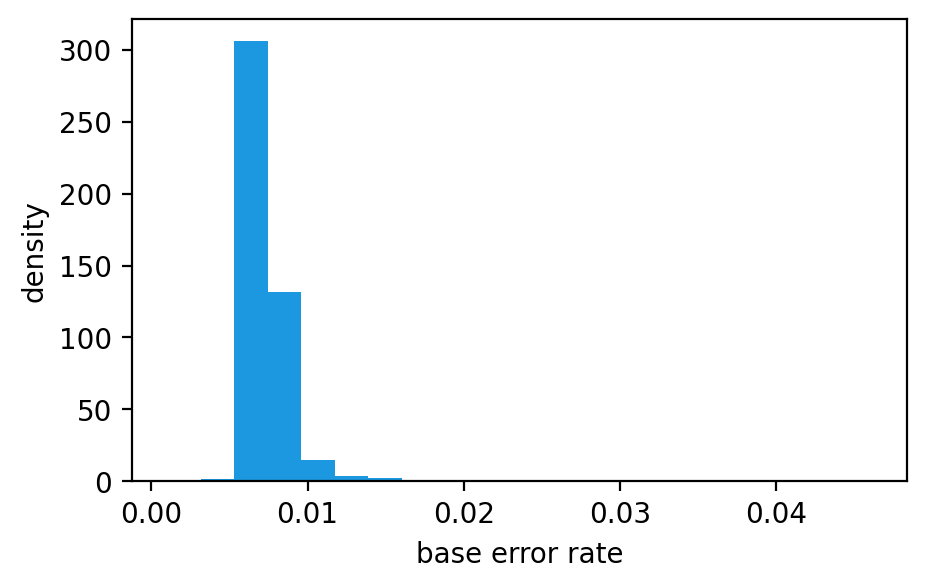

In [74]:
fig, ax = plt.subplots(figsize=(5,3))
if len(err_AT) > 10:
    ax.hist(err_AT, bins=21, density=True, color=COLS[0])
    plt.xlabel('base error rate')
    plt.ylabel('density')

    filename = f'img/base-error-rate-by-AT'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### Bisulfite coversion rate 

In [75]:
# by CHH meth weighted by dp
wdp = np.sqrt(np.arange(MAXDEPTH-1))
w = -np.diff(covnCHH)*wdp
mechh = np.sum(-np.diff(meCHH)*wdp)/w.sum()
bs_rate_chh = 1 - mechh
mechh, bs_rate_chh

(np.float64(0.009803918464860957), np.float64(0.990196081535139))

In [134]:
# data['bsrate_chh'] = fp(1-dict_genome_me['CHH']['double'][0]/dict_genome_covnC['CHH']['double'][0])
data['bsrate_chh'] = fp(bs_rate_chh)

data['bsrate_warning'] = int(max(bs_rate_chh, bs_rate_MT, bs_rate_lambda) < 0.9)

In [157]:
## MT DNA copy number 
mt_mean_dp = np.sum(dict_MT.dp)/np.sum(dict_MT.length)
mean_dp = np.sum(totalDepth)/np.sum(length)
mt_copynum = mt_mean_dp / mean_dp *2
data['mt_mean_dp'] = ff(mt_mean_dp, 4)
data['mean_dp'] = ff(mean_dp, 4)
data['mt_copynum'] = ff(mt_copynum, 4)
data['mt_copynum']

'1908'

In [168]:
# lambda depth
lambda_mean_dp = np.sum(dict_lambda.dp)/np.sum(dict_lambda.length)
i = dict_lambda.length > 0
lambda_median_dp = np.median(dict_lambda.dp[i] / dict_lambda.length[i])
lambda_copynum = lambda_mean_dp / mean_dp *2
data['lambda_mean_dp'] = ff2(lambda_mean_dp, 1)
data['lambda_median_dp'] = ff2(lambda_median_dp, 1)
data['lambda_copynum'] = ff(lambda_copynum, 4)


### Adjust DNAme level

In [72]:
# adjusted CHH meth 
# 1 - (1-mechh)/bs_rate_lambda
# 1 - (1-0.010737456170736626)/bs_rate_lambda

In [73]:
# adjusted CHG meth 
# 1 - (1-mechg)/bs_rate_lambda
# 1 - (1-0.45828452)/0.9901022021143293

In [81]:
def adjust_me(me, bsrate):
    return 1 - (1 - me)/bsrate

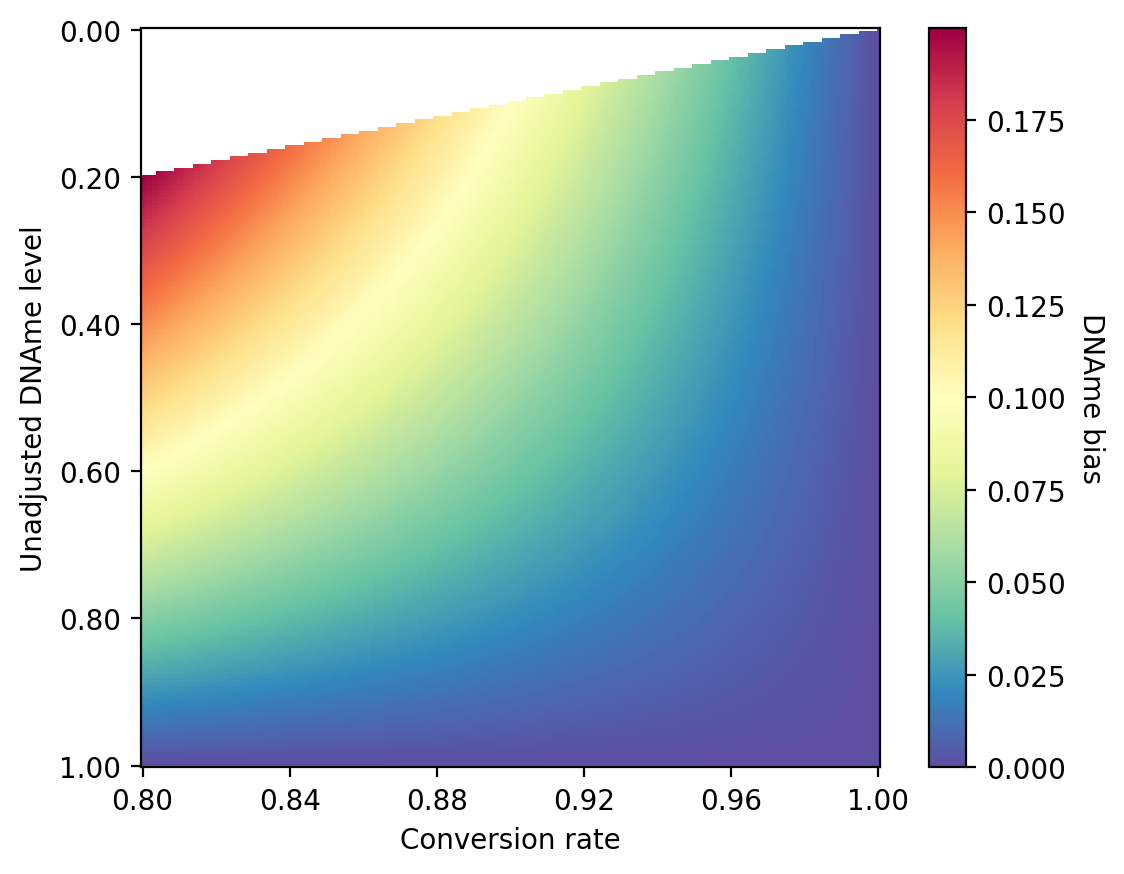

In [82]:
# DNAme bias
bsrate = np.linspace(0.8, 1, 200)
meth = np.linspace(0, 1, 200)
meth0 = 1 - np.outer(1-meth, 1/bsrate)
meth_bias = np.outer(meth, np.ones(200)) - meth0

# constrant: meth + bsrate >= 1
tmp = np.outer(meth, np.ones(200)) + np.outer(np.ones(200), bsrate)
meth_bias[tmp<1] = np.nan

fig, ax = plt.subplots()
im = ax.imshow(meth_bias, cmap='Spectral_r')

ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
x = np.linspace(0, 200-1, 6)
lx = [f'{x:.2f}' for x in np.linspace(0.8, 1, 6)]
y = np.linspace(0, 200-1, 6)
ly = [f'{y:.2f}' for y in np.linspace(0, 1, 6)]
ax.set_xticks(x, labels=lx)
ax.set_yticks(y, labels=ly)
plt.xlabel('Conversion rate')
plt.ylabel('Unadjusted DNAme level')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('DNAme bias', rotation=-90, va="bottom")

filename = f'img/DNAme-bias'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [136]:
# adopted bs conversion rate
if data['lambda_is_covered'] == 1:
    bs_rate = bs_rate_lambda
elif data['MT_is_covered'] == 1:
    bs_rate = bs_rate_MT
else:
    bs_rate = bs_rate_chh

data['bs_rate'] = fp(bs_rate)

# adjust whole-genome DNAme
data['me_CG'] = fp(meCG[0]/covnCG[0])
data['me_CG_adj'] = fp(adjust_me(meCG[0]/covnCG[0], bs_rate))
data['me_CHG'] = fp(meCHG[0]/covnCHG[0])
data['me_CHG_adj'] = fp(adjust_me(meCHG[0]/covnCHG[0], bs_rate))
data['me_CHH'] = fp(meCHH[0]/covnCHH[0])
data['me_CHH_adj'] = fp(adjust_me(meCHH[0]/covnCHH[0], bs_rate))

### Methylation distribution

In [ ]:
## methylation distribution
# counts of Cs by meth level binning
methDist = {'CG': nCGMethBin, 'CHG': nCHGMethBin, 'CHH': nCHHMethBin}

for key, value in methDist.items():
    count = np.cumsum(value[:,::-1], axis=1)[:,::-1]
    prop = count / np.sum(count, axis=0)
    ylim = axlimit(np.max(prop))
    shape = np.shape(prop)
    x = np.arange(shape[0])
    x2 = np.arange(0,shape[0]+1, 4)
    xlabels=x2/shape[0]
    for DP in range(shape[1]):
    # for DP in range(1):
        filename = f'img/meth-dist-genome-{key}-dp{DP+1}'
        fig, ax = plt.subplots(figsize=(5,2))
        ax.bar(x, prop[:,DP], width=1, align='edge', color='#1B98E0')
        ax.set_xticks(x2, xlabels)
        ax.set_ylim(0, ylim)
        ax.set_xlabel('methylation level')
        ax.set_ylabel('proportion')
        plt.savefig(filename+'.png', transparent=True, dpi=120, bbox_inches='tight')
        plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### chr-wise meth

In [ ]:
# chr-wise meth

chrs_plot = testchrs.split(',')
strand = 'double'
for cg in CONTEXTS:
    # chrs_plot = [chr for chr in chrs_valid if np.any(dict_chr_me[cg][strand][chr] != 0)]
    figwidth = min(12, len(chrs_plot)*0.15 + 1)
    ylim = 0
    me_list = []
    for dp in range(DP_valid):
        me = [dict_chr_me[cg][strand][chr][dp]/dict_chr_cov[cg][strand][chr][dp] for chr in chrs_plot]
        me_list.append(me)
        ylim = max(ylim, max(me))
    ylim = axlimit(ylim)
    for dp in range(DP_valid):
        fig, ax = plt.subplots(figsize = (figwidth,2))
        ax.bar(chrs_plot, me_list[dp], color=COLS[0])
        ax.set_ylim(0, ylim)
        plt.xticks(rotation=45)
        ax.set_ylabel('mean methylation')
        filename = f'img/meth-chr-{cg}-{strand}-dp{dp+1}'
        plt.savefig(filename+'.png', transparent=True, dpi=120, bbox_inches='tight')
        plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')
    

## CpG strandness

### CGs of different depths

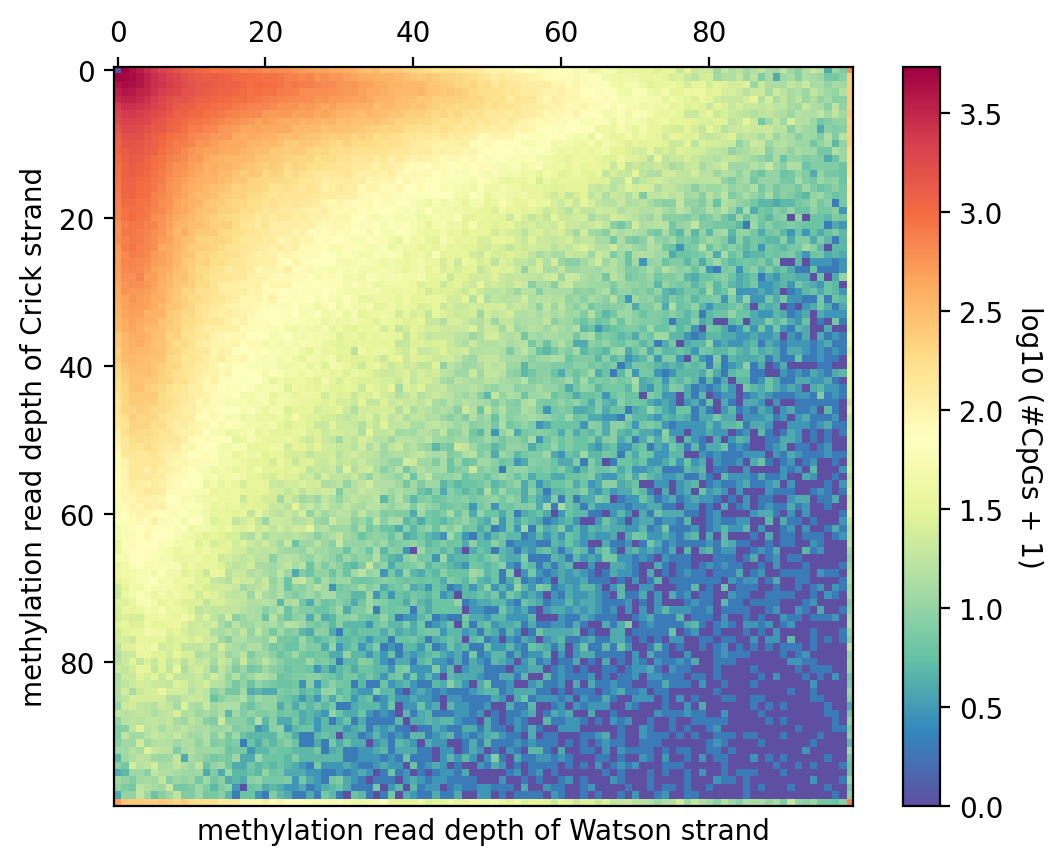

In [86]:
n = stranded_CG_depth.shape[0]
x = np.arange(5) *20

fig, ax = plt.subplots()
stranded_CG_depth[0,0] = 0
im = ax.imshow(np.log10(1+stranded_CG_depth), cmap='Spectral_r')
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticks(x, labels=x)
ax.set_yticks(x, labels=x)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('log10 (#CpGs + 1)', rotation=-90, va="bottom")
plt.xlabel('methylation read depth of Watson strand')
plt.ylabel('methylation read depth of Crick strand')

filename = f'img/heatmap-cg-stranded-depth'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### CG depth difference

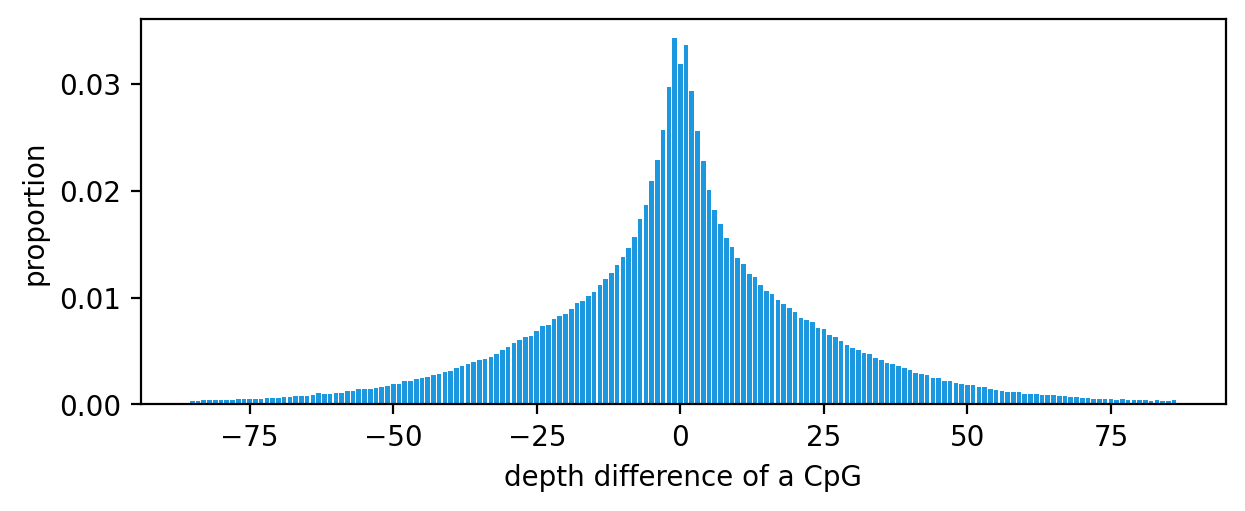

In [87]:
## CG stranded cov difference
cov_diff = np.zeros((199,), dtype=int)
shape = np.shape(stranded_CG_depth)
for i in range(shape[0]):
    for j in range(shape[1]):
        if (i,j) == (0,0): continue
        cov_diff[i-j+99] += stranded_CG_depth[i,j]
dp_diff = np.arange(-99, 100)
cov_diff = cov_diff/cov_diff.sum()

dp = min(DP_xdepth+20, 100)

fig, ax = plt.subplots(figsize=(7, 2.5))
ax.bar(dp_diff[(100-dp):(100+dp)], cov_diff[(100-dp):(100+dp)], color=COLS[0])
plt.xlabel('depth difference of a CpG')
plt.ylabel('proportion')

filename = f'img/cg-stranded-depth-difference'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [88]:
# mean/sd, M(mean)AD/sd of cov diff
a = np.inner(dp_diff, cov_diff)
sda = math.sqrt(np.inner(dp_diff**2, cov_diff) - a**2)
b = np.inner(np.abs(dp_diff), cov_diff)
sdb = math.sqrt(np.inner(dp_diff**2, cov_diff) - b**2)
a, sda, b, sdb

(np.float64(-0.026171658863435067),
 25.87768916966063,
 np.float64(18.165821046156104),
 18.42982440058317)

### CGs of double-stranded coverage 

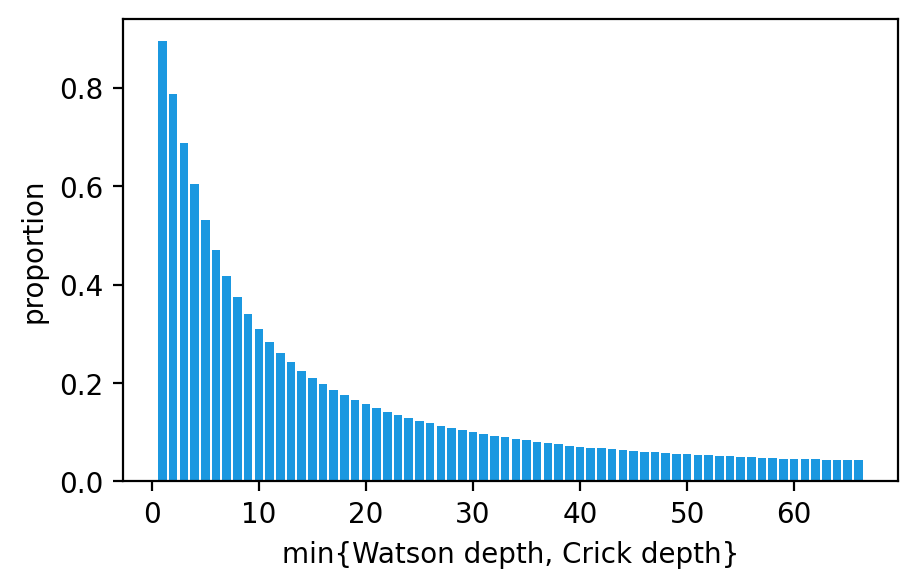

In [89]:
## CGs of double-srtanded coverage
prop_double_cov = np.zeros((DP_xdepth,))
shape = np.shape(stranded_CG_depth)
for i in np.arange(1, DP_xdepth+1):
    b = stranded_CG_depth[i:, i:].sum() # both
    a = stranded_CG_depth[i:,:].sum() + stranded_CG_depth[:,i:].sum() - b
    prop_double_cov[i-1] = b/a

fig, ax = plt.subplots(figsize=(5,3))
ax.bar(np.arange(1, DP_xdepth+1), prop_double_cov, color=COLS[0])
plt.xlabel('min{Watson depth, Crick depth}')
plt.ylabel('proportion')

filename = f'img/cg-prop-of-double-stranded-coverage'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### CG stranded meth

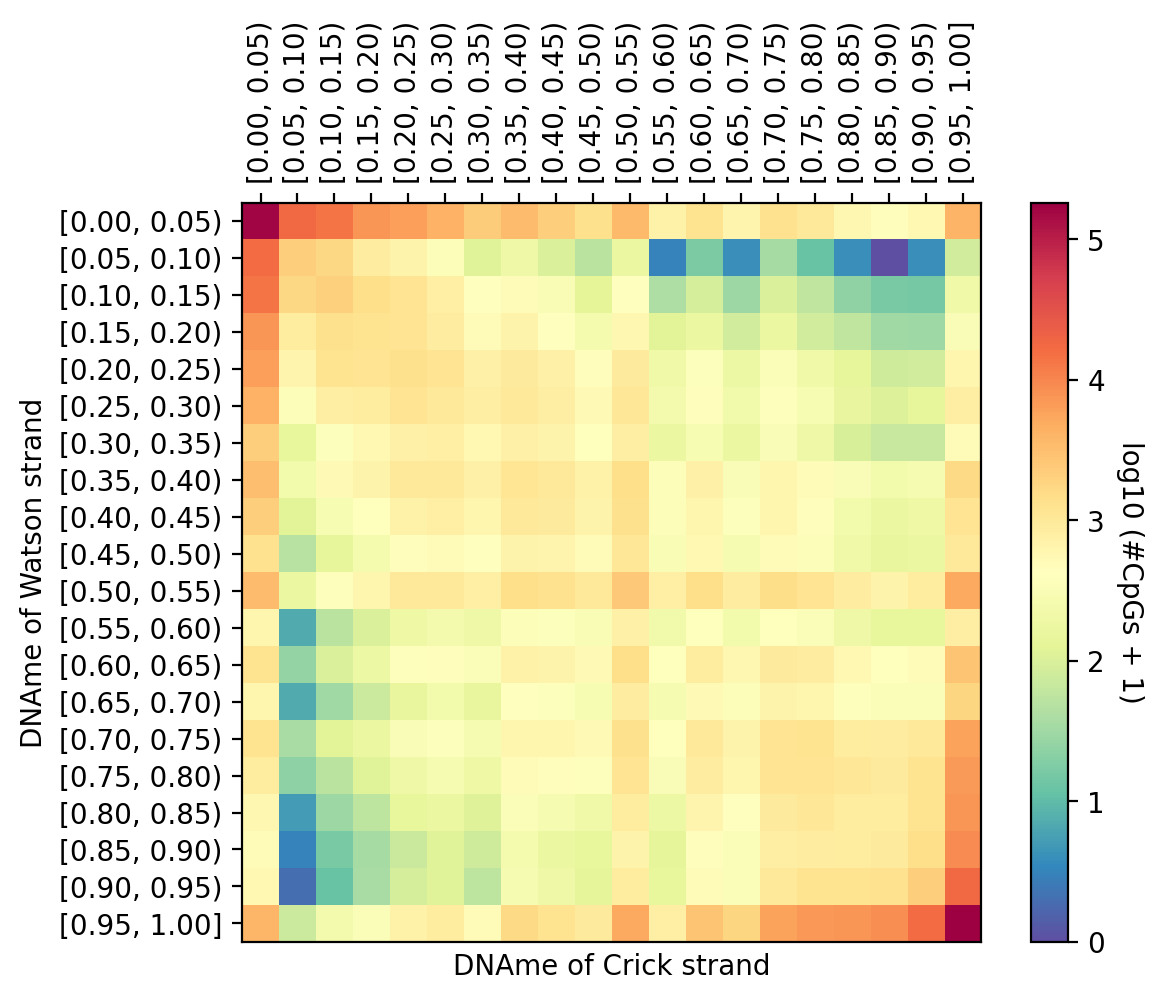

In [207]:
# DP >= 1
n = stranded_CG_meth.shape[0]
x = np.arange(n)
labels = [
    f'[{k/n:.2f}, {(k+1)/n:.2f})' 
    if k<n-1 else f'[{k/n:.2f}, {(k+1)/n:.2f}]' 
    for k in np.arange(n)
    ]
fig, ax = plt.subplots()
im = ax.imshow(np.log10(1+stranded_CG_meth), cmap='Spectral_r')
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticks(x, labels=labels)
ax.set_yticks(x, labels=labels)
plt.xlabel('DNAme of Crick strand')
plt.ylabel('DNAme of Watson strand')

ax.tick_params(axis='x', labelrotation= 90)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('log10 (#CpGs + 1)', rotation=-90, va="bottom")

filename = f'img/heatmap-cg-stranded-meth'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### heatmap of meth diff by DP

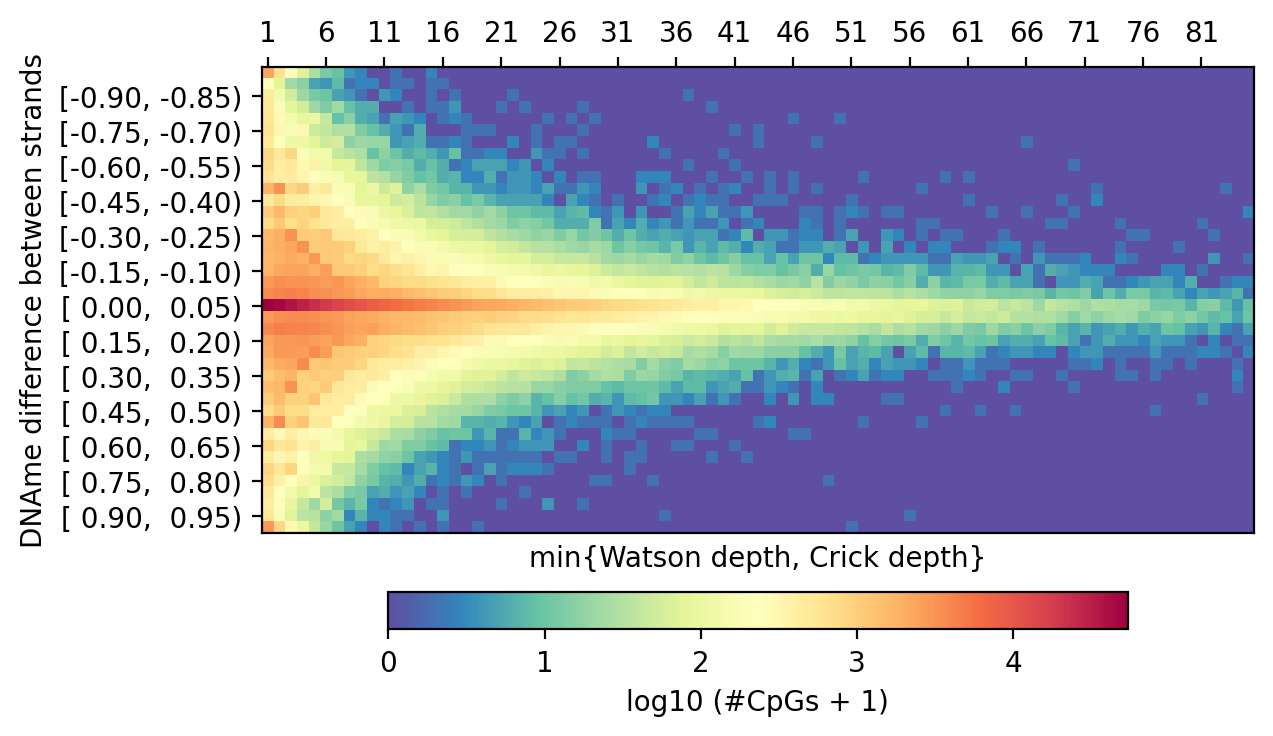

In [210]:
# n = stranded_CG_meth.shape[0]
y = np.arange(2, 40, step=3)
dp = min(100,DP_xdepth+20)
x = np.arange(dp-1, step=5)
labels = [
    f'[{k/n:5.2f}, {(k+1)/n:5.2f})' 
    if k<n-1 else f'[{k/n:5.2f}, {(k+1)/n:5.2f}]' 
    for k in np.arange(-18, 20, step=3)
    ]
fig, ax = plt.subplots()
im = ax.imshow(np.log10(1+CGmeth_diff_by_depth[:,1:dp]), cmap='Spectral_r')
# im = ax.imshow(np.log10(1+stranded_CG_meth), cmap='Spectral_r')
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_yticks(y, labels=labels)
ax.set_xticks(x, labels=x+1)
plt.xlabel('min{Watson depth, Crick depth}')
plt.ylabel('DNAme difference between strands')

# ax.tick_params(axis='x', labelrotation= 90)
cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal', fraction=0.05, pad=0.08)
# cbar.ax.set_ylabel('log10 (#CpGs + 1)', rotation=-90, va="bottom")
cbar.ax.set_xlabel('log10 (#CpGs + 1)')

filename = f'img/heatmap-cg-stranded-meth-diff'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Binning

### binning methylation

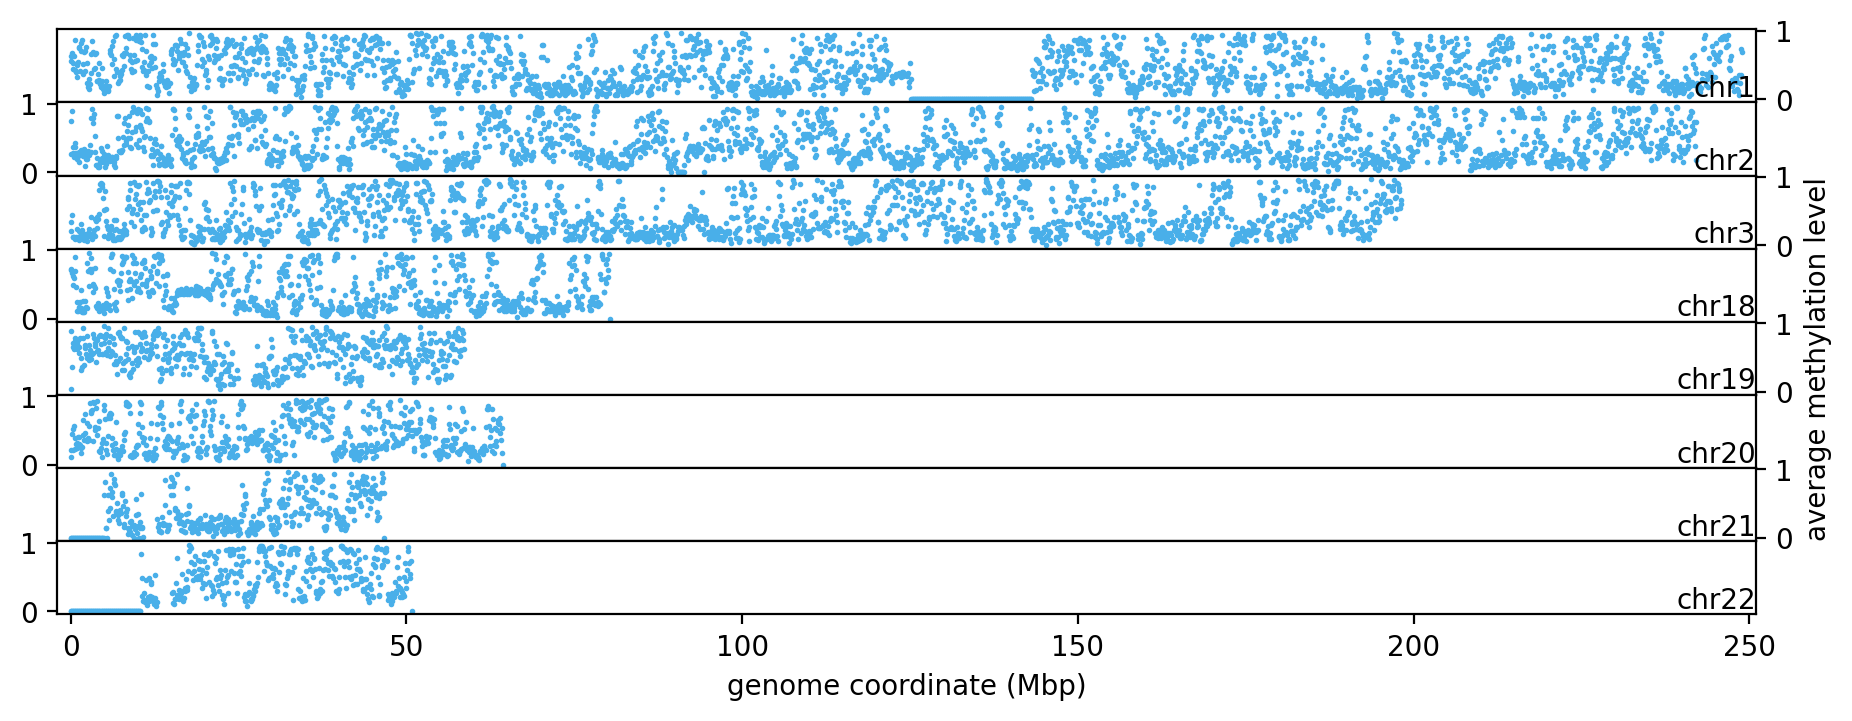

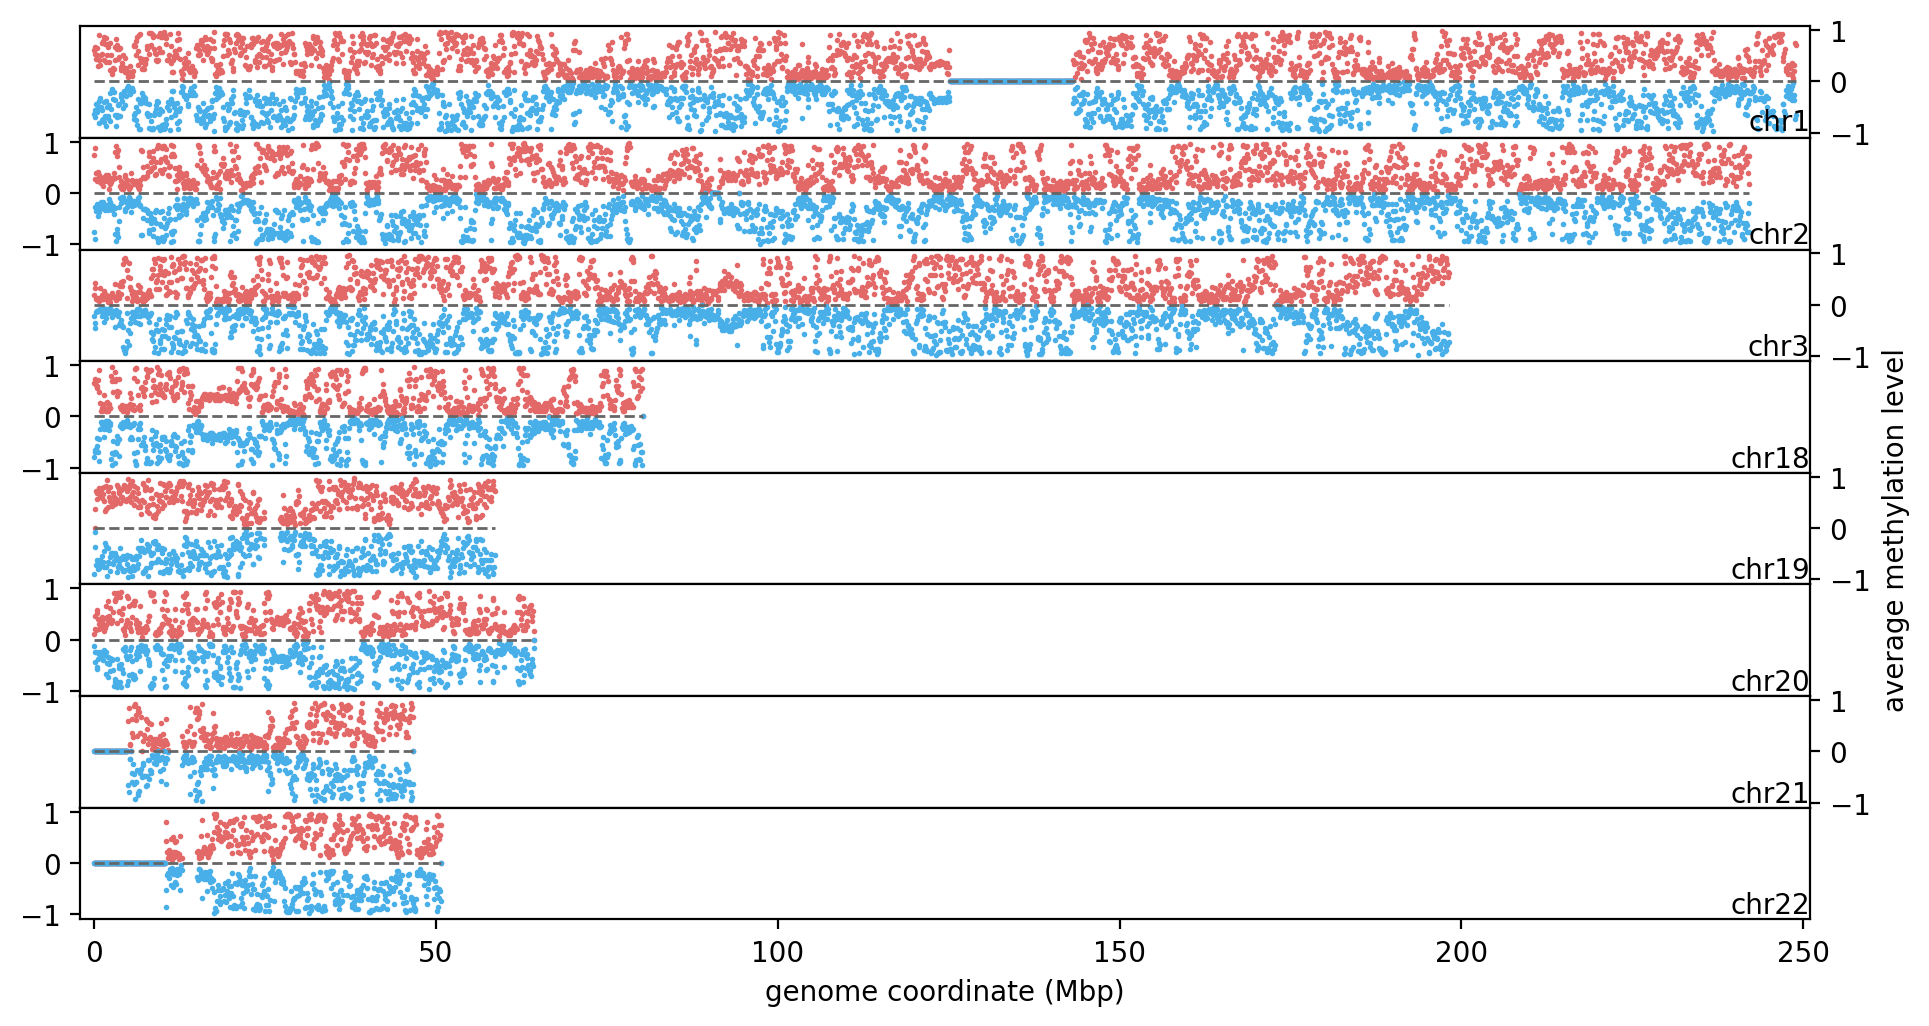

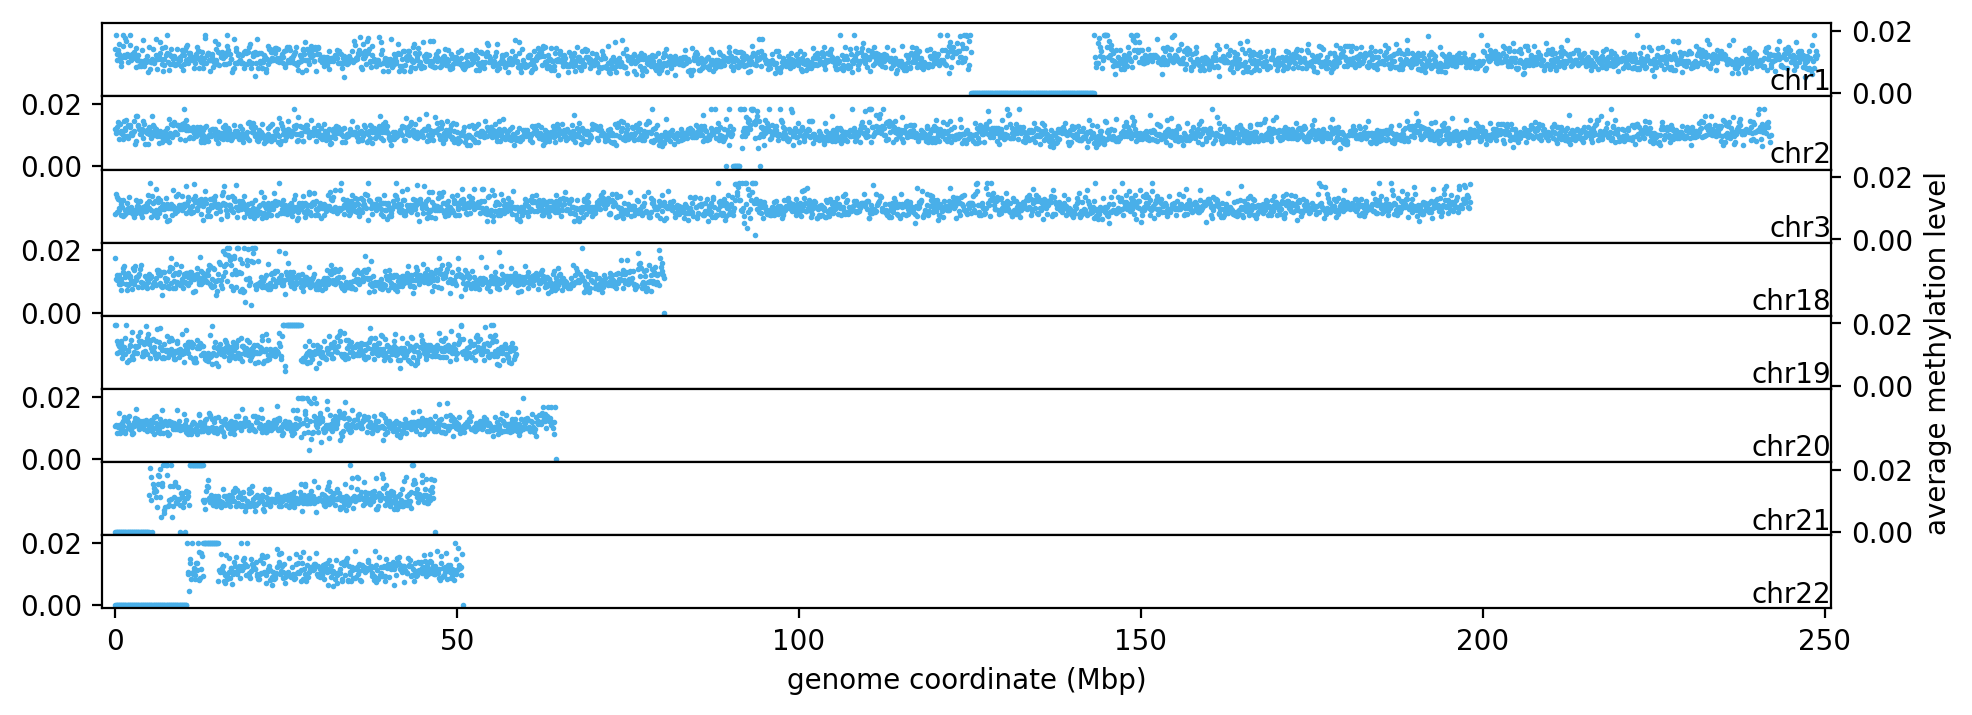

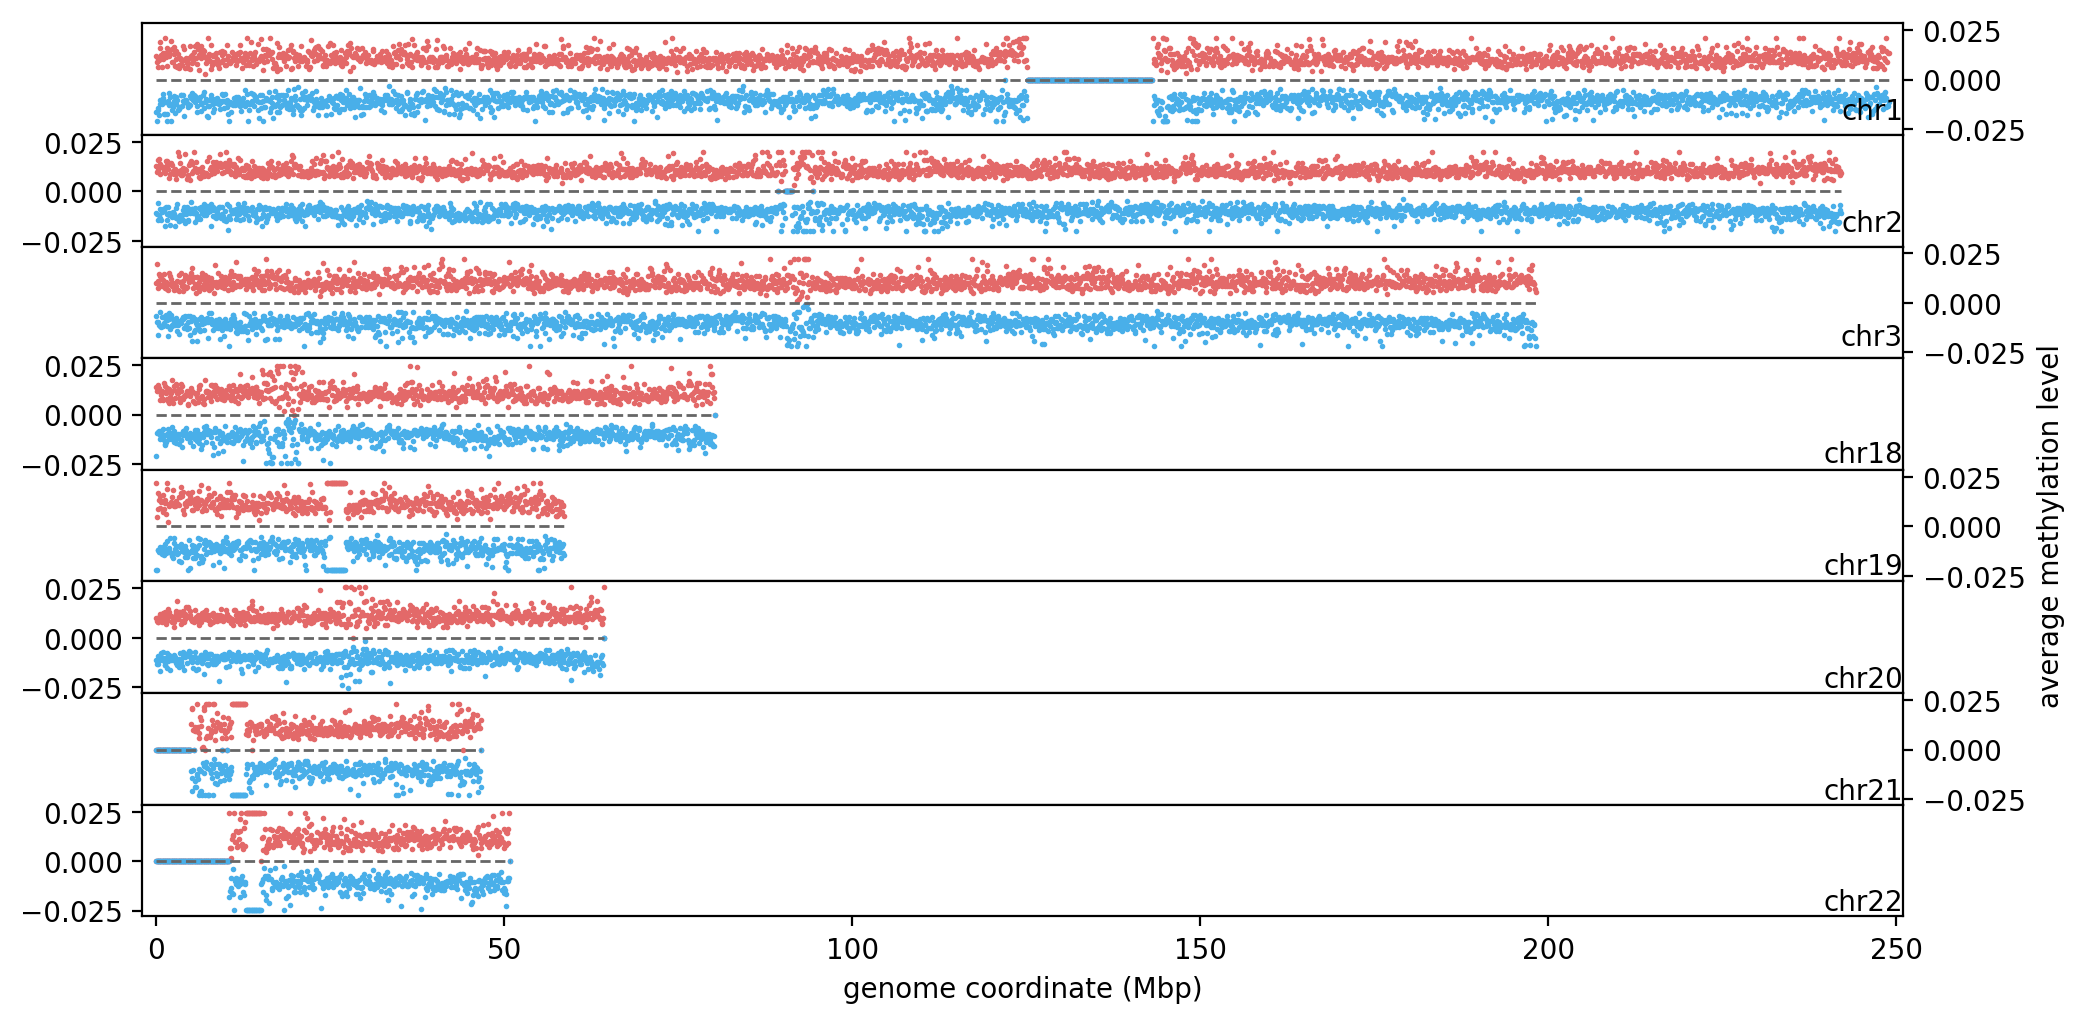

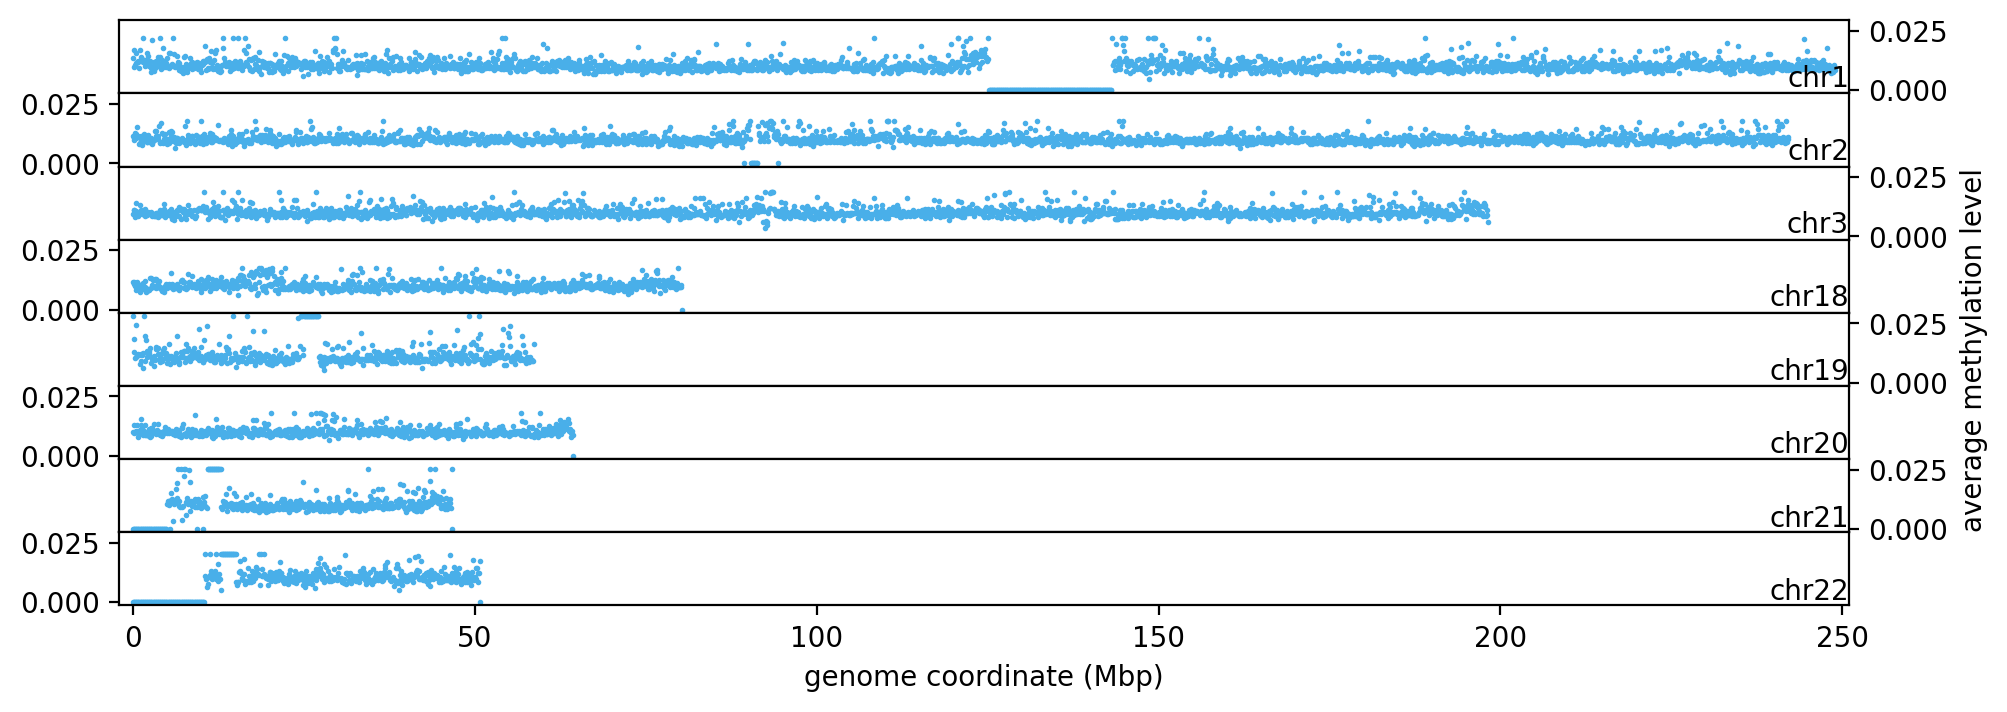

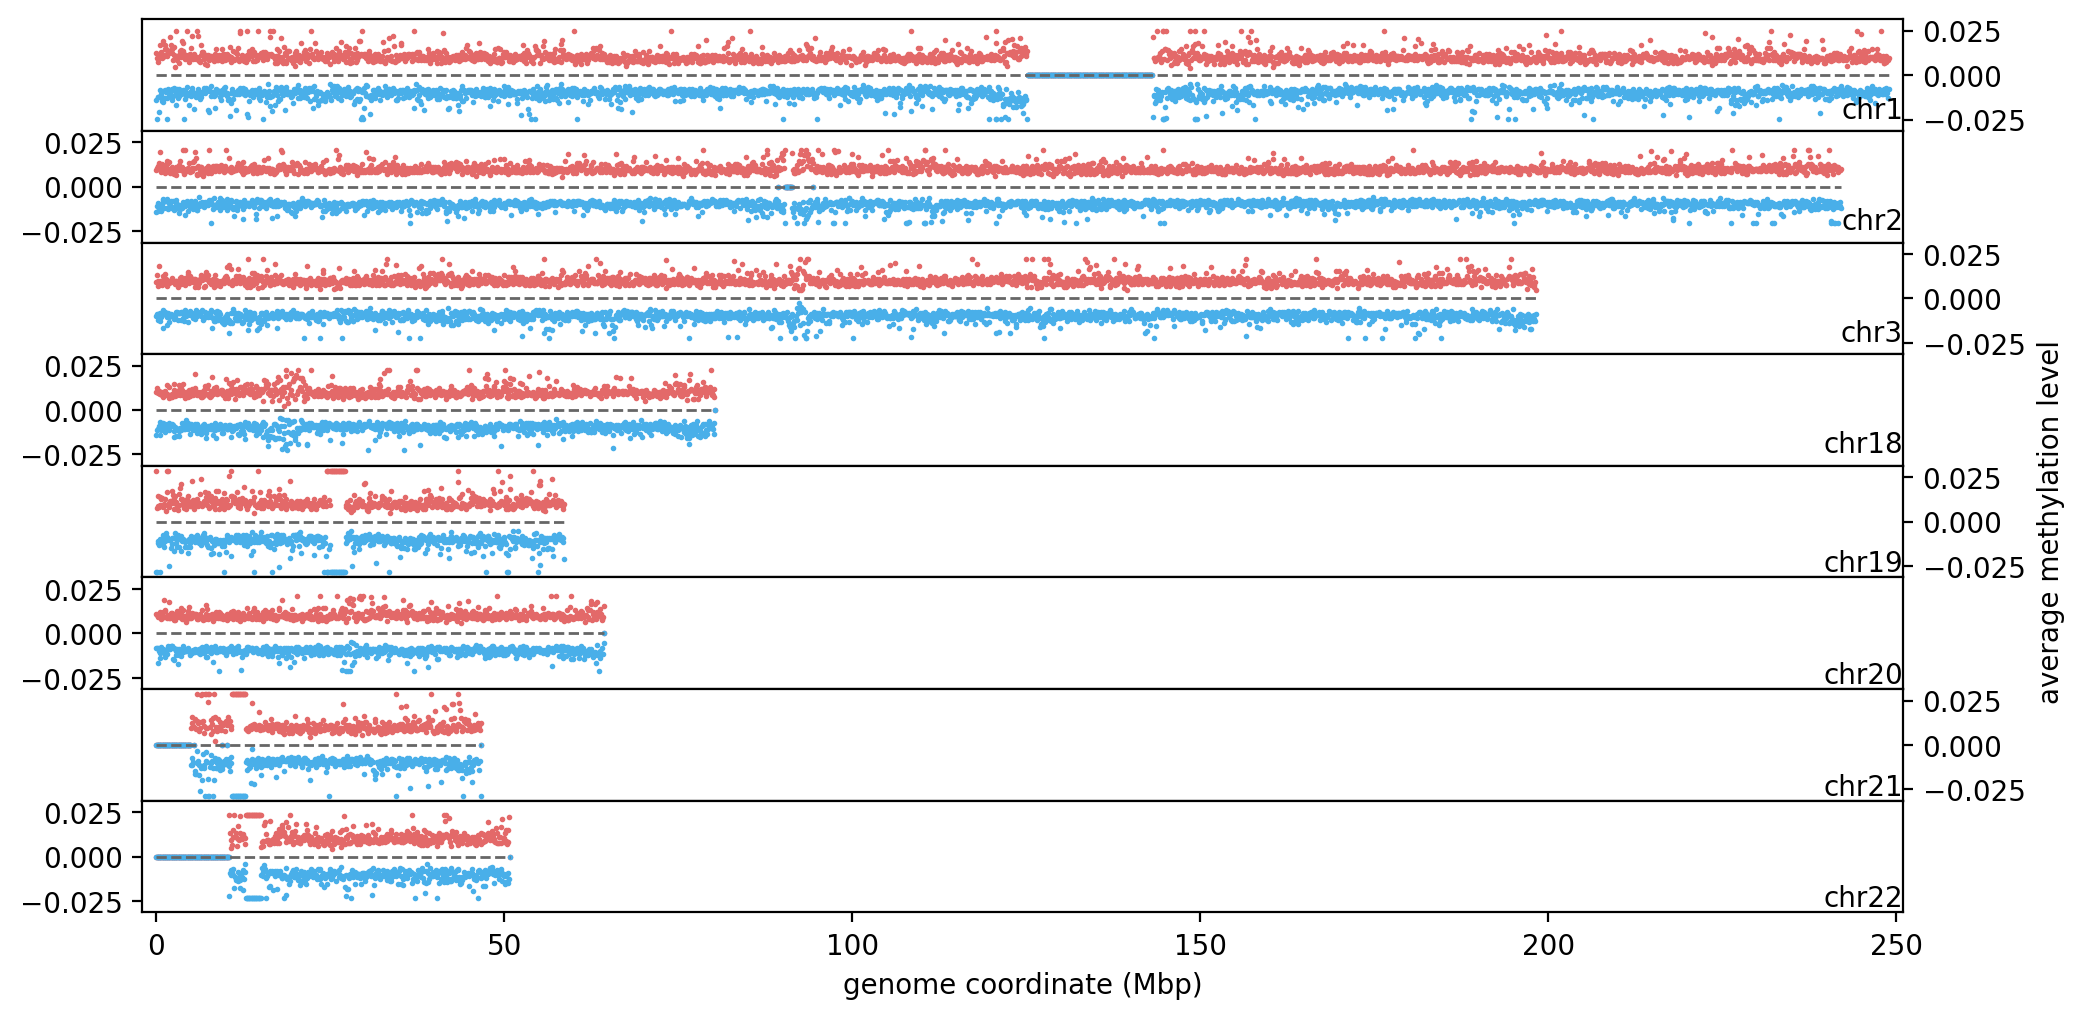

In [92]:
dp = 0 # only plot depth >= 1
chrs_plot = testchrs.split(',')
# chrs_plot = [chr for chr in chrs_valid if np.any(dict_bin_me['CG']['double'][chr] != 0)]

for cg in CONTEXTS:
    for strand in ['double', 'single']:
        if strand == 'double':
            me = dict_bin_me[cg][strand]
            maxbins = max([me[chr].shape[0] for chr in chrs_plot])
            add = int(cg!='CG')*0.2 + int(strand=='single')*0.1
            figheight = len(chrs_plot)*0.35 + 1
            figwidth = maxbins/250 + 1 + add
        else:
            me = dict_bin_me[cg]['W']
            me2 = dict_bin_me[cg]['C']
            maxbins = max([me[chr].shape[0] for chr in chrs_plot])
            figheight = len(chrs_plot)*0.6 + 1
            figwidth = maxbins/250 + 1.2 + add

    # for dp in range(DP_valid):
        fig, axs = plt.subplots(len(chrs_plot), 1, sharex=True, sharey=True, figsize=(figwidth, figheight))
        fig.subplots_adjust(hspace=0)
        
        plt.xlim(-2, prefixBpSize(np.array([maxbins * binSize]))[0]+2)
        for i, chr in enumerate(chrs_plot):
            if i == int(len(chrs_plot)/2):
                axs[i].set_ylabel('average methylation level')
            shape = np.shape(me[chr])
            x = np.arange(shape[0]) * binSize
            x, prefix = prefixBpSize(x)
            
            # trim outliers in non-CG plots
            y = me[chr][:,dp]
            if strand == 'single':
                y2 = me2[chr][:,dp]
            if cg != 'CG':
                y = np.fmin(np.nanquantile(y, 0.99), y)
                if strand == 'single':
                    y2 = np.fmin(np.nanquantile(y, 0.99), y2)
            
            if strand == 'double':
                axs[i].scatter(x, y, s=1, c=COLS_AREA[0])
            else:
                axs[i].scatter(x, y, s=1, c=COLS_AREA[1])
                axs[i].scatter(x, -y2, s=1, c=COLS_AREA[0])
                axs[i].hlines(0, 0, max(x), color='#666666', linestyles='dashed', linewidths=1)
            if i%2 == len(chrs_plot)%2: # ensure ylabel on the left always
                axs[i].yaxis.set_label_position('right')
                axs[i].yaxis.tick_right()
            axs[i].text(axs[i].get_xlim()[1], axs[i].get_ylim()[0], chr, horizontalalignment='right', verticalalignment='bottom')
        if prefix == '':
            axs[i].set_xlabel('genome coordinate')
        else:
            axs[i].set_xlabel(f'genome coordinate ({prefix})')
        # if strand == 'single': axs[i].legend()

        filename = f'img/meth-bin-{cg}-{strand}-dp{dp+1}'
        plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
        plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### binning depth

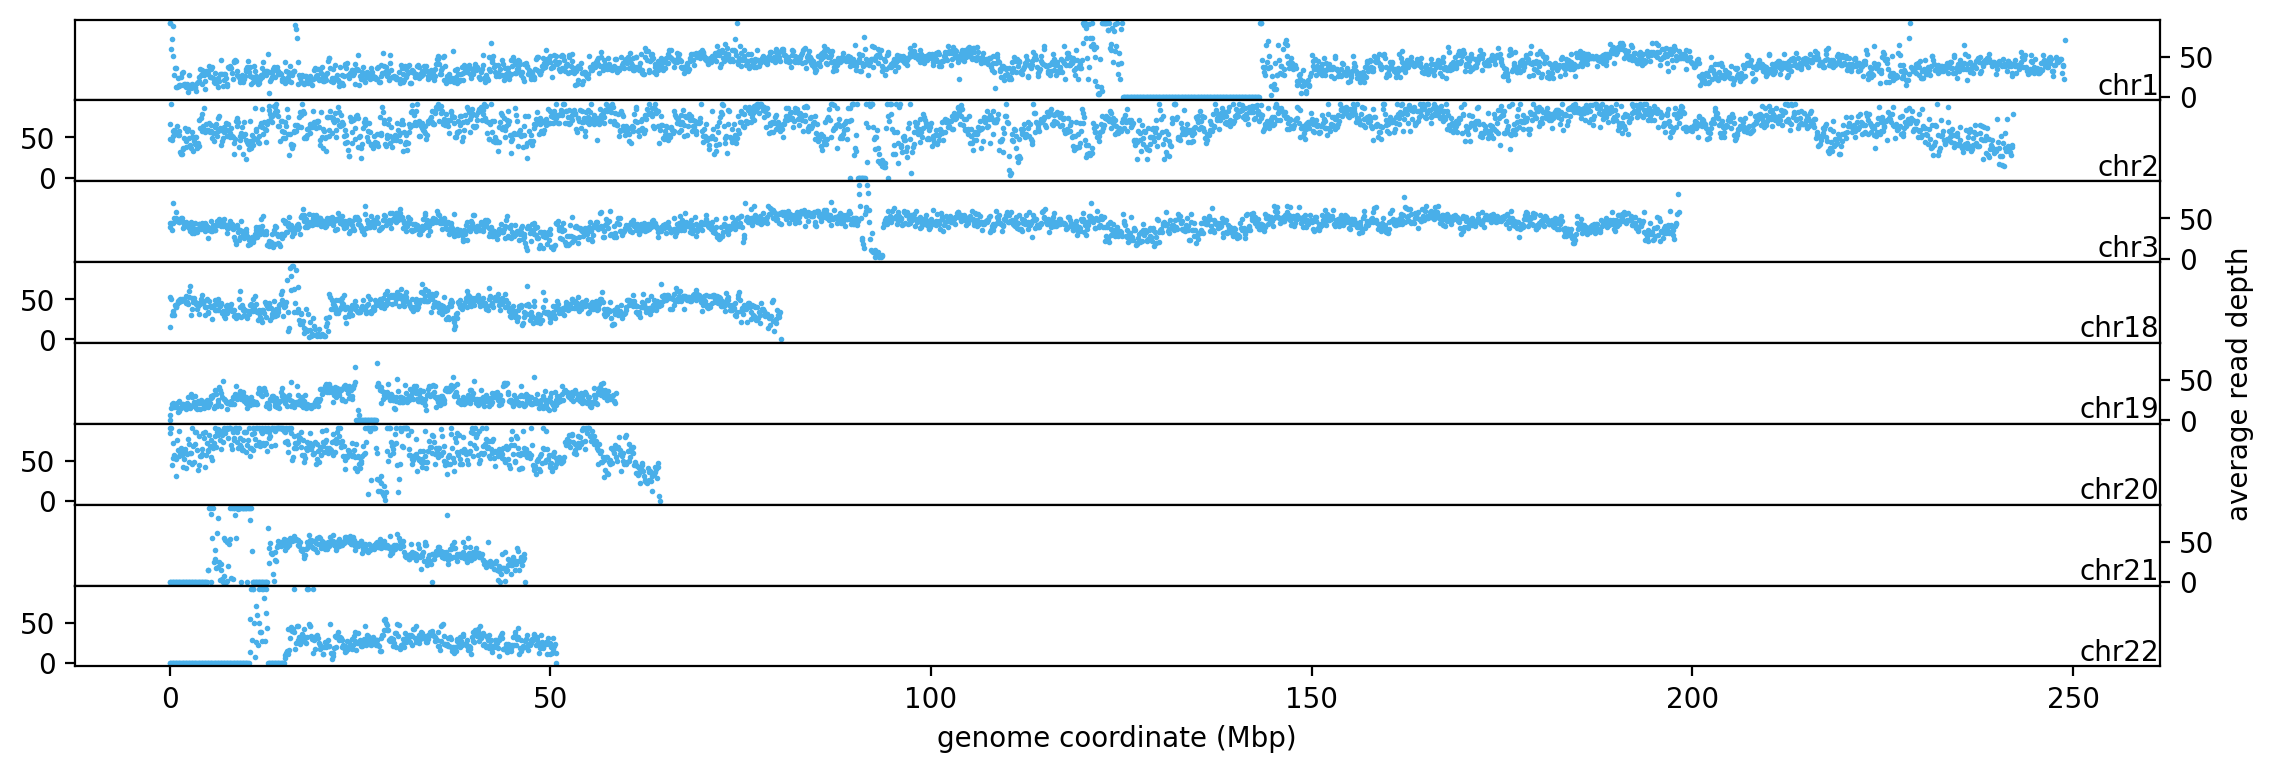

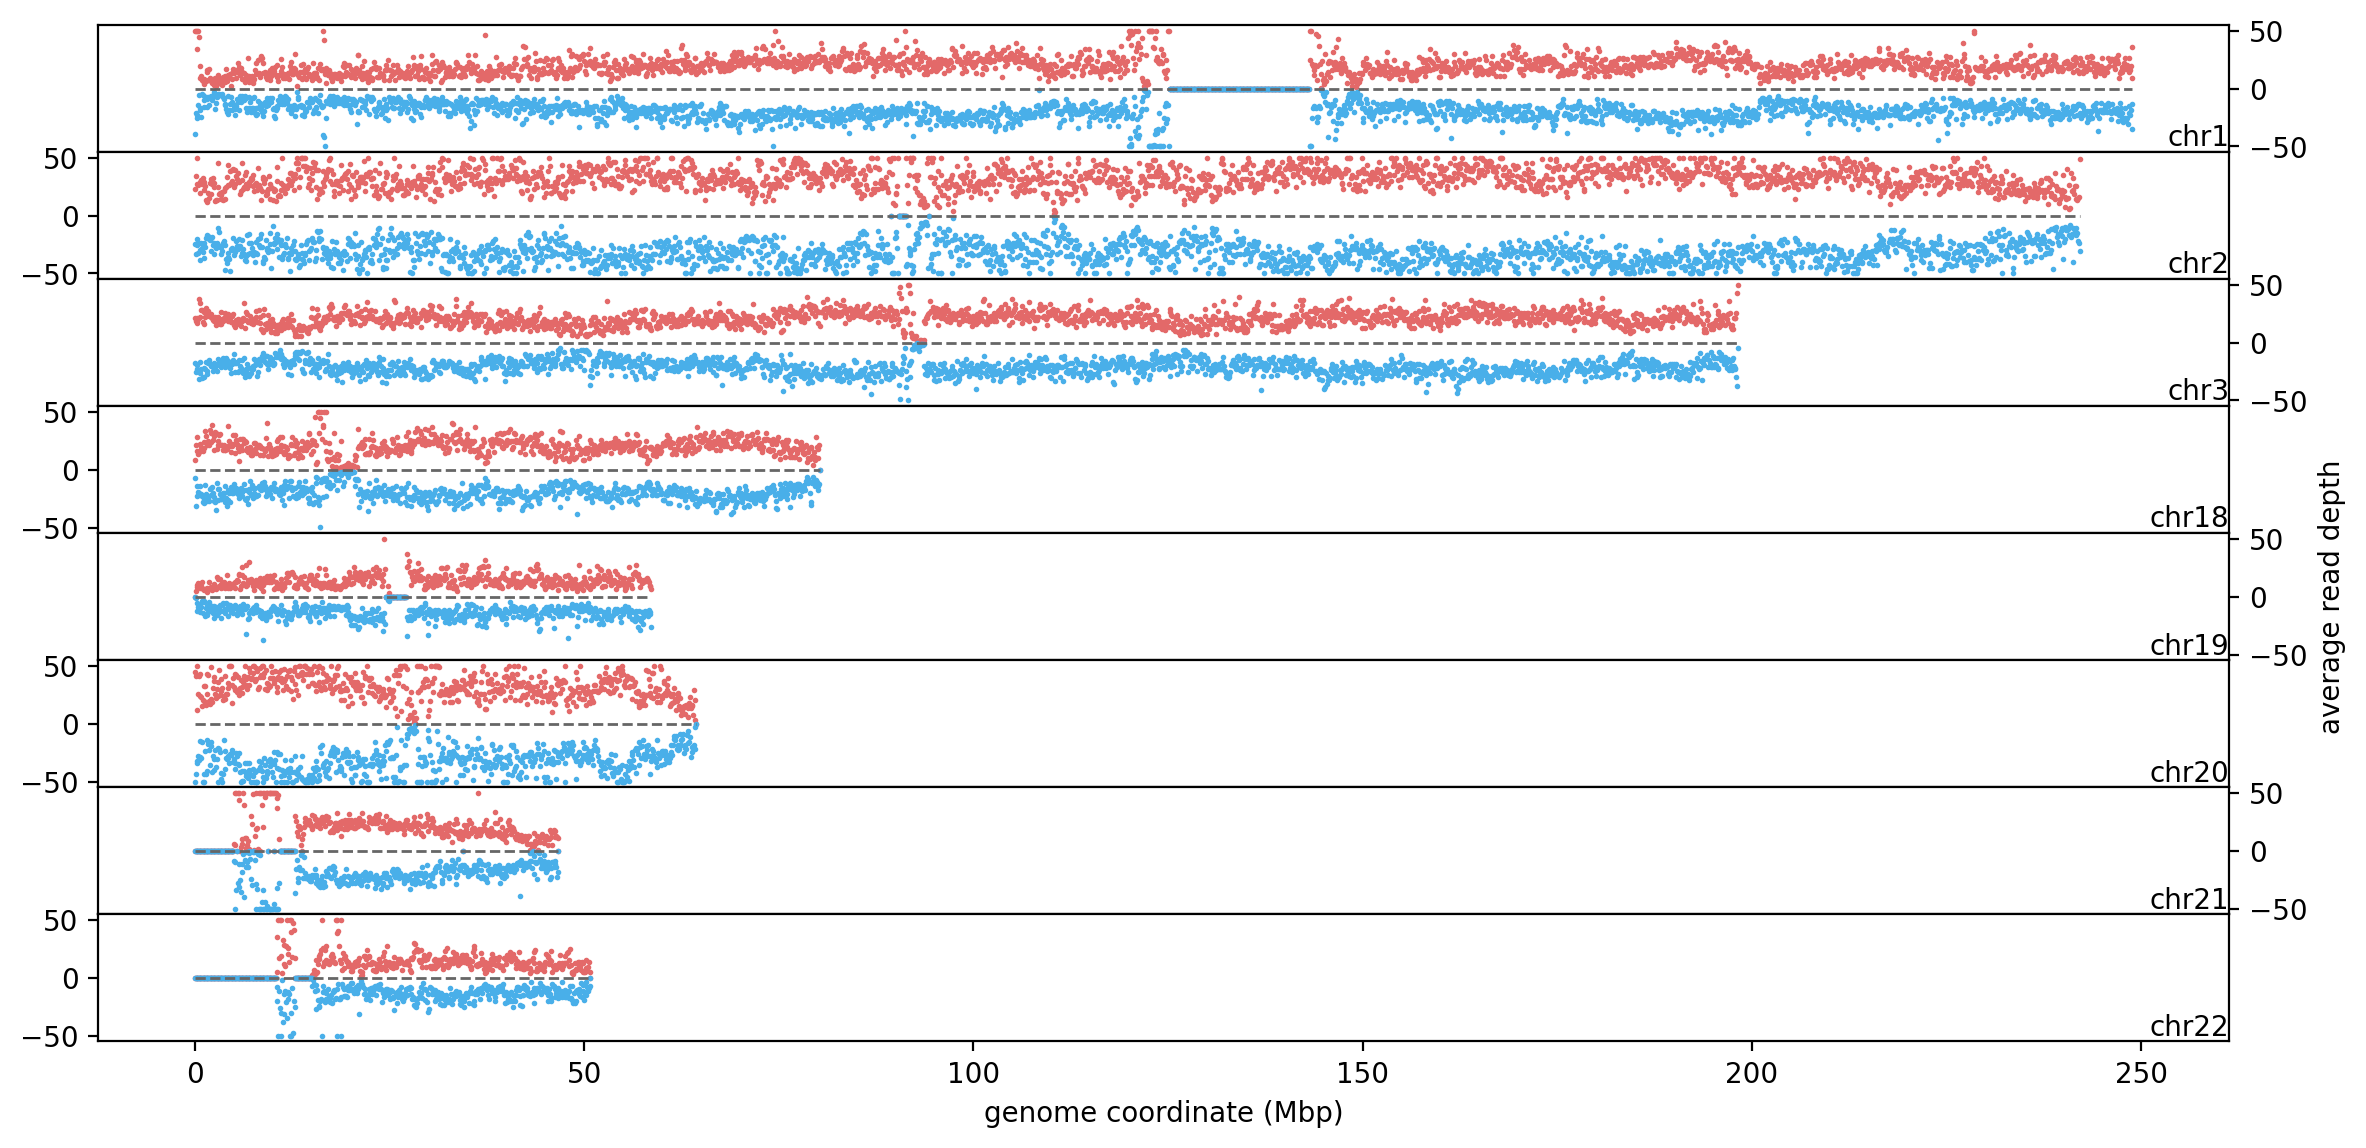

In [93]:
# chrs_plot = [chr for chr in chrs_valid if np.any(dict_bin_depth['double'][chr] != 0)]

for strand in ['double', 'single']:
    if strand == 'double':
        dep = dict_bin_depth[strand]
        maxbins = max([dep[chr].shape[0] for chr in chrs_plot])
        add = int(strand=='single')*0.1
        figheight = len(chrs_plot)*0.4 + 1
        figwidth = maxbins/200 + 1 + add
    else:
        dep = dict_bin_depth['W']
        dep2 = dict_bin_depth['C']
        maxbins = max([dep[chr].shape[0] for chr in chrs_plot])
        figheight = len(chrs_plot)*0.7 + 1
        figwidth = maxbins/200 + 1.3 + add

    fig, axs = plt.subplots(len(chrs_plot), 1, sharex=True, sharey=True, figsize=(figwidth, figheight))
    fig.subplots_adjust(hspace=0)

    # ylim
    if strand == 'double':
        maxdp = np.quantile(np.hstack([dep[chr] for chr in chrs_plot]), 0.98)
    else:
        maxdp = np.quantile(np.hstack([np.hstack([dep[chr], dep2[chr]]) for chr in chrs_plot]), 0.98)
    for i, chr in enumerate(chrs_plot):
        if i == int(len(chrs_plot)/2):
            axs[i].set_ylabel('average read depth')
        shape = np.shape(dep[chr])
        x0 = np.arange(shape[0]) * binSize
        x, prefix = prefixBpSize(x0)
        
        # trim outliers
        y = dep[chr]
        y = np.fmin(maxdp, y)
        if strand == 'single':
            y2 = dep2[chr]
            y2 = np.fmin(maxdp, y2)
        
        if strand == 'double':
            axs[i].scatter(x, y, s=1, c=COLS_AREA[0])
        else:
            axs[i].scatter(x, y, s=1, c=COLS_AREA[1])
            axs[i].scatter(x, -y2, s=1, c=COLS_AREA[0])
            axs[i].hlines(0, 0, max(x), color='#666666', linestyles='dashed', linewidths=1)
        if i%2 == len(chrs_plot)%2: # ensure ylabel on the left always
            axs[i].yaxis.set_label_position('right')
            axs[i].yaxis.tick_right()
        axs[i].text(axs[i].get_xlim()[1], axs[i].get_ylim()[0], chr, horizontalalignment='right', verticalalignment='bottom')
    if prefix == '':
        axs[i].set_xlabel('genome coordinate')
    else:
        axs[i].set_xlabel(f'genome coordinate ({prefix})')

    filename = f'img/depth-bin-{strand}'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Meth bias

### DNAme (DP>=k) vs depth

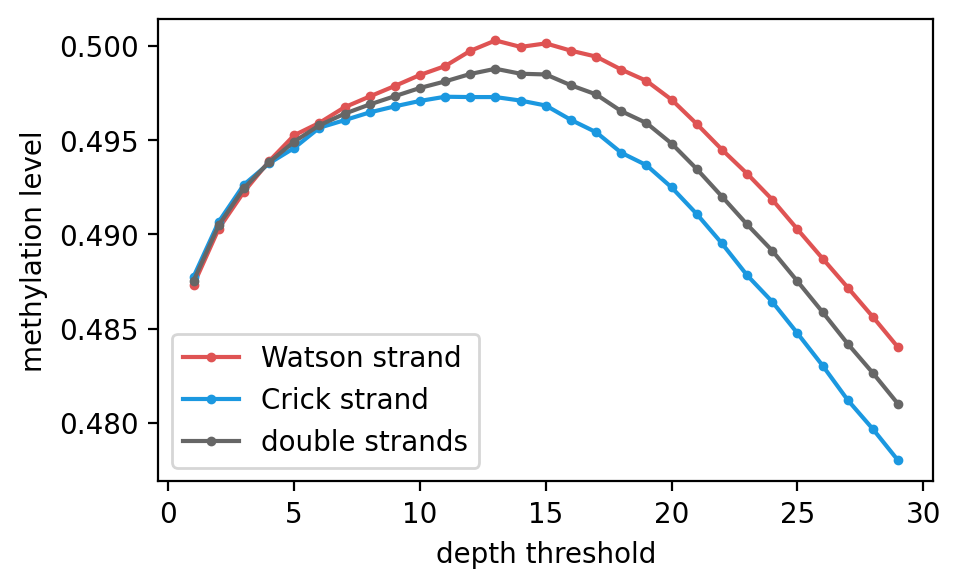

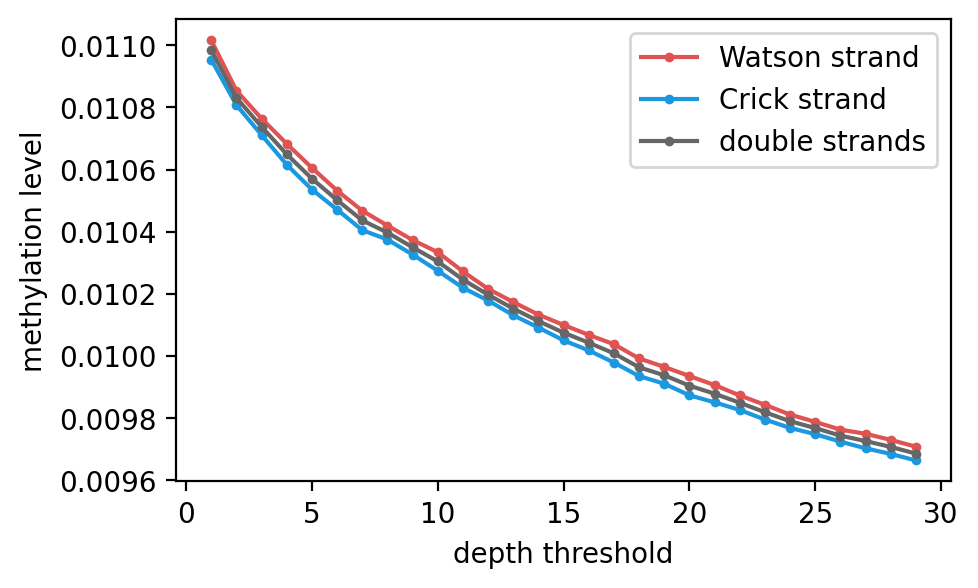

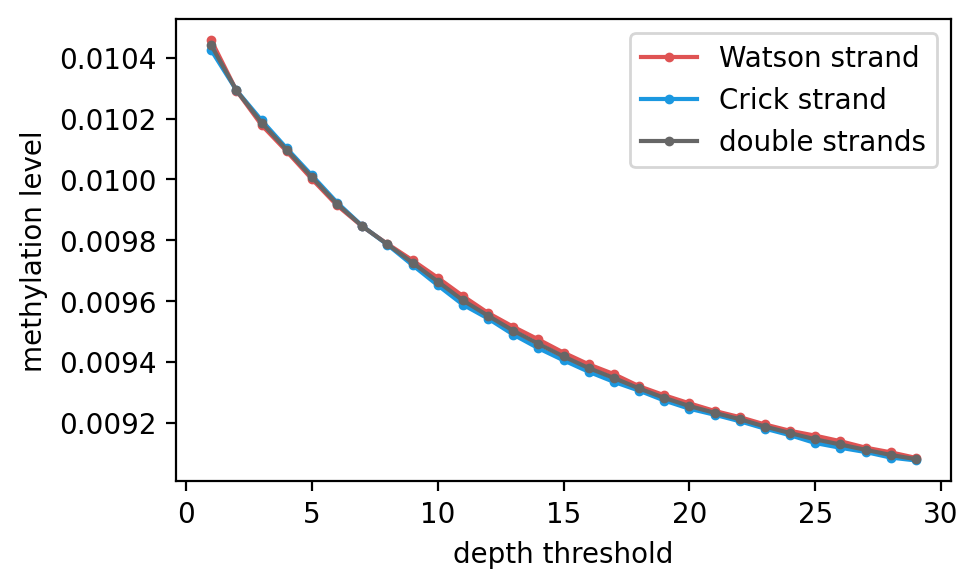

In [94]:
for cg in CONTEXTS:
    fig, ax = plt.subplots(figsize=(5, 3))
    x = np.arange(DP) + 1
    yd = nandivide(dict_genome_me[cg]['double'][:DP], dict_genome_covnC[cg]['double'][:DP])
    yw = nandivide(dict_genome_me[cg]['W'][:DP], dict_genome_covnC[cg]['W'][:DP])
    yc = nandivide(dict_genome_me[cg]['C'][:DP], dict_genome_covnC[cg]['C'][:DP])

    ax.plot(x, yw, '.-', c=COLS[1], markersize=5, label='Watson strand')
    ax.plot(x, yc, '.-', c=COLS[0], markersize=5, label='Crick strand')
    ax.plot(x, yd, '.-', c=COL_gray, markersize=5, label='double strands')
    ax.legend()
    ax.set_xlabel('depth threshold')
    ax.set_ylabel('methylation level')
    filename = f'img/meth-{cg}-vs-dp-threshold'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### DNAme (DP=k) vs depth

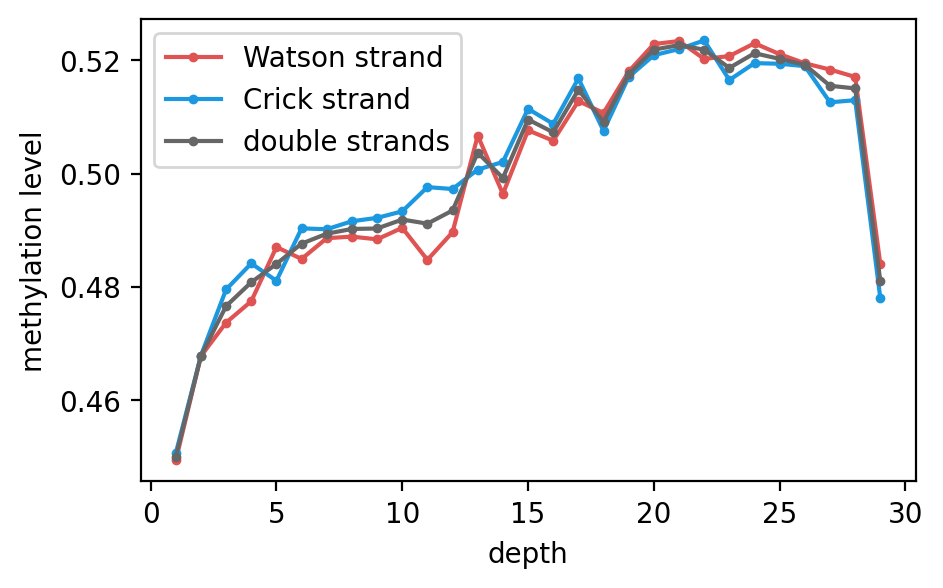

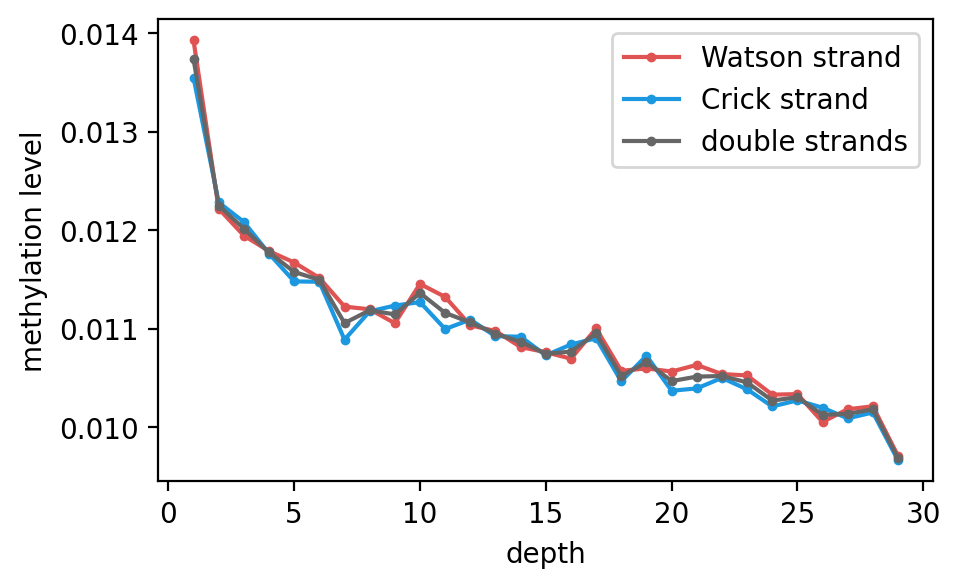

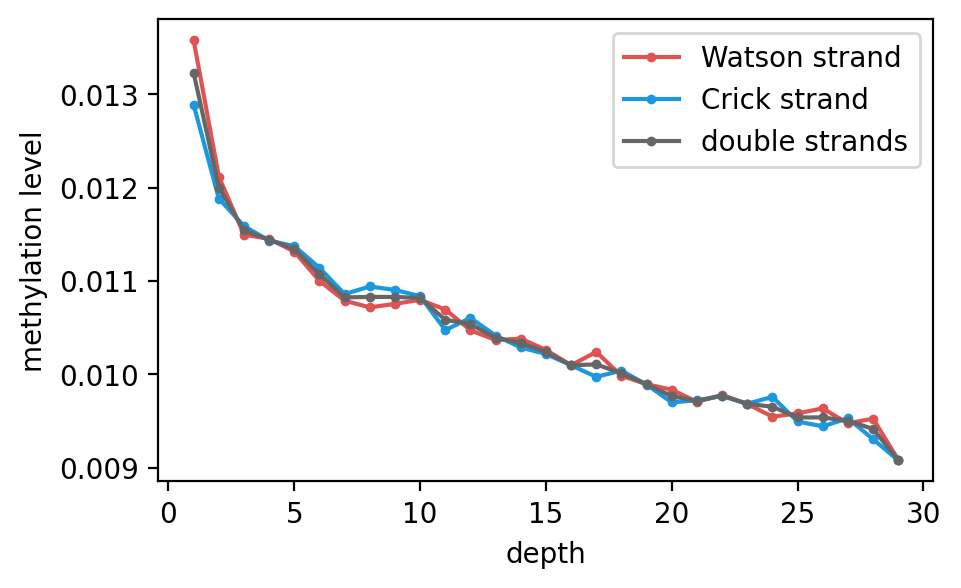

In [95]:
for cg in CONTEXTS:
    fig, ax = plt.subplots(figsize=(5, 3))
    x = np.arange(DP) + 1
    yd = nandivide(depthDiff(dict_genome_me[cg]['double'][:DP]), 
                   depthDiff(dict_genome_covnC[cg]['double'][:DP])
                   )
    yw = nandivide(depthDiff(dict_genome_me[cg]['W'][:DP]), 
                   depthDiff(dict_genome_covnC[cg]['W'][:DP])
                   )
    yc = nandivide(depthDiff(dict_genome_me[cg]['C'][:DP]), 
                   depthDiff(dict_genome_covnC[cg]['C'][:DP])
                   )

    ax.plot(x, yw, '.-', c=COLS[1], markersize=5, label='Watson strand')
    ax.plot(x, yc, '.-', c=COLS[0], markersize=5, label='Crick strand')
    ax.plot(x, yd, '.-', c=COL_gray, markersize=5, label='double strands')
    ax.legend()
    ax.set_xlabel('depth')
    ax.set_ylabel('methylation level')
    filename = f'img/meth-{cg}-at-dp-k'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### meth vs missing rate

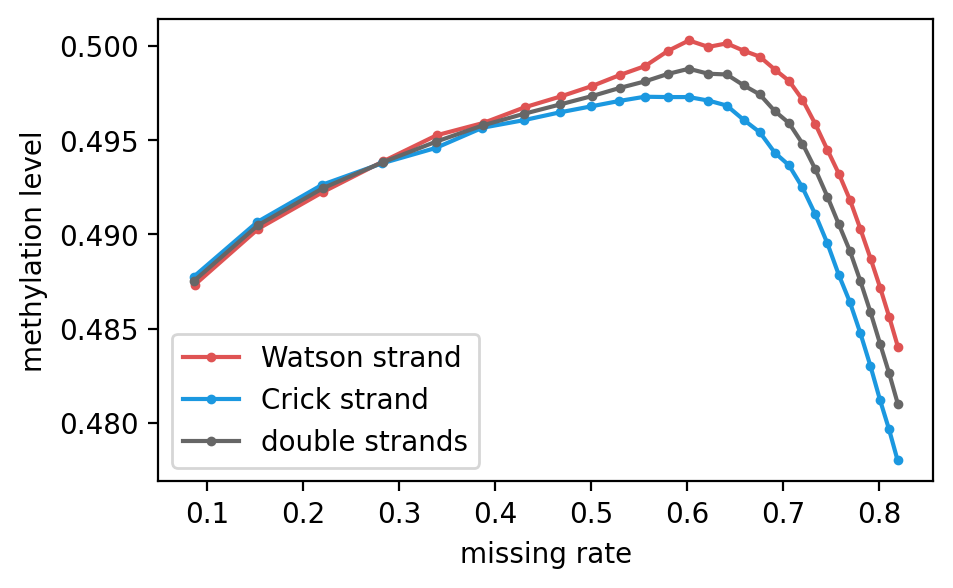

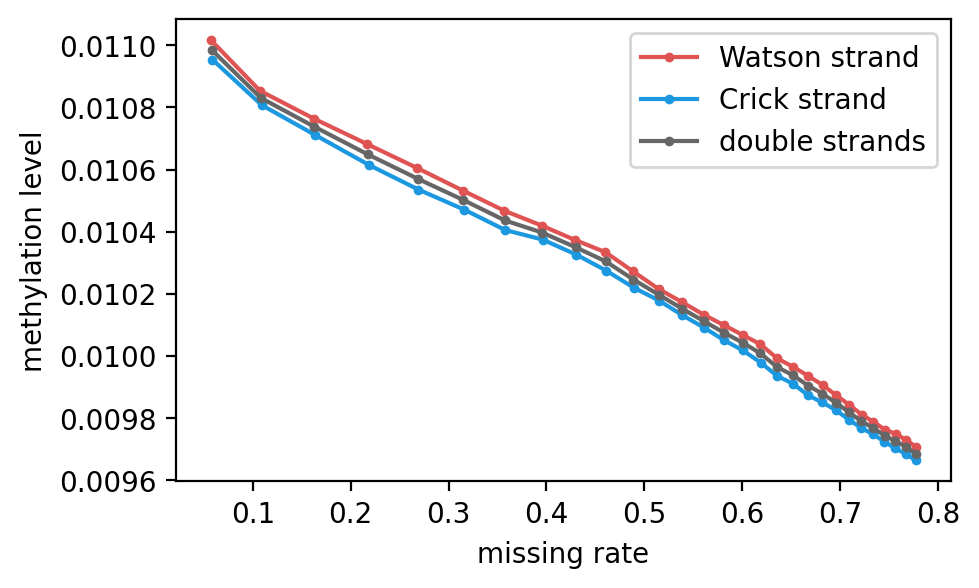

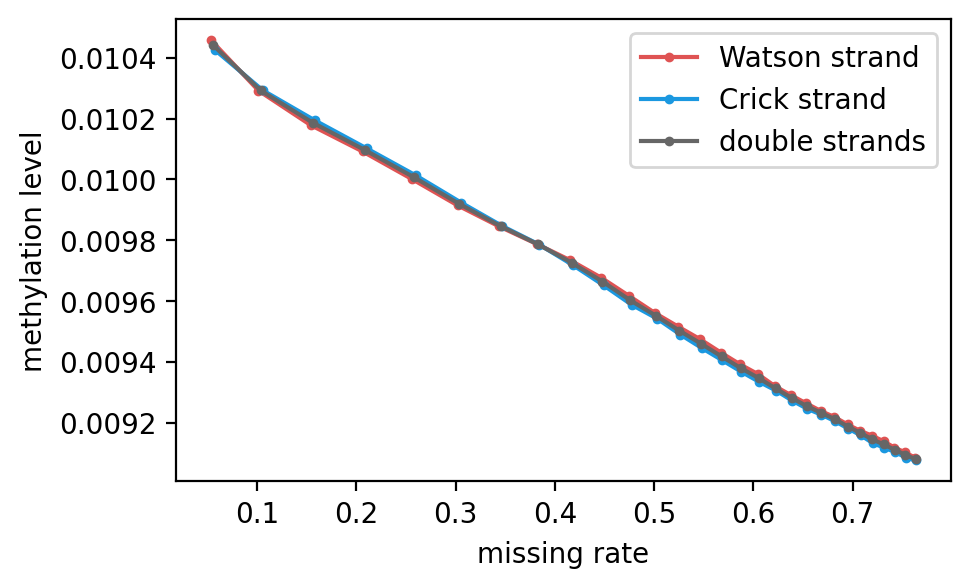

In [96]:
for cg in CONTEXTS:
    fig, ax = plt.subplots(figsize=(5, 3))
    # dp = np.arange(DP) + 1
    xd = 1 - dict_genome_covnC[cg]['double'][:DP] / dict_Cs[cg]['double']
    yd = nandivide(dict_genome_me[cg]['double'][:DP], dict_genome_covnC[cg]['double'][:DP])
    xw = 1 - dict_genome_covnC[cg]['W'][:DP] / dict_Cs[cg]['W']
    yw = nandivide(dict_genome_me[cg]['W'][:DP], dict_genome_covnC[cg]['W'][:DP])
    xc = 1 - dict_genome_covnC[cg]['C'][:DP] / dict_Cs[cg]['C']
    yc = nandivide(dict_genome_me[cg]['C'][:DP], dict_genome_covnC[cg]['C'][:DP])

    ax.plot(xw, yw, '.-', c=COLS[1], markersize=5, label='Watson strand')
    ax.plot(xc, yc, '.-', c=COLS[0], markersize=5, label='Crick strand')
    ax.plot(xd, yd, '.-', c=COL_gray, markersize=5, label='double strands')
    ax.legend()
    ax.set_xlabel('missing rate')
    ax.set_ylabel('methylation level')
    filename = f'img/meth-{cg}-vs-missing-rate'
    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### depth vs cytosine density

In [ ]:
for cg in CONTEXTS:
    for strand in STRANDS:
        density = []
        depth = []
        for key, value in dict_binning.items():
            value = dict_binning[key]
            dp = {
                'double': value.dp, 'W': value.dpW, 'C': value.dpC
            }
            nC = {
                'CG': {'double': value.nCG, 'W': value.nCGW, 'C': value.nCGC},
                'CHG': {'double': value.nCHG, 'W': value.nCHGW, 'C': value.nCHGC},
                'CHH': {'double': value.nCHH, 'W': value.nCHHW, 'C': value.nCHHC},
            }
            if value.length >= 100:
                den = nC[cg][strand] / value.length
                density.append(den)
                depth.append(dp[strand] / value.length)
        density = np.asarray(density) * 1000 # density per 1000 bp
        depth = np.asarray(depth)

        # sampling 3000 points
        if len(depth) > 3000:
            i = gen.choice(len(depth), size=3000, replace=False)
            density = density[i]
            depth = depth[i]

        ## depth vs density
        xy = np.vstack([density, depth])
        d = scipy.stats.gaussian_kde(xy)(xy)
        idx = d.argsort()
        x, y, d = density[idx], depth[idx], d[idx]
        filename = f'img/depth-vs-{cg}-density-of-{strand}-strand'

        fig, ax = plt.subplots(figsize=(5, 4))
        plt.scatter(x, y, c=d, s=1, cmap='Spectral_r')
        plt.ylim(0, np.quantile(y, 0.995))
        plt.xlim(np.min(density)-1, np.quantile(x, 0.995))

        plt.colorbar()
        plt.xlabel('cytosine density')
        plt.ylabel('mean depth')
        plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
        plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')


### meth and cov rate vs cytosine density

In [ ]:
for cg in CONTEXTS:
    for strand in STRANDS:
        for dp in range(10):
            density = []
            meth = []
            density2 = [] # for cov 
            covrate = []
            for key, value in dict_binning.items():
                value = dict_binning[key]
                me = {
                    'CG': {'double': value.meCG[dp], 'W': value.meCGW[dp], 'C': value.meCGC[dp]},
                    'CHG': {'double': value.meCHG[dp], 'W': value.meCHGW[dp], 'C': value.meCHGC[dp]},
                    'CHH': {'double': value.meCHH[dp], 'W': value.meCHHW[dp], 'C': value.meCHHC[dp]}
                }
                nC = {
                    'CG': {'double': value.nCG, 'W': value.nCGW, 'C': value.nCGC},
                    'CHG': {'double': value.nCHG, 'W': value.nCHGW, 'C': value.nCHGC},
                    'CHH': {'double': value.nCHH, 'W': value.nCHHW, 'C': value.nCHHC},
                }
                covnC = {
                    'CG': {'double': value.covnCG[dp], 'W': value.covnCGW[dp], 'C': value.covnCGC[dp]},
                    'CHG': {'double': value.covnCHG[dp], 'W': value.covnCHGW[dp], 'C': value.covnCHGC[dp]},
                    'CHH': {'double': value.covnCHH[dp], 'W': value.covnCHHW[dp], 'C': value.covnCHHC[dp]},
                }
                if value.length >= 100 and value.covnCGW[dp] >= 10 and value.covnCGC[dp] >= 10 and value.covnCHGW[dp] >= 20 and value.covnCHGC[dp] >= 20 and value.covnCHHW[dp] >= 30 and value.covnCHHC[dp] >= 30:
                    density.append(nC[cg][strand] / value.length)
                    meth.append(me[cg][strand] / covnC[cg][strand])
                if value.length >= 200 and value.nCG >= 10 and value.nCHG >= 20 and value.nCHH >= 30:
                    density2.append(nC[cg][strand] / value.length)
                    covrate.append(covnC[cg][strand] / nC[cg][strand])

            density = np.asarray(density) * 1000 # density per 1000 bp
            meth = np.asarray(meth) # meth
            density2 = np.asarray(density2) * 1000
            covrate = np.asarray(covrate) # cov rate
            # sampling 2000 points
            if len(meth) > 3000:
                i = gen.choice(len(meth), size=3000, replace=False)
                density = density[i]
                meth = meth[i]

            ## meth vs density
            xy = np.vstack([density, meth])
            d = scipy.stats.gaussian_kde(xy)(xy)
            # Sort the points by density
            # so that the densest points are plotted at last
            idx = d.argsort()
            x, y, d = density[idx], meth[idx], d[idx]
            filename = f'img/meth-vs-{cg}-density-of-{strand}-strand-dp-ge{dp+1}'

            fig, ax = plt.subplots(figsize=(5, 4))
            plt.scatter(x, y, c=d, s=1, cmap='Spectral_r')
            # plt.ylim(0, 1)
            plt.xlim(np.min(density)-1, np.max(density)+1)
            plt.colorbar()
            plt.xlabel('cytosine density')
            plt.ylabel('methylation level')
            plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
            plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

            ## cov vs density
            if len(covrate) > 3000:
                i = gen.choice(len(covrate), size=3000, replace=False)
                density2 = density2[i]
                covrate = covrate[i]
            xy = np.vstack([density2, covrate])
            d = scipy.stats.gaussian_kde(xy)(xy)
            idx = d.argsort()
            x, y, d = density2[idx], covrate[idx], d[idx]
            filename = f'img/covrate-vs-{cg}-density-of-{strand}-strand-dp-ge{dp+1}'

            fig, ax = plt.subplots(figsize=(5, 4))
            plt.scatter(x, y, c=d, s=1, cmap='Spectral_r')
            # plt.ylim(0, 1)
            plt.xlim(np.min(density2)-1, np.max(density2)+1)
            plt.colorbar()
            plt.xlabel('cytosine density')
            plt.ylabel('cytosine coverage rate')
            plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
            plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')


### dp distributions of low/high meth CGs

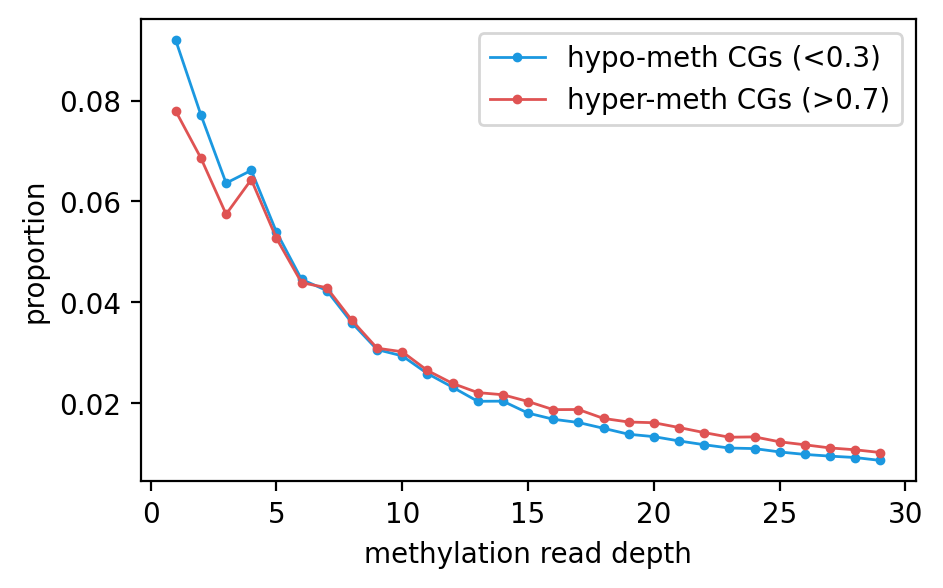

In [99]:
x = 0
y = 0
y2 = 0
ym = 0 # mean
nCGLowMeth = 0 
nCGHighMeth = 0

for key, value in dict_binning.items():
    # if chr != key[0]: continue
    value = dict_binning[key]
    nCGLowMeth += value.nCGLowMeth
    nCGHighMeth += value.nCGHighMeth

x = np.arange(DP) + 1
y = nCGLowMeth/np.sum(nCGLowMeth)
y2 = nCGHighMeth/np.sum(nCGHighMeth)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, y[:DP], '.-', c=COLS[0], linewidth=1, markersize=5, label='hypo-meth CGs (<0.3)')
ax.plot(x, y2[:DP], '.-', c=COLS[1], linewidth=1, markersize=5, label='hyper-meth CGs (>0.7)')
ax.legend()
filename = f'img/depth-of-low-high-meth-CGs'
plt.xlabel('methylation read depth')
plt.ylabel('proportion')
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Genome coverage

### CG coverage vs depth

add number covered Cytosines at the right 

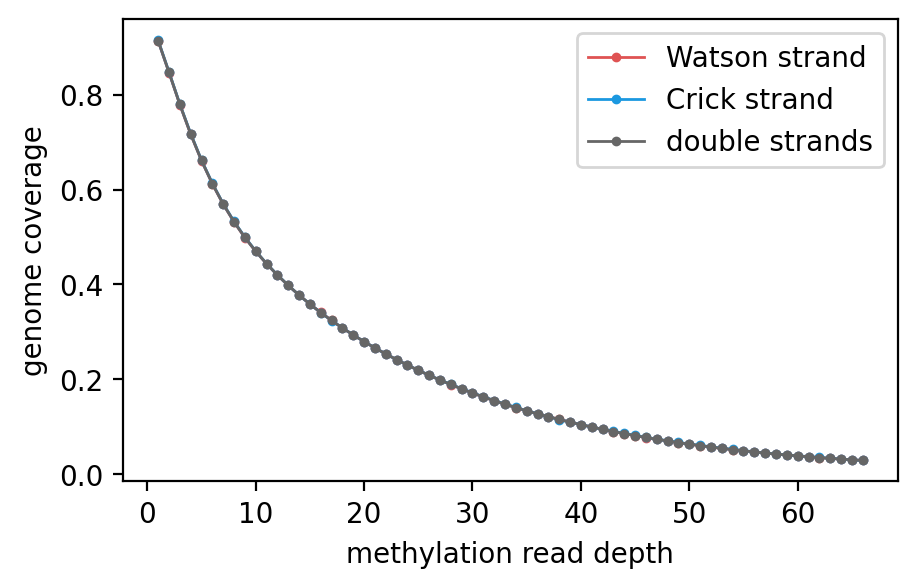

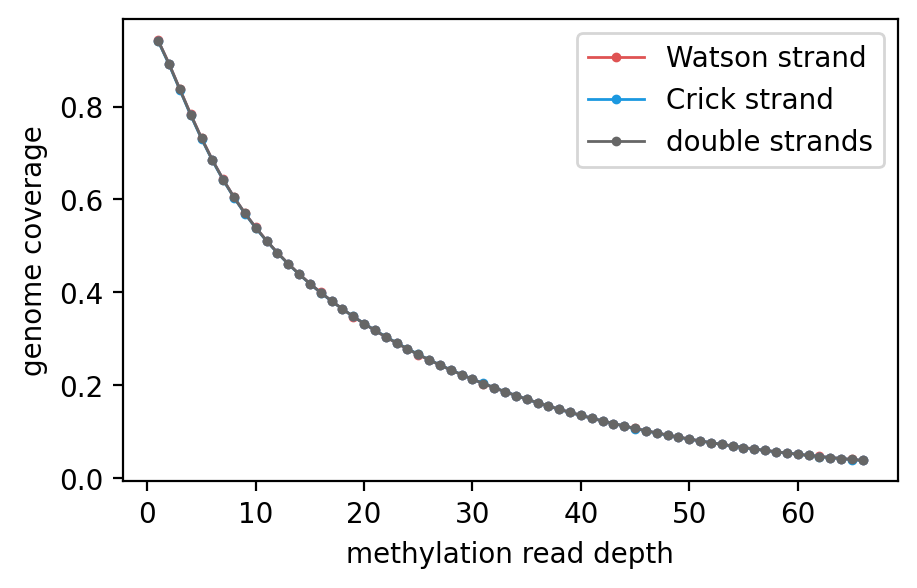

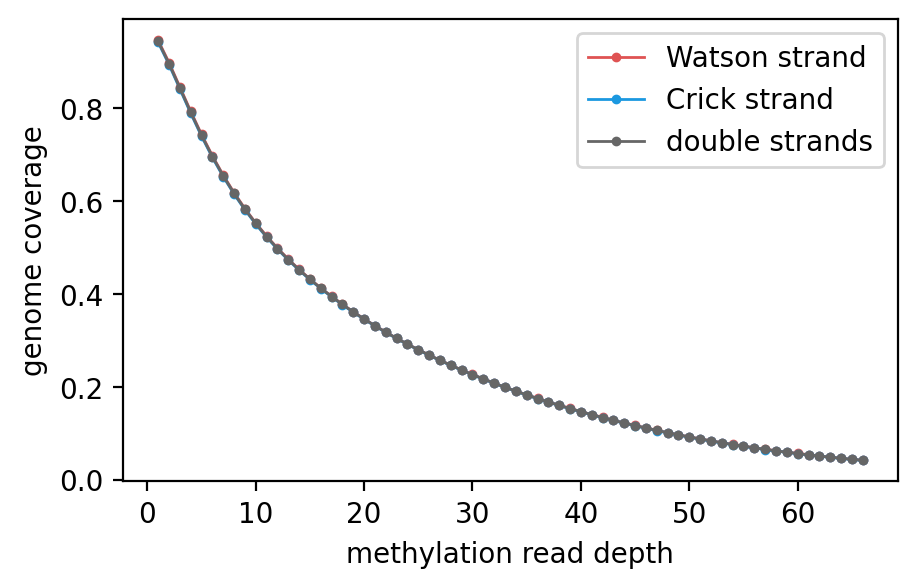

In [100]:
for cg in CONTEXTS:

    x = np.arange(DP_xdepth) + 1
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, dict_genome_covnC[cg]['W'][:DP_xdepth]/dict_Cs[cg]['W'], '.-', c=COLS[1], alpha=1, linewidth=1, markersize=5, label='Watson strand')
    ax.plot(x, dict_genome_covnC[cg]['C'][:DP_xdepth]/dict_Cs[cg]['C'], '.-', c=COLS[0], alpha=1, linewidth=1, markersize=5, label='Crick strand')
    ax.plot(x, dict_genome_covnC[cg]['double'][:DP_xdepth]/dict_Cs[cg]['double'], '.-', c=COL_gray, linewidth=1, markersize=5, label='double strands')
    ax.legend()
    plt.xlabel('methylation read depth')
    plt.ylabel('genome coverage')

    filename = f'img/genome-{cg}-coverage-vs-depth'

    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### depth distribution of Cytosines

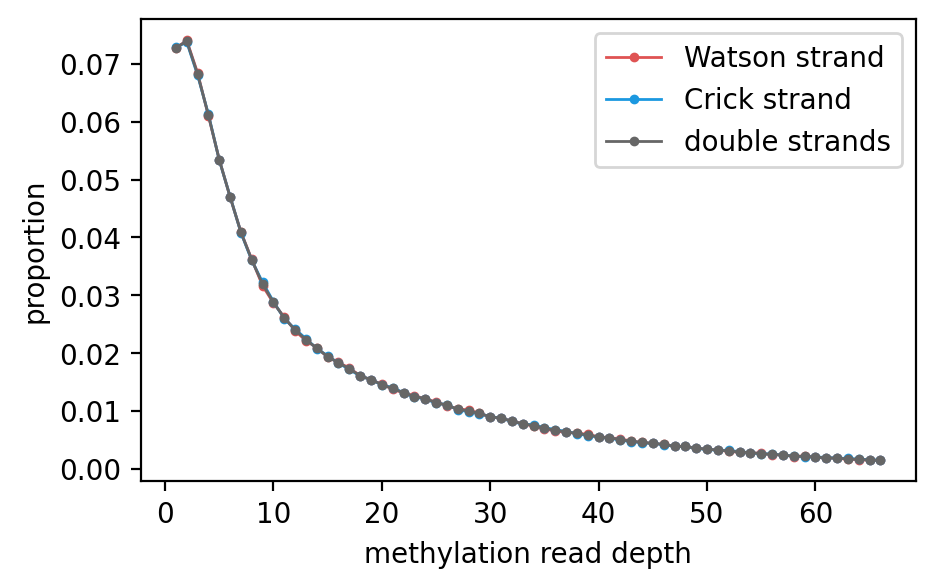

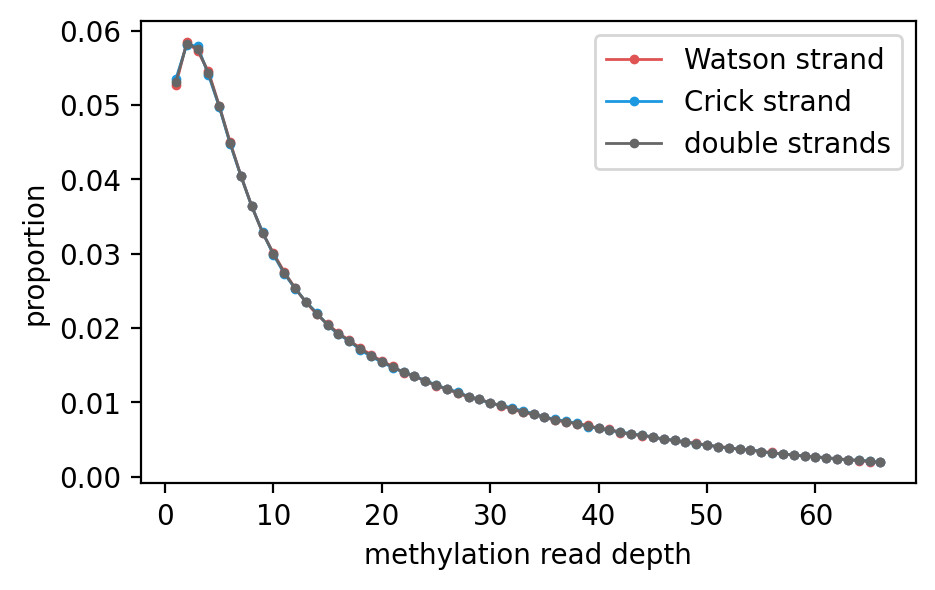

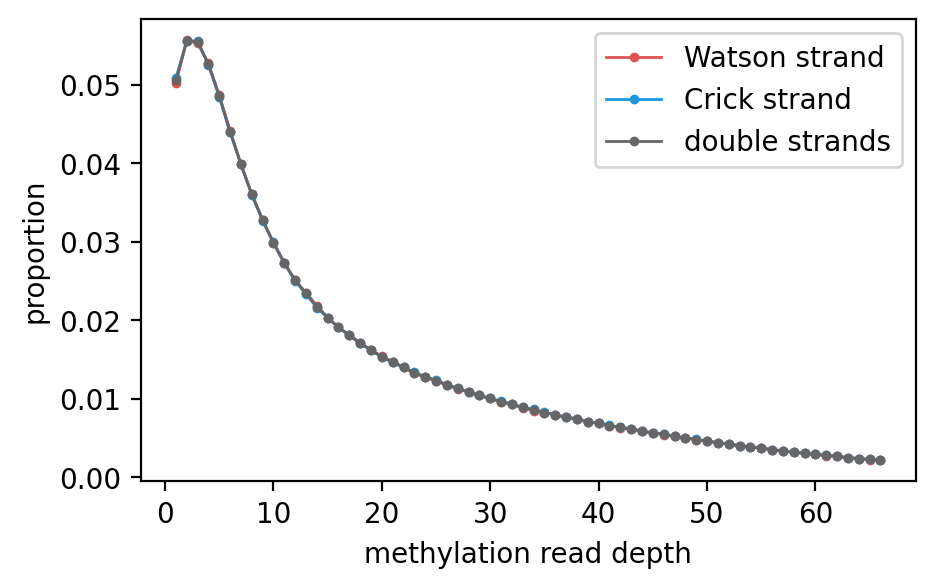

In [101]:
for cg in CONTEXTS:

    x = np.arange(DP_xdepth) + 1
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, depthDiff(dict_genome_covnC[cg]['W'])[:DP_xdepth] / dict_genome_covnC[cg]['W'][0], '.-', c=COLS[1], alpha=1, linewidth=1, markersize=5, label='Watson strand')
    ax.plot(x, depthDiff(dict_genome_covnC[cg]['C'])[:DP_xdepth] / dict_genome_covnC[cg]['C'][0], '.-', c=COLS[0], alpha=1, linewidth=1, markersize=5, label='Crick strand')
    ax.plot(x, depthDiff(dict_genome_covnC[cg]['double'])[:DP_xdepth] / dict_genome_covnC[cg]['double'][0], '.-', c=COL_gray, linewidth=1, markersize=5, label='double strands')
    ax.legend()
    plt.xlabel('methylation read depth')
    plt.ylabel('proportion')

    filename = f'img/genome-{cg}-depth-distribution'

    plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### whole-genome coverage vs depth

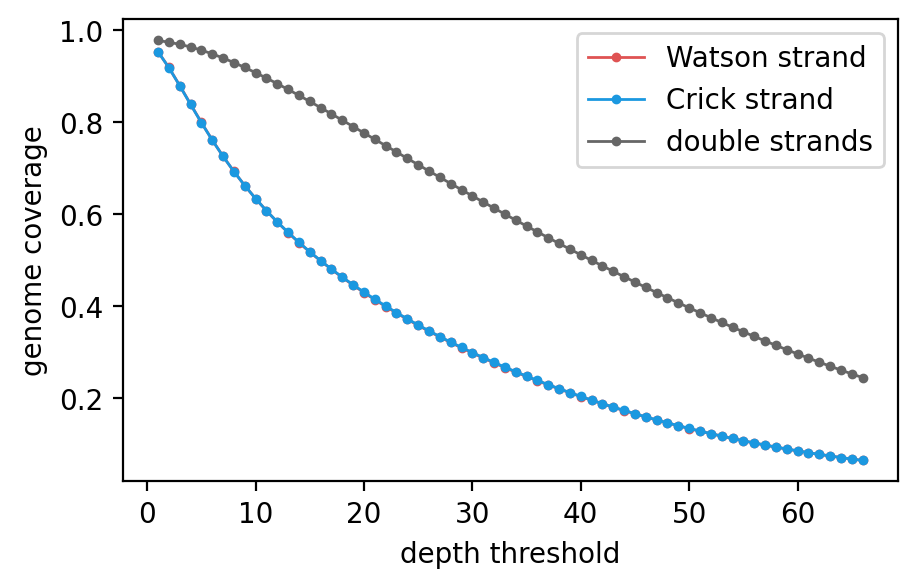

In [102]:
x = np.arange(DP_xdepth) + 1
L = np.sum(length)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, genome_covW[:DP_xdepth]/L, '.-', c=COLS[1], alpha=1, linewidth=1, markersize=5, label='Watson strand')
ax.plot(x, genome_covC[:DP_xdepth]/L, '.-', c=COLS[0], alpha=1, linewidth=1, markersize=5, label='Crick strand')
ax.plot(x, genome_cov[:DP_xdepth]/L, '.-', c=COL_gray, linewidth=1, markersize=5, label='double strands')
ax.legend()
plt.xlabel('depth threshold')
plt.ylabel('genome coverage')

filename = f'img/whole-genome-coverage-vs-depth'

plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### depth distribution of whole genome

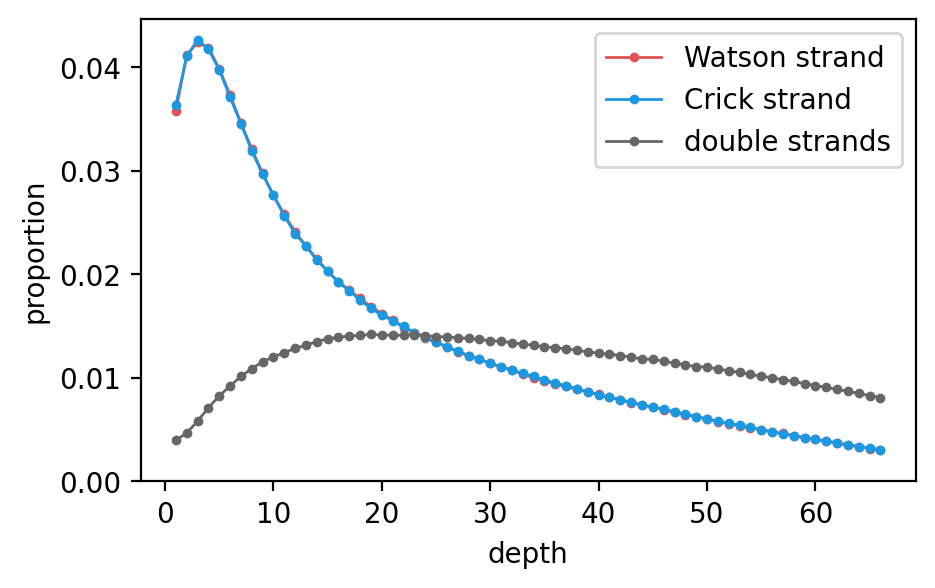

In [103]:
x = np.arange(DP_xdepth) + 1
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, depthDiff(genome_covW)[:DP_xdepth]/genome_covW[0], '.-', c=COLS[1], alpha=1, linewidth=1, markersize=5, label='Watson strand')
ax.plot(x, depthDiff(genome_covC)[:DP_xdepth]/genome_covC[0], '.-', c=COLS[0], alpha=1, linewidth=1, markersize=5, label='Crick strand')
ax.plot(x, depthDiff(genome_cov)[:DP_xdepth]/genome_cov[0], '.-', c=COL_gray, linewidth=1, markersize=5, label='double strands')
ax.legend()
plt.ylim(bottom=0)
plt.xlabel('depth')
plt.ylabel('proportion')

filename = f'img/whole-genome-depth-distribution'

plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### depth of two strands

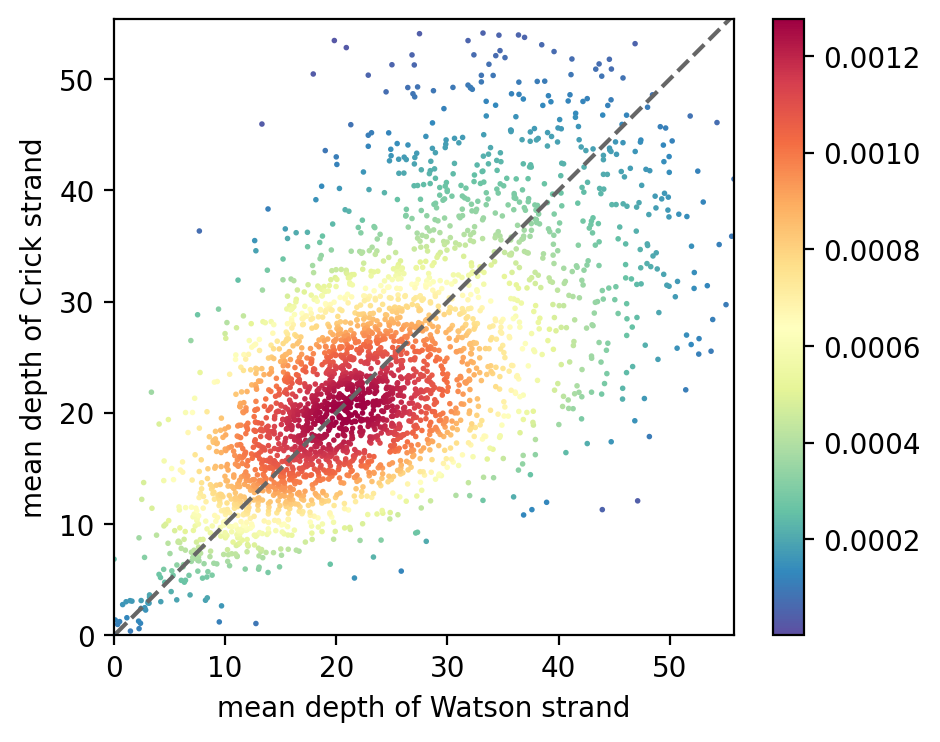

In [104]:
depthW = []
depthC = []
for key, value in dict_binning.items():
    value = dict_binning[key]
    if value.length >= 20:
        depthW.append(value.dpW/value.length)
        depthC.append(value.dpC/value.length)
depthW = np.asarray(depthW)
depthC = np.asarray(depthC)

# sampling 3000 points
if len(depthW) > 3000:
    i = gen.choice(len(depthW), size=3000, replace=False)
    depthW = depthW[i]
    depthC = depthC[i]

## depth vs density
xy = np.vstack([depthW, depthC])
d = scipy.stats.gaussian_kde(xy)(xy)
idx = d.argsort()
x, y, d = depthW[idx], depthC[idx], d[idx]
filename = f'img/depth-of-two-strands'

fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x, y, c=d, s=1, cmap='Spectral_r')
abline(0, 1, color=COL_gray)
plt.ylim(0, np.quantile(y, 0.99))
plt.xlim(0, np.quantile(x, 0.99))
plt.colorbar()
plt.xlabel('mean depth of Watson strand')
plt.ylabel('mean depth of Crick strand')
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')


### depth vs meth depth

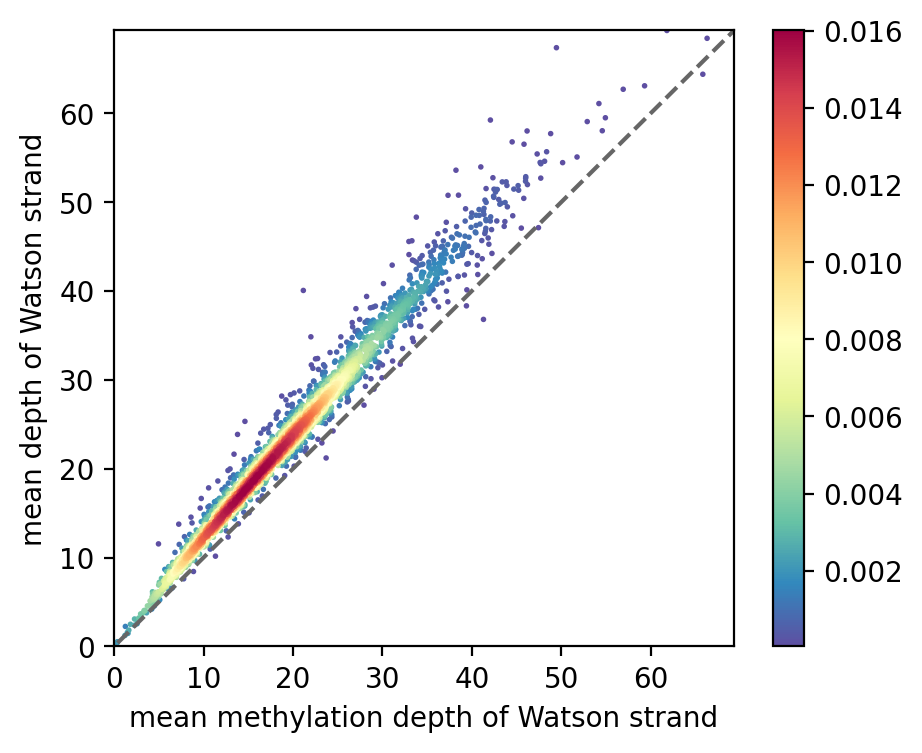

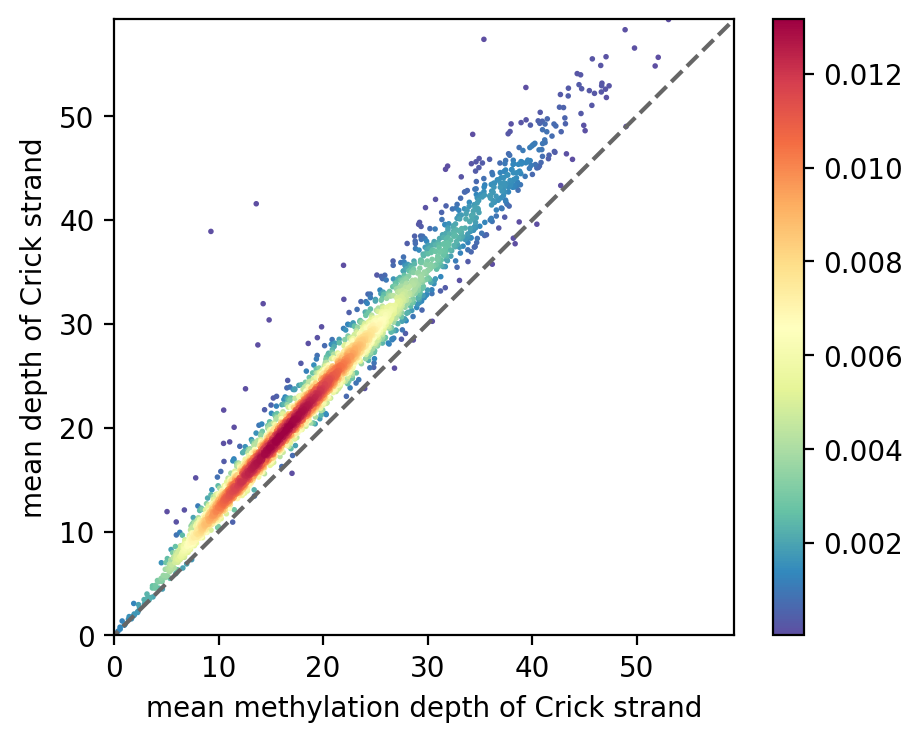

In [105]:
depthW = []
depthC = []
# depthMe = []
depthMeW = []
depthMeC = []
for key, value in dict_binning.items():
    value = dict_binning[key]
    if value.length >= 20:
        depthW.append(value.dpW/value.length)
        depthC.append(value.dpC/value.length)
        # depthMe.append((value.dpCG+value.dpCHG+value.dpCHH)/(value.nCG+value.nCHG+value.nCHH))
        depthMeW.append((value.dpCGW+value.dpCHGW+value.dpCHHW)/(value.nCGW+value.nCHGW+value.nCHHW))
        depthMeC.append((value.dpCGC+value.dpCHGC+value.dpCHHC)/(value.nCGC+value.nCHGW+value.nCHHC))
depthW = np.asarray(depthW)
depthC = np.asarray(depthC)
# depthMe = np.asarray(depthMe)
depthMeW = np.asarray(depthMeW)
depthMeC = np.asarray(depthMeC)

# sampling 3000 points
if len(depthW) > 3000:
    i = gen.choice(len(depthW), size=3000, replace=False)
    depthW = depthW[i]
    depthC = depthC[i]
    depthMeW = depthMeW[i]
    depthMeC = depthMeC[i]


# Watson
xy = np.vstack([depthW, depthMeW])
d = scipy.stats.gaussian_kde(xy)(xy)
idx = d.argsort()
x, y, d = depthMeW[idx], depthW[idx], d[idx]
filename = f'img/depth-vs-meth-depth-of-watson-strand'

fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x, y, c=d, s=1, cmap='Spectral_r')
abline(0, 1, color=COL_gray)
lim = max(np.quantile(y, 0.995), np.quantile(x, 0.995))
plt.ylim(0, lim)
plt.xlim(0, lim)
plt.colorbar()
plt.ylabel('mean depth of Watson strand')
plt.xlabel('mean methylation depth of Watson strand')
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

# Crick
xy = np.vstack([depthC, depthMeC])
d = scipy.stats.gaussian_kde(xy)(xy)
idx = d.argsort()
x, y, d = depthMeC[idx], depthC[idx], d[idx]
filename = f'img/depth-vs-meth-depth-of-crick-strand'

fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x, y, c=d, s=1, cmap='Spectral_r')
abline(0, 1, color=COL_gray)
lim = max(np.quantile(y, 0.995), np.quantile(x, 0.995))
plt.ylim(0, lim)
plt.xlim(0, lim)
plt.colorbar()
plt.ylabel('mean depth of Crick strand')
plt.xlabel('mean methylation depth of Crick strand')
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')


## CG kmer

### whole-genome cgkmer summary

In [106]:
kmer = list()
kmer_n = list()
kmer_nW = list()
kmer_nC = list()
kmer_dp = list()
kmer_dpW = list()
kmer_dpC = list()
kmer_meth = list()
kmer_methW = list()
kmer_methC = list()
kmer_cov = list()

for key, value in dict_cgkmer.items():
    kmer.append(key)
    kmer_n.append(value.n)
    kmer_nW.append(value.nW)
    kmer_nC.append(value.nC)
    kmer_dp.append(value.dp / value.n)
    kmer_dpW.append(value.dpW / value.nW)
    kmer_dpC.append(value.dpC / value.nC)
    kmer_meth.append(nandivide(value.me, value.cov))
    kmer_methW.append(nandivide(value.meW, value.covW))
    kmer_methC.append(nandivide(value.meC, value.covC))
    kmer_cov.append(value.cov / value.n)

# df = pd.DataFrame({'kmer':kmer, 'n':n, 'nW':nW, 'nC':nC, 'dp':dp, 'dpW':dpW, 'dpC':dpC})
dict_kmer = {
    'kmer':kmer, 
    'n': np.asarray(kmer_n), 
    'nW': np.asarray(kmer_nW), 
    'nC': np.asarray(kmer_nC), 
    'dp': np.asarray(kmer_dp), 
    'dpW': np.asarray(kmer_dpW), 
    'dpC': np.asarray(kmer_dpC),
    'me': np.asarray(kmer_meth),
    'meW': np.asarray(kmer_methW),
    'meC': np.asarray(kmer_methC),
    'cov': np.asarray(kmer_cov)
    }

def relativeFreq (x, mean=1/256):
    return x/np.sum(x)/mean

maxdp = 50

### frequency

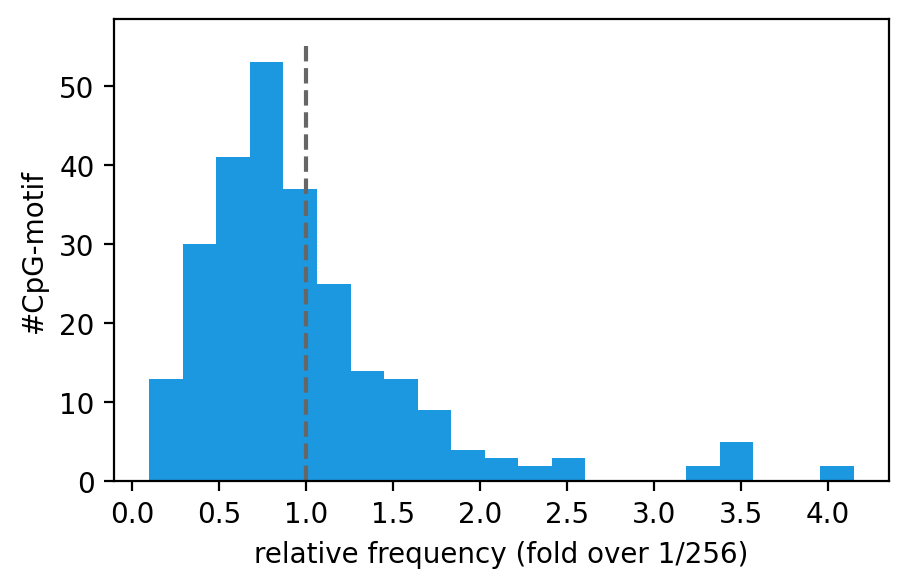

In [178]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(relativeFreq(dict_kmer['n']), bins=21, color=COLS[0])
ax.vlines(1, *ax.get_ylim(), linestyles='dashed', color=COL_gray)
plt.xlabel('relative frequency (fold over 1/256)')
plt.ylabel('#CpG-motif')

filename = f'img/kmer-frequency-dist'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### CG kmer freq on two strands

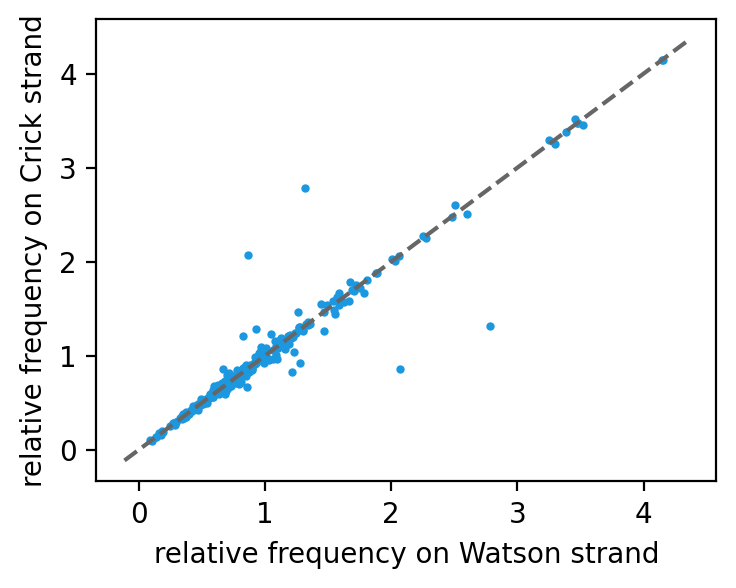

In [108]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(relativeFreq(dict_kmer['nW']), relativeFreq(dict_kmer['nC']), 'o', c=COLS[0], markersize=2)
abline(0, 1, color=COL_gray)
plt.xlabel('relative frequency on Watson strand')
plt.ylabel('relative frequency on Crick strand')

filename = f'img/kmer-stranded-frequency'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### cgkmer meth on two strands

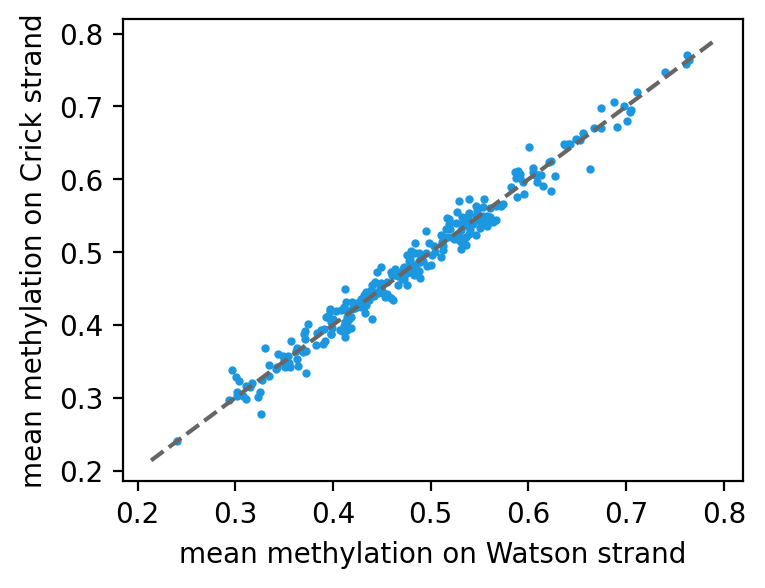

In [109]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(dict_kmer['meW'][:,0], dict_kmer['meC'][:,0], 'o', c=COLS[0], markersize=2)
abline(0, 1, color=COL_gray)
plt.xlabel('mean DNAme level on Watson strand')
plt.ylabel('mean DNAme level on Crick strand')

filename = f'img/kmer-stranded-me-dp1'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [110]:
# for interactive plots
cgkmer_2strands = {'nW': list(signif(relativeFreq(dict_kmer['nW']))),
            'nC': list(signif(relativeFreq(dict_kmer['nC']))),
            'n': list(signif(relativeFreq(dict_kmer['n']))),
            'cgkmer': dict_kmer['kmer'],
            'mean_dp': list(signif(dict_kmer['dp'], 2)),
            'meWdp1': list(signif(dict_kmer['meW'][:,0])),
            'meCdp1': list(signif(dict_kmer['meC'][:,0])),
            'medp1': list(signif(dict_kmer['me'][:,0])),
            'meW': list(signif(dict_kmer['meW'][:,0])),
            'meC': list(signif(dict_kmer['meC'][:,0])),

            'dp': list(range(1, maxdp + 1)),
            'cov': [list(signif(x)) for x in dict_kmer['cov'][:,:maxdp]],
            'me': [list(signif(x)) for x in dict_kmer['me'][:,:maxdp]],
            # 'cgkmer': dict_kmer['kmer']
            }
data['cgkmer_2strands'] = cgkmer_2strands
json.dumps(cgkmer_2strands)


'{"nW": [1.17, 1.182, 1.264, 1.464, 1.303, 1.278, 2.279, 2.251, 3.481, 3.471, 2.007, 2.032, 3.295, 3.25, 3.521, 3.456, 1.016, 0.98, 0.625, 0.621, 0.871, 0.823, 1.442, 1.552, 0.356, 0.344, 0.641, 0.614, 0.913, 0.924, 0.828, 0.814, 0.714, 0.773, 2.063, 1.338, 1.323, 0.745, 0.745, 1.237, 1.248, 0.739, 0.713, 1.316, 2.781, 0.481, 0.484, 1.011, 1.0, 0.589, 0.563, 0.376, 0.353, 1.545, 1.488, 4.149, 4.143, 1.721, 1.725, 1.809, 1.17, 0.137, 0.139, 1.628, 1.573, 2.478, 1.1, 0.47, 0.452, 1.266, 1.303, 0.519, 0.516, 1.692, 1.706, 1.273, 1.296, 0.612, 0.6, 1.044, 1.23, 0.802, 0.814, 1.583, 1.536, 0.883, 0.897, 0.863, 2.067, 1.029, 0.955, 0.878, 0.882, 0.473, 0.483, 1.207, 1.192, 0.711, 0.804, 1.156, 1.077, 1.753, 1.721, 0.673, 0.685, 1.161, 1.115, 1.282, 0.926, 0.974, 0.973, 1.011, 1.085, 0.967, 1.098, 0.78, 0.854, 1.22, 1.199, 0.249, 0.693, 0.63, 0.813, 0.716, 0.972, 0.963, 1.21, 1.186, 1.193, 1.13, 0.93, 0.927, 1.673, 1.781, 0.796, 0.773, 1.586, 1.665, 0.745, 0.767, 0.538, 0.497, 0.78, 0.753, 0.

### kmer dp vs frequency

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

# ax.plot(relativeFreq(dict_kmer['n']), dict_kmer['cov'][:,0], 'o', c=COLS[0], markersize=3)
ax.plot(relativeFreq(dict_kmer['n']), dict_kmer['dp'], 'o', c=COLS[0], markersize=2)
plt.xlabel("relative frequency on two strands")
plt.ylabel("mean read depth")
plt.vlines(1, ax.get_ylim()[0], ax.get_ylim()[1], colors=COL_gray, linestyles='dashed')

filename = f'img/kmer-mean-depth-vs-freq'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## interactive plot

### kmer meth vs frequency

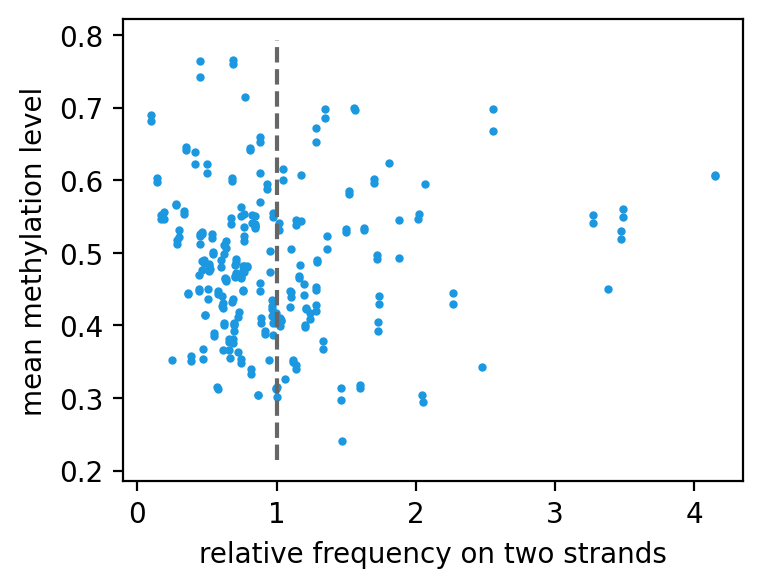

In [111]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(relativeFreq(dict_kmer['n']), dict_kmer['me'][:,0], 'o', c=COLS[0], markersize=2)

plt.xlabel("relative frequency on two strands")
plt.ylabel("mean methylation level")
plt.vlines(1, ax.get_ylim()[0], ax.get_ylim()[1], colors=COL_gray, linestyles='dashed')

filename = f'img/kmer-meth-vs-frequency'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

### kmer coverage vs DP

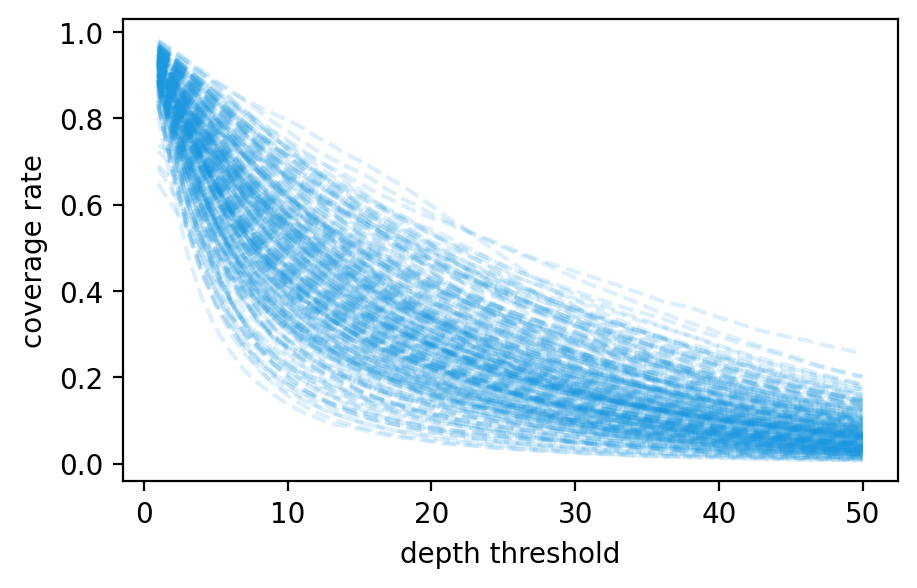

In [112]:
maxdp = 50
fig, ax = plt.subplots(figsize=(5, 3))
dp = np.arange(start=1, stop=maxdp+1)
for i in range(np.shape(dict_kmer["cov"])[0]):
    ax.plot(dp, dict_kmer['cov'][i,:maxdp], '--', c=COLS[0], alpha=0.15)
plt.xlabel("depth threshold")
plt.ylabel("coverage rate")

filename = f'img/kmer-coverage-vs-depth'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [135]:
# for interactive plots
# json.dumps(
#     {
#         'dp': list(range(1, maxdp+1)),
#         'cov': [list(signif(x)) for x in dict_kmer['cov'][:,:maxdp]],
#         'me': [list(signif(x)) for x in dict_kmer['me'][:,:maxdp]],
#         'cgkmer': dict_kmer['kmer']
#     }
#     )

### kmer meth vs DP >= k

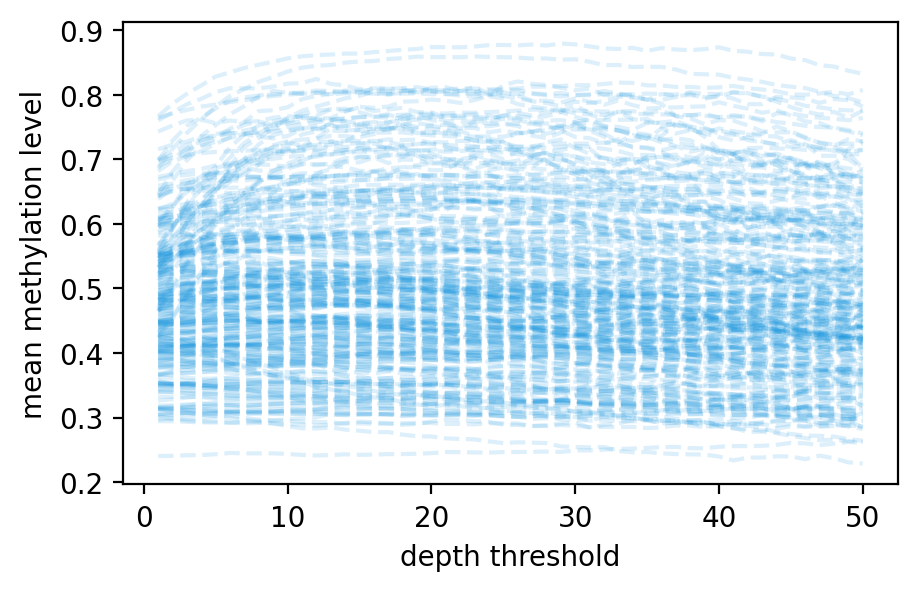

In [113]:
fig, ax = plt.subplots(figsize=(5, 3))
dp = np.arange(start=1, stop=maxdp+1)
for i in range(np.shape(dict_kmer['cov'])[0]):
    ax.plot(dp, dict_kmer['me'][i,:maxdp], '--', c=COLS[0], alpha=0.15)
plt.xlabel("depth threshold")
plt.ylabel("mean methylation level")

filename = f'img/kmer-meth-vs-depth'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## RRBS cgkmer

Msp1 cuts `C'CGG`

In [115]:
dict_rrbs = {
    'ccgg': {
        'kmer':[], 
        'n': 0, 
        'nW': 0, 
        'nC': 0, 
        'dp': 0, 
        'dpW': 0, 
        'dpC': 0,
        'me': 0.,
        'meW': 0.,
        'meC': 0.,
        'cov': 0 
    },
    'non-ccgg': {
        'kmer':[], 
        'n': 0, 
        'nW': 0, 
        'nC': 0, 
        'dp': 0, 
        'dpW': 0, 
        'dpC': 0,
        'me': 0.,
        'meW': 0.,
        'meC': 0.,
        'cov': 0 
    }
    }

rrbs_kmer = [f'{a}CCGG{b}' for a, b in itertools.product(BASES, BASES)]

for key, value in dict_cgkmer.items():
    rrbskey = 'ccgg' if key in rrbs_kmer else 'non-ccgg'
    dict_rrbs[rrbskey]['kmer'].append(key)
    # kmer.append(key)
    dict_rrbs[rrbskey]['n'] += value.n
    dict_rrbs[rrbskey]['nW'] += value.nW
    dict_rrbs[rrbskey]['nC'] += value.nC
    # kmer_nW.append(value.nW)
    # kmer_nC.append(value.nC)
    dict_rrbs[rrbskey]['dp'] += value.dp
    dict_rrbs[rrbskey]['dpW'] += value.dpW
    dict_rrbs[rrbskey]['dpC'] += value.dpC
    # kmer_dp.append(value.dp / value.n)
    # kmer_dpW.append(value.dpW / value.nW)
    # kmer_dpC.append(value.dpC / value.nC)
    dict_rrbs[rrbskey]['me'] += value.me
    dict_rrbs[rrbskey]['meW'] += value.meW
    dict_rrbs[rrbskey]['meC'] += value.meC
    # kmer_meth.append(nandivide(value.me, value.cov))
    # kmer_methW.append(nandivide(value.meW, value.covW))
    # kmer_methC.append(nandivide(value.meC, value.covC))
    dict_rrbs[rrbskey]['cov'] += value.cov

maxdp = 30

In [111]:
# dict_rrbs

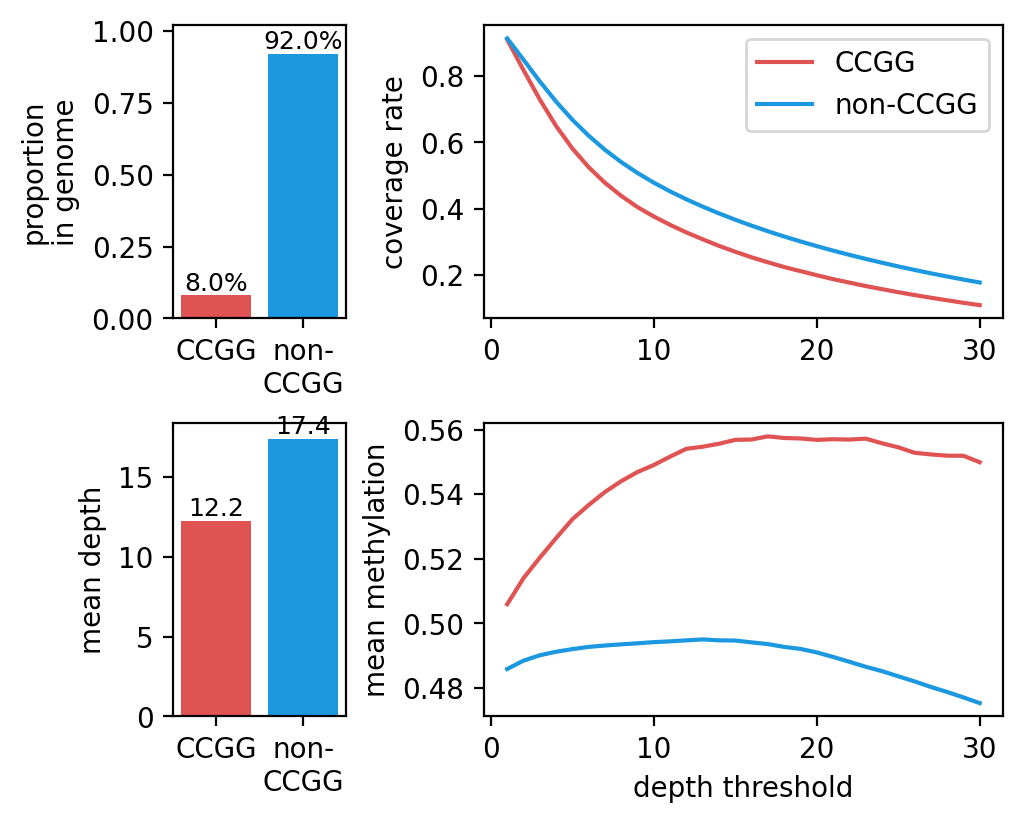

In [211]:
fig, axs = plt.subplots(2, 2, figsize=(5,4), width_ratios=[1,3],layout='constrained')
cglabels = ['CCGG', 'non-\nCCGG']
barcols = [COLS[1], COLS[0]]


a = dict_rrbs['ccgg']['n']
b = dict_rrbs['non-ccgg']['n']
props = [a/(a+b), b/(a+b)]

data['ccgg_prop'] = fp(props[0])

bar1 = axs[0,0].bar(cglabels, [a/(a+b), b/(a+b)], color=barcols)
axs[0,0].set_ylim(top=max(props)+0.1)
axs[0,0].bar_label(bar1, labels=[f'{e*100:.1f}%' for e in props],
            #  padding=8, color='b', 
                   fontsize=9
             )
axs[0,0].set_ylabel('proportion\nin genome')


x = np.arange(maxdp) + 1
axs[0,1].plot(x, dict_rrbs['ccgg']['cov'][:maxdp]/dict_rrbs['ccgg']['n'], color=COLS[1], label='CCGG')
axs[0,1].plot(x, dict_rrbs['non-ccgg']['cov'][:maxdp]/dict_rrbs['non-ccgg']['n'], color=COLS[0], label='non-CCGG')
axs[0,1].legend()
axs[0,1].set_ylabel('coverage rate')


a = dict_rrbs['ccgg']['dp']/dict_rrbs['ccgg']['n']
b = dict_rrbs['non-ccgg']['dp']/dict_rrbs['non-ccgg']['n']

data['ccgg_mean_dp'] = ff(a)

bar2 = axs[1,0].bar(cglabels, [a, b], color=barcols)
axs[1,0].bar_label(bar2, labels=[f'{e:.1f}' for e in [a, b]],
            #  padding=8, color='b', 
                   fontsize=9
             )
axs[1,0].set_ylim(top=max([a, b])+1)
axs[1,0].set_ylabel('mean depth')
# axs[1,0].set_xlabel('CpG context')


x = np.arange(maxdp) + 1 
axs[1,1].plot(x, dict_rrbs['ccgg']['me'][:maxdp]/dict_rrbs['ccgg']['cov'][:maxdp], color=COLS[1])
axs[1,1].plot(x, dict_rrbs['non-ccgg']['me'][:maxdp]/dict_rrbs['non-ccgg']['cov'][:maxdp], color=COLS[0])
axs[1,1].set_xlabel('depth threshold')
axs[1,1].set_ylabel('mean methylation')


filename = f'img/rrbs-kmer-summary'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## Saturation curve

In [117]:
def saturation_curve_binning(sampled_bases: int, cov: NDArray):

    maxdp = len(cov) - np.argmax(cov[::-1] > 0)
    depths = np.repeat(np.arange(1, maxdp+1), cov[:maxdp])

    if sampled_bases >= np.sum(depths):
        return np.array(cov[ [0,2,4,9] ])
    # sampled_bases = min(sampled_bases, np.sum(cov[:maxdp]*np.arange(1, maxdp+1)))

    # gen = np.random.Generator(np.random.PCG64())
    sampling = gen.multivariate_hypergeometric(depths, sampled_bases)

    return np.array([np.sum(sampling>=1), np.sum(sampling>=3), np.sum(sampling>=5), np.sum(sampling>=10)])

In [114]:
# class Saturation_curve(NamedTuple):
#     curve: NDArray
#     cov_rate: float # whole-genome coverage rate, DP>=1
#     unseq_rate: float # unsequenced prop of bases
#     DNAlost_rate: float # DNA template lost


### DNA template lose

In [154]:
## coverage rate single-strand DP>=1
single_DP1_coverage = (binning_covW[:,0].sum() + binning_covC[:,0].sum()) / length.sum() / 2

# unsequenced base prop by Emperical Bayes
prop_unsequenced =  (binning_covW[:,0].sum() - binning_covW[:,1].sum() + binning_covC[:,0].sum() - binning_covC[:,1].sum()) / totalBases
# prop of whole genome
prop_unsequenced = single_DP1_coverage * prop_unsequenced/(1-prop_unsequenced)
DNA_lost = max(0, 1 - prop_unsequenced - single_DP1_coverage)

## sequencing saturation 
saturaion_level = 1 - prop_unsequenced

data['prop_cov_DP1'] = fp(single_DP1_coverage)
data['prop_unsequenced'] = fp(prop_unsequenced)
data['prop_asymptotic'] = fp(single_DP1_coverage + prop_unsequenced)
data['prop_lost'] = fp(DNA_lost)
data['saturaion'] = fp(saturaion_level)

print(f'{single_DP1_coverage = }\n{prop_unsequenced = }\n{saturaion_level = }\n{DNA_lost = }')

single_DP1_coverage = np.float64(0.9535530500557331)
prop_unsequenced = np.float64(0.0013652293778035418)
saturaion_level = np.float64(0.9986347706221964)
DNA_lost = np.float64(0.04508172056646331)


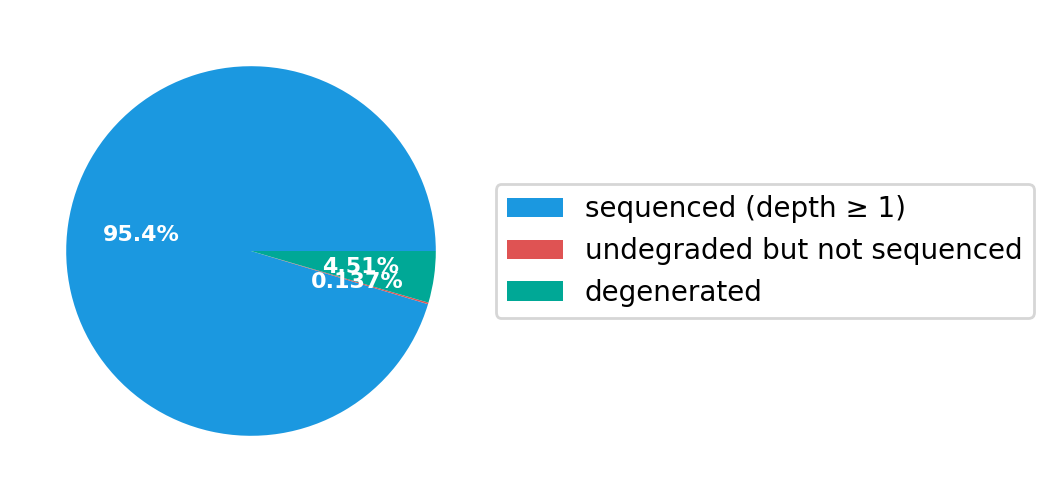

In [122]:
# pie plot of DNA
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

DNA_composition = ["sequenced (depth ≥ 1)",
          "undegraded but not sequenced",
          "degenerated"]

props = [single_DP1_coverage, prop_unsequenced, DNA_lost]
wedges, texts, autotexts = ax.pie(
    props,
    # labels=DNA_composition, 
    autopct=lambda x:fp(x/100)+'%', 
    textprops=dict(color="w"),
    colors=COLS[:3]
    )

ax.legend(wedges, DNA_composition,
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
# plt.show()

filename = f'img/pie-DNA-lost'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

In [123]:
def saturation_curve(breaks=30):
    """
    single-stranded saturation curve
    """

    # gen = np.random.Generator(np.random.PCG64())
    
    genome_coverages = np.zeros(shape=(breaks+1, 4))
    # covsum = binning_depth.sum(axis=0)
    # coverage rate for all reads
    genome_coverages[breaks,:] = np.array([
        binning_covW[:,0].sum() + binning_covC[:,0].sum(),
        binning_covW[:,2].sum() + binning_covC[:,2].sum(),
        binning_covW[:,4].sum() + binning_covC[:,4].sum(),
        binning_covW[:,9].sum() + binning_covC[:,9].sum()]
        )/length.sum()/2
    

    # sampled_bases = np.logspace(0, np.log10(totalDepth.sum()), breaks+1, dtype=np.int64) -1
    sampled_basesW = np.linspace(0, totalBasesW, breaks+1, dtype=np.int64)
    sampled_basesC = np.linspace(0, totalBasesC, breaks+1, dtype=np.int64)
    for i in np.arange(1, breaks):

        # Watson strand
        bin_basesW = gen.multinomial(sampled_basesW[i], totalDepthW/totalBasesW, size=1)[0,:]
        # DP >= 1,3,5,10
        coveraged_basesW = [
            saturation_curve_binning(bin_basesW[j], binning_depthW[j,:])
            for j in range(len(length))
            ]

        # Crick strand
        bin_basesC = gen.multinomial(sampled_basesC[i], totalDepthC/totalBasesC, size=1)[0,:]
        # bin_bases = np.fmin(bin_bases, totalDepth)

        # DP >= 1,3,5,10
        coveraged_basesC = [
            saturation_curve_binning(bin_basesC[j], binning_depthC[j,:])
            for j in range(len(length))
            ]
        
        genome_coverages[i,:] = (np.asarray(coveraged_basesW).sum(axis=0) + np.asarray(coveraged_basesC).sum(axis=0))/length.sum()/2

    # add mean sequencing depth
    return np.hstack([
        genome_coverages, 
        (sampled_basesW+sampled_basesC).reshape((-1,1))/length.sum()/2
        ])


In [124]:
sc = saturation_curve(breaks=30)

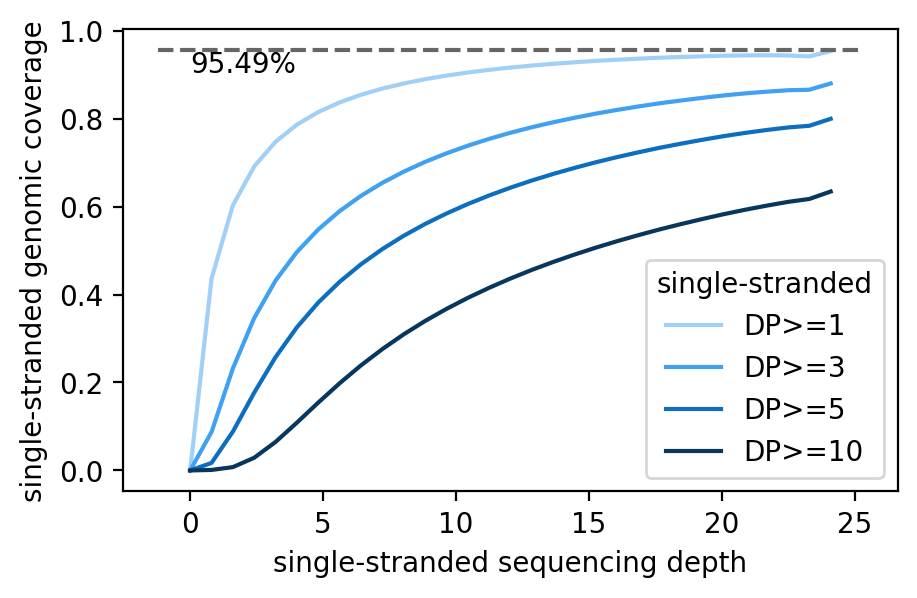

In [125]:
fig, ax = plt.subplots(figsize=(5, 3))

dp = [1,3,5,10]
# cols = ['red', 'blue', 'green', 'orange']
# cols = COLS[:4]
cols = ['#a0d0f8', '#40a0f2','#0d6dbf', '#07375f']

size = np.shape(sc)
x = sc[:,-1]
for i in range(size[1]-1):
    ax.plot(x, sc[:,i], '-', c=cols[i], alpha=1, label='DP>='+str(dp[i]))
# ax.plot(np.linspace(0, sc[-1, -1], 10), np.repeat(1-DNA_lost, 10), '--')
abline(1-DNA_lost, 0, color=COL_gray)
linewidth = 0.001
ax.text(0, 1-DNA_lost-linewidth, f'{100-DNA_lost*100:.2f}%', verticalalignment='top')
ax.legend(title='single-stranded')
plt.xlabel('single-stranded sequencing depth')
plt.ylabel('single-stranded genomic coverage')

filename = f'img/saturation-curve'
plt.savefig(filename+'.png', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig(filename+'.svg', transparent=True, bbox_inches='tight')

## experimental

### fit the culmualtive coverage curve

In [119]:
# from scipy.optimize import curve_fit

# def logodds(x):
#     return np.log(x/(1-x))

# def logistic(x):
#     return np.exp(x)/(1 + np.exp(x))

# def f(x, a, b, c, d, e):
#     return e - np.exp(a*x+b)/(1+np.exp(c*x+d))

# def f2(x, a, b, c,d):
#     return a - np.exp(b*x*+c)


# x = sc.curve[:,-1]
# popt, pcov = curve_fit(f, x[2:], sc.curve[2:,1], method='trf')

In [120]:
# fig, ax = plt.subplots(figsize=(5, 3))

# dp = [1,5,10,20]
# cols = ['red', 'blue', 'green', 'orange']
# size = np.shape(sc.curve)
# for i in range(size[1]-1):
#     ax.plot(x, sc.curve[:,i], '-', c=cols[i], alpha=1, label='DP>='+str(dp[i]))
#     ax.plot(x, f(x, *popt), '.--', c='black')
# ax.plot(np.linspace(0, sc.curve[-1, -1], 10), np.repeat(1., 10), '--')
# ax.legend()
# plt.show()

## write report

In [127]:

import io
import os
import re
import json
import base64

from jinja2 import PackageLoader,Environment,FileSystemLoader
from utils import lzstring

def compress_json(data):
    """Take a Python data object. Convert to JSON and compress using lzstring"""
    json_string = json.dumps(data).encode("utf-8", "ignore").decode("utf-8")
    json_string = sanitise_json(json_string)
    x = lzstring.LZString()
    return x.compressToBase64(json_string)

def sanitise_json(json_string):
    """
    The Python json module uses a bunch of values which are valid JavaScript
    but invalid JSON. These crash the browser when parsing the JSON.
    Nothing in the MultiQC front-end uses these values, so instead we just
    do a find-and-replace for them and switch them with `null`, which works fine.

    Side effect: Any string values that include the word "Infinity"
    (case-sensitive) will have it switched for "null". Hopefully that doesn't happen
    a lot, otherwise we'll have to do this in a more complicated manner.
    """
    json_string = re.sub(r"\bNaN\b", "null", json_string)
    json_string = re.sub(r"\b-?Infinity\b", "null", json_string)
    return json_string

# Function to include file contents in Jinja template
def include_file(name, fdir='report/', b64=False):
    try:
        if fdir is None:
            fdir = ""
        if b64:
            with io.open(os.path.join(fdir, name), "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            with io.open(os.path.join(fdir, name), "r", encoding="utf-8") as f:
                return f.read()
    except (OSError, IOError) as e:
        # logger.error(f"Could not include file '{name}': {e}")
        pass

In [219]:

# from .utils import config

config = dict()
config['title'] = f'bsDoctor Report of Sample: {SAMPLE}'

env = Environment(loader=FileSystemLoader('report/'))
# env.globals["include_file"] = include_file
# template = env.get_template('base.html')   
template = env.get_template('report-bootstrap.jinja-html')
temp_out = template.render(alldata=data, config=config)   

with open('report/out.html', 'w', encoding='utf-8') as f:
    f.writelines(temp_out)
    f.close()
